# SWB Regression Pipeline - Beta Power 

- Single Electrode Trial Averaged Regressions with Permutation Statistics
- Robust regression bdi ~ cpe regression coefficients for each ROI
- Regression formula: beta power ~ choice + trialEV + profit + rpe + cpe

Created: 07/30/24 \
Updated: 11/06/2024 \


In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm
import patsy
from statsmodels.api import OLS
from scipy import stats
from tqdm import tqdm
from sklearn.linear_model import RANSACRegressor, LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2



In [3]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/'
anat_dir   = f'{base_dir}recon_labels/'
neural_dir = f'{base_dir}data/'
save_dir   = f'{base_dir}results/bandpow_encoding_models/'
fig_dir    = f'{base_dir}figs/bandpow_regressions/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)



09302024


In [4]:
import sys
sys.path.append(f'{base_dir}LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *
from plot_tools import *



In [5]:
subj_ids = list(pd.read_excel(f'{base_dir}/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


In [6]:
bdi_list = pd.read_excel(f'{base_dir}/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
subj_info_df = pd.DataFrame({'subj_id':subj_ids,'bdi':bdi_list})
subj_info_df



subj_id  bdi
0    MS002   14
1    MS003    8
2    MS009   16
3    MS011   13
4    MS015   26
5    MS016   10
6    MS017   26
7    MS019   12
8    MS022   10
9    MS024   16
10   MS025   10
11   MS026    9
12   MS027   22
13   MS028   13
14   MS029   32
15   MS030   19
16   MS033   39
17   MS035   15
18   MS041   10
19   MS043   23
20   MS048   19
21   MS050    9
22     DA8   13
23   DA023   14
24   DA026   19
25   DA037    4
26   DA039   22

# Load beta power data 

In [7]:
epoch_len = '1sec'
band = 'beta'

In [8]:
beta_df = pd.read_csv(f'{save_dir}regression_dfs/{band}_master_df_{epoch_len}.csv')
beta_df.subj_id.unique()



array(['MS002', 'MS003', 'MS009', 'MS011', 'MS015', 'MS016', 'MS017',
       'MS019', 'MS022', 'MS024', 'MS025', 'MS026', 'MS027', 'MS028',
       'MS029', 'MS030', 'MS033', 'MS035', 'MS041', 'MS043', 'MS048',
       'MS050', 'DA8', 'DA023', 'DA026', 'DA037', 'DA039'], dtype=object)

In [9]:
beta_df.columns

Index(['Unnamed: 0', 'subj_id', 'bdi', 'bdi_thresh', 'Round', 'RT',
       'TrialOnset', 'ChoiceOnset', 'DecisionOnset', 'FeedbackOnset',
       'ChoicePos', 'TrialType', 'SafeBet', 'LowBet', 'HighBet',
       'GambleChoice', 'Outcome', 'Profit', 'TotalProfit', 'epoch', 'logRT',
       'GambleEV', 'TrialEV', 'CR', 'choiceEV', 'rpe', 'res_type', 'cf',
       'max_cf', 'cpe', 'max_cpe', 'Round_t1', 'RT_t1', 'ChoicePos_t1',
       'TrialType_t1', 'SafeBet_t1', 'LowBet_t1', 'HighBet_t1',
       'GambleChoice_t1', 'Outcome_t1', 'Profit_t1', 'TotalProfit_t1',
       'epoch_t1', 'logRT_t1', 'GambleEV_t1', 'TrialEV_t1', 'CR_t1',
       'choiceEV_t1', 'rpe_t1', 'res_type_t1', 'cf_t1', 'max_cf_t1', 'cpe_t1',
       'max_cpe_t1', 'keep_epoch', 'keep_epoch_t1', 'CpeOnset',
       'reref_ch_names', 'band_pow', 'roi', 'hemi', 'unique_reref_ch'],
      dtype='object')

In [10]:
roi_reref_labels_master_df = pd.read_csv(
    glob(f'{base_dir}results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [11]:
roi_reref_labels_master_df.roi.value_counts()



roi
dmpfc            225
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
temporal         105
vlpfc             82
ains              71
pins              60
thalamus          58
temporal pole     31
mcc               28
phg               25
motor             25
parietal          24
vmpfc             23
caudate            8
pcc                1
Name: count, dtype: int64

In [12]:
# keep_rois = roi_reref_labels_master_df.roi.value_counts().index[
#     roi_reref_labels_master_df.roi.value_counts().values>=50].tolist()

keep_rois = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','amy','hpc']     

keep_rois

['dlpfc', 'vlpfc', 'dmpfc', 'ofc', 'ains', 'pins', 'acc', 'amy', 'hpc']

In [13]:
# ####### NEW DATA FRAME 
beta_reg_df = beta_df.copy()
beta_reg_df = beta_reg_df[beta_reg_df.roi.isin(keep_rois)]
# len(beta_reg_df)



# Electrode-wise Regressions + Permutations

In [14]:
elec_col    = 'unique_reref_ch'
main_var    = 'cpe'
reg_formula = 'band_pow~GambleChoice+TrialEV+Profit+rpe+cpe'
n_permutations = 1000


In [15]:
results_dict, main_var_sig = run_individual_elec_regression(beta_reg_df,reg_formula,elec_col, 
                                                            main_var,n_permutations)


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3333.01it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3375.12it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3471.24it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3332.08it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3222.28it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3302.34it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3321.44it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3193.10it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3320.98it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3365.39it/s]


In [19]:
save_vars = results_dict['MS002_lacas1-lacas2'].index.tolist()
save_vars


['Intercept', 'GambleChoice[T.safe]', 'TrialEV', 'Profit', 'rpe', 'cpe']

In [17]:
results = single_elec_permutation_results(results_dict,beta_reg_df,save_vars)
results



unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
0     MS002_lacas1-lacas2   MS002    acc   14                     0.062638   
1     MS002_lacas2-lacas3   MS002    acc   14                     0.062795   
2     MS002_lacas3-lacas4   MS002    acc   14                     0.047164   
3     MS002_lacas4-lacas5   MS002    acc   14                     0.008430   
4     MS002_lacas5-lacas6   MS002    acc   14                     0.041894   
...                   ...     ...    ...  ...                          ...   
1183  DA039_rpins1-rpins2   DA039   pins   22                     0.038989   
1184  DA039_rpins2-rpins3   DA039   pins   22                     0.070509   
1185  DA039_rpins3-rpins4   DA039   pins   22                    -0.005433   
1186  DA039_rsgcc6-rsgcc7   DA039  vlpfc   22                     0.022023   
1187  DA039_rsgcc7-rsgcc8   DA039  vlpfc   22                     0.103975   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                                  -0.123822                  -0.021673   
1                                  -0.086248                   0.217292   
2                                  -0.081376                   0.146646   
3                                  -0.021970                   0.326099   
4                                  -0.046182                   0.199258   
...                                      ...                        ...   
1183                               -0.014003                  -0.271416   
1184                               -0.008961                  -0.308466   
1185                               -0.130019                  -0.137238   
1186                               -0.058416                  -0.186831   
1187                               -0.155921                  -0.046823   

      Original_Estimate_Profit  Original_Estimate_rpe  Original_Estimate_cpe  \
0                     0.084899               0.008475               0.013529   
1                    -0.279191               0.277946               0.002570   
2                    -0.164104               0.172035               0.064983   
3                    -0.357296               0.166529               0.112233   
4                    -0.286195               0.183201               0.058915   
...                        ...                    ...                    ...   
1183                  0.468334              -0.267821              -0.067995   
1184                  0.504887              -0.300072              -0.054695   
1185                  0.170370              -0.114497               0.035853   
1186                  0.353607              -0.269539               0.027688   
1187                  0.021779               0.016284               0.118115   

      ...  Z_Score_TrialEV  Z_Score_Profit  Z_Score_rpe  Z_Score_cpe  \
0     ...        -0.077155        0.362634     0.127991     0.241424   
1     ...         1.463624       -1.415293     2.124332     0.048851   
2     ...         1.102487       -0.919769     1.463252     1.418636   
3     ...         2.333079       -1.953523     1.401052     2.241178   
4     ...         1.371539       -1.474860     1.425225     1.217036   
...   ...              ...             ...          ...          ...   
1183  ...        -1.907678        2.142049    -1.724309    -1.166192   
1184  ...        -1.653839        1.738295    -1.469027    -0.713779   
1185  ...        -0.811036        0.643761    -0.584492     0.562090   
1186  ...        -1.329034        1.601185    -1.720727     0.566211   
1187  ...        -0.284600        0.118104     0.026111     1.526902   

      P_Value_Intercept  P_Value_GambleChoice[T.safe]  P_Value_TrialEV  \
0              0.004627                      0.004545         0.938500   
1              0.038478                      0.037840         0.143297   
2              0.035191                      0.035509         0.270250   
3              0.587085                      0.5911

In [18]:
results.columns



Index(['unique_elec_id', 'subj_id', 'roi', 'bdi',
       'Original_Estimate_Intercept', 'Original_Estimate_GambleChoice[T.safe]',
       'Original_Estimate_TrialEV', 'Original_Estimate_Profit',
       'Original_Estimate_rpe', 'Original_Estimate_cpe',
       'Permuted_Mean_Intercept', 'Permuted_Mean_GambleChoice[T.safe]',
       'Permuted_Mean_TrialEV', 'Permuted_Mean_Profit', 'Permuted_Mean_rpe',
       'Permuted_Mean_cpe', 'Permuted_Std_Intercept',
       'Permuted_Std_GambleChoice[T.safe]', 'Permuted_Std_TrialEV',
       'Permuted_Std_Profit', 'Permuted_Std_rpe', 'Permuted_Std_cpe',
       'Z_Score_Intercept', 'Z_Score_GambleChoice[T.safe]', 'Z_Score_TrialEV',
       'Z_Score_Profit', 'Z_Score_rpe', 'Z_Score_cpe', 'P_Value_Intercept',
       'P_Value_GambleChoice[T.safe]', 'P_Value_TrialEV', 'P_Value_Profit',
       'P_Value_rpe', 'P_Value_cpe'],
      dtype='object')

In [20]:
save_path = f'{save_dir}/{band}/'
os.makedirs(save_path, exist_ok=True)

fname = f'{save_path}{band}_perm_regression_results_Profit_rpe_cpe_{date}.pkl'
pickle.dump(results, open(fname,"wb"))

# CPE Coefficients

In [21]:
sig_data = results[results.P_Value_cpe < 0.05]
sig_data



unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
3     MS002_lacas4-lacas5   MS002    acc   14                     0.008430   
12    MS002_laims1-laims2   MS002   ains   14                     0.353449   
16    MS002_laims5-laims6   MS002   ains   14                     0.206369   
56    MS002_ragit2-ragit3   MS002    amy   14                     0.049201   
60    MS002_raims3-raims4   MS002   ains   14                     0.267781   
...                   ...     ...    ...  ...                          ...   
1115        DA8_ltp4-ltp5     DA8   pins   13                    -0.008926   
1119      DA023_lac4-lac5   DA023  dmpfc   14                     0.047405   
1144  DA037_rmins1-rmins2   DA037   pins    4                    -0.007640   
1175      DA039_rof4-rof5   DA039    ofc   22                    -0.081554   
1178      DA039_rof7-rof8   DA039  vlpfc   22                    -0.015144   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
3                                  -0.021970                   0.326099   
12                                 -0.337011                   0.163477   
16                                 -0.170204                   0.216623   
56                                 -0.045106                   0.201586   
60                                 -0.295117                   0.295770   
...                                      ...                        ...   
1115                                0.004014                   0.022430   
1119                               -0.091922                  -0.052607   
1144                                0.020322                   0.026225   
1175                                0.034031                  -0.040785   
1178                               -0.045628                  -0.007754   

      Original_Estimate_Profit  Original_Estimate_rpe  Original_Estimate_cpe  \
3                    -0.357296               0.166529               0.112233   
12                   -0.285313               0.122279               0.179525   
16                   -0.331811               0.216934               0.179585   
56                   -0.307399               0.102983               0.124668   
60                   -0.406658               0.219593               0.181617   
...                        ...                    ...                    ...   
1115                 -0.037187               0.014282               0.027546   
1119                  0.077241               0.040424              -0.115188   
1144                 -0.044118               0.009984               0.049273   
1175                  0.098190              -0.032378              -0.051175   
1178                  0.075081              -0.188839               0.125251   

      ...  Z_Score_TrialEV  Z_Score_Profit  Z_Score_rpe  Z_Score_cpe  \
3     ...         2.333079       -1.953523     1.401052     2.241178   
12    ...         0.713290       -0.909056     0.590329     2.217218   
16    ...         1.002150       -1.183205     1.168421     2.618585   
56    ...         1.322274       -1.516754     0.755524     2.406215   
60    ...         1.407946       -1.479819     1.183580     2.515351   
...   ...              ...             ...          ...          ...   
1115  ...         0.654199       -0.706935     0.445967     2.182929   
1119  ...        -0.369609        0.392612     0.274871    -2.327421   
1144  ...         0.705483       -0.701052     0.228836     3.360597   
1175  ...        -0.678051        1.056143    -0.461882    -2.209291   
1178  ...        -0.028946        0.306575    -1.122153     2.300137   

      P_Value_Intercept  P_Value_GambleChoice[T.safe]  P_Value_TrialEV  \
3          5.870849e-01                  5.911451e-01         0.019644   
12         1.354957e-06                  1.447982e-06         0.475666   
16         2.734507e-03                  2.880606e-03         0.316271   
56         3.233363e-01                  3.316622e-

In [22]:
sig_data.roi.value_counts()



roi
ofc      10
ains      9
acc       8
dmpfc     8
amy       7
dlpfc     6
pins      6
vlpfc     5
hpc       4
Name: count, dtype: int64

In [23]:
sig_data.roi.unique()



array(['acc', 'ains', 'amy', 'ofc', 'dlpfc', 'vlpfc', 'pins', 'dmpfc',
       'hpc'], dtype=object)

### ROI Significance Testing
- % of sig elecs in ROI (also split by BDI)
- binomial test for whether sig proportion of elecs in ROI 
- ttests from zero 


In [24]:
# add mask col for sig cpe elecs 
results['cpe_sig']   = results['P_Value_cpe'].apply(lambda x: 0 if x > 0.05 else 1)
results['bdi_split'] = results['bdi'].apply(lambda x: 0 if x < 20 else 1)

results.head()

# results.to_csv(f'{save_path}{band}_perm_regression_results_df_{epoch_len}.csv')

unique_elec_id subj_id  roi  bdi  Original_Estimate_Intercept  \
0  MS002_lacas1-lacas2   MS002  acc   14                     0.062638   
1  MS002_lacas2-lacas3   MS002  acc   14                     0.062795   
2  MS002_lacas3-lacas4   MS002  acc   14                     0.047164   
3  MS002_lacas4-lacas5   MS002  acc   14                     0.008430   
4  MS002_lacas5-lacas6   MS002  acc   14                     0.041894   

   Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                               -0.123822                  -0.021673   
1                               -0.086248                   0.217292   
2                               -0.081376                   0.146646   
3                               -0.021970                   0.326099   
4                               -0.046182                   0.199258   

   Original_Estimate_Profit  Original_Estimate_rpe  Original_Estimate_cpe  \
0                  0.084899               0.008475               0.013529   
1                 -0.279191               0.277946               0.002570   
2                 -0.164104               0.172035               0.064983   
3                 -0.357296               0.166529               0.112233   
4                 -0.286195               0.183201               0.058915   

   ...  Z_Score_rpe  Z_Score_cpe  P_Value_Intercept  \
0  ...     0.127991     0.241424           0.004627   
1  ...     2.124332     0.048851           0.038478   
2  ...     1.463252     1.418636           0.035191   
3  ...     1.401052     2.241178           0.587085   
4  ...     1.425225     1.217036           0.277605   

   P_Value_GambleChoice[T.safe]  P_Value_TrialEV  P_Value_Profit  P_Value_rpe  \
0                      0.004545         0.938500        0.716878     0.898156   
1                      0.037840         0.143297        0.156983     0.033642   
2                      0.035509         0.270250        0.357693     0.143398   
3                      0.591145         0.019644        0.050758     0.161198   
4                      0.280328         0.170207        0.140250     0.154092   

   P_Value_cpe  cpe_sig  bdi_split  
0     0.809226        0          0  
1     0.961038        0          0  
2     0.156005        0          0  
3     0.025015        1          0  
4     0.223590        0          0  

[5 rows x 36 columns]

In [25]:
cpe_var = 'Z_Score_cpe'

In [26]:
# bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']
bar_order = keep_rois.copy()


In [27]:
results.groupby('roi').agg('mean',numeric_only=True)[cpe_var][bar_order]



roi
dlpfc    0.071371
vlpfc    0.202975
dmpfc    0.122730
ofc     -0.000897
ains     0.552661
pins     0.269541
acc      0.025271
amy     -0.079717
hpc      0.143381
Name: Z_Score_cpe, dtype: float64

In [28]:
roi_sig_info = []

for roi in results.roi.unique().tolist():
    roi_results = results[results.roi==roi]
    # ttest from zero 
    ttest_stat,ttest_pval = ttest_1samp(roi_results[cpe_var],popmean=0)
    # binomial test for significance 
    n = len(roi_results)
    x = np.sum(roi_results.cpe_sig)
    binom_test = scipy.stats.binomtest(x, n, p=0.05, alternative='greater')
    binom_pval = binom_test.pvalue
    binom_prop = binom_test.statistic
    ci_low     = binom_test.proportion_ci(confidence_level=0.95).low
    ci_high    = binom_test.proportion_ci(confidence_level=0.95).high
    # agg results 
    roi_sig_info.append(pd.DataFrame({'roi':roi,'n_total':n,'n_sig':x,'prop_sig':np.divide(x,n),
                                      'n_sig_highbdi':np.sum(roi_results[roi_results.bdi_split==1].cpe_sig),
                                      'ttest_stat':ttest_stat,'ttest_pval':ttest_pval,
                                      'binom_ci_low':ci_low,'binom_ci_high':ci_high,
                                      'binom_prop':binom_prop,'binom_pval':np.round(binom_pval,4)},index=[0]))

roi_sig_info = pd.concat(roi_sig_info).reset_index(drop=True)

In [29]:
roi_sig_info

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat  ttest_pval  \
0    acc      193      8  0.041451              2    0.364437    0.715933   
1  dmpfc      225      8  0.035556              0    1.997639    0.046965   
2    amy      113      7  0.061947              1   -0.858591    0.392400   
3   ains       71      9  0.126761              1    4.070576    0.000122   
4  vlpfc       82      5  0.060976              2    1.739926    0.085670   
5    hpc      135      4  0.029630              1    1.723536    0.087098   
6    ofc      202     10  0.049505              3   -0.012146    0.990322   
7   pins       60      6  0.100000              1    1.761792    0.083285   
8  dlpfc      107      6  0.056075              0    0.712302    0.477843   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
0      0.020790            1.0    0.041451      0.7534  
1      0.017813            1.0    0.035556      0.8786  
2      0.029432            1.0    0.061947      0.3362  
3      0.067750            1.0    0.126761      0.0088  
4      0.024331            1.0    0.060976      0.3912  
5      0.010183            1.0    0.029630      0.9099  
6      0.027101            1.0    0.049505      0.5580  
7      0.044453            1.0    0.100000      0.0787  
8      0.024699            1.0    0.056075      0.4468

In [31]:
sig_rois = roi_sig_info[roi_sig_info.binom_pval<0.05]
sig_rois

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat  ttest_pval  \
3  ains       71      9  0.126761              1    4.070576    0.000122   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
3       0.06775            1.0    0.126761      0.0088

# Plot Results

In [32]:
fig_save_path = f'{fig_dir}{band}/'
os.makedirs(fig_save_path, exist_ok=True)

fig_id = f'{band}_perm_regression_combomodel_cpe_coeff_barplot_{epoch_len}.pdf'

ylabel = fr'${band}_{{zpow}} \sim cpe$'

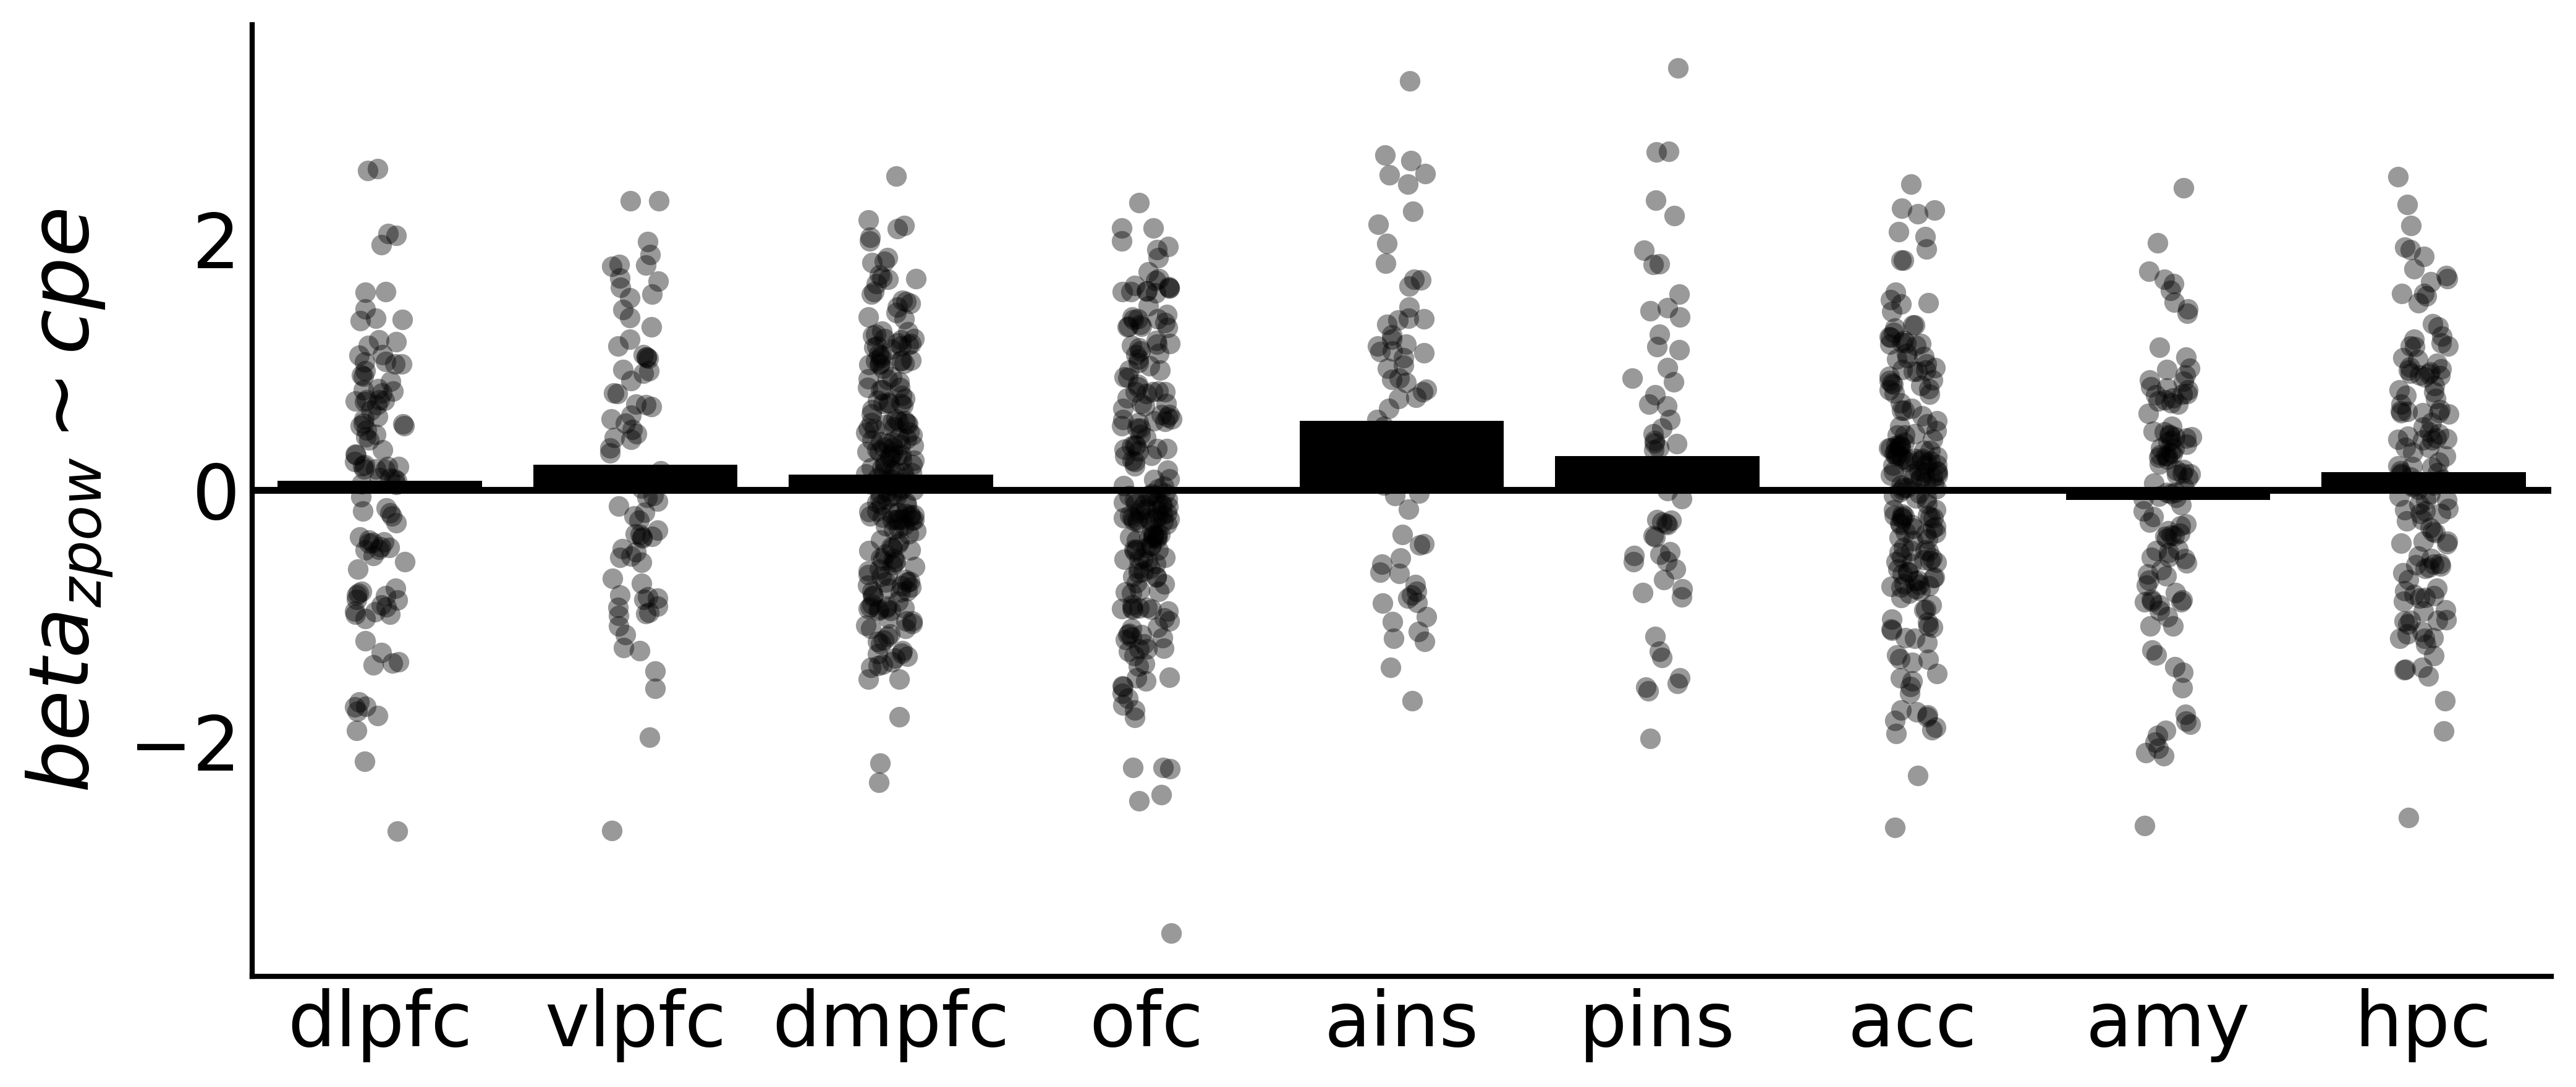

In [33]:
### WITH RPE IN MODEL

plot_roi_model_results(results,'roi',cpe_var,bar_order=keep_rois,figsize=(12,5),color='k',
                       ylabel=ylabel,save_fig=True,save_dir=fig_save_path,fig_id=fig_id,dpi=400)



## BDI correlations

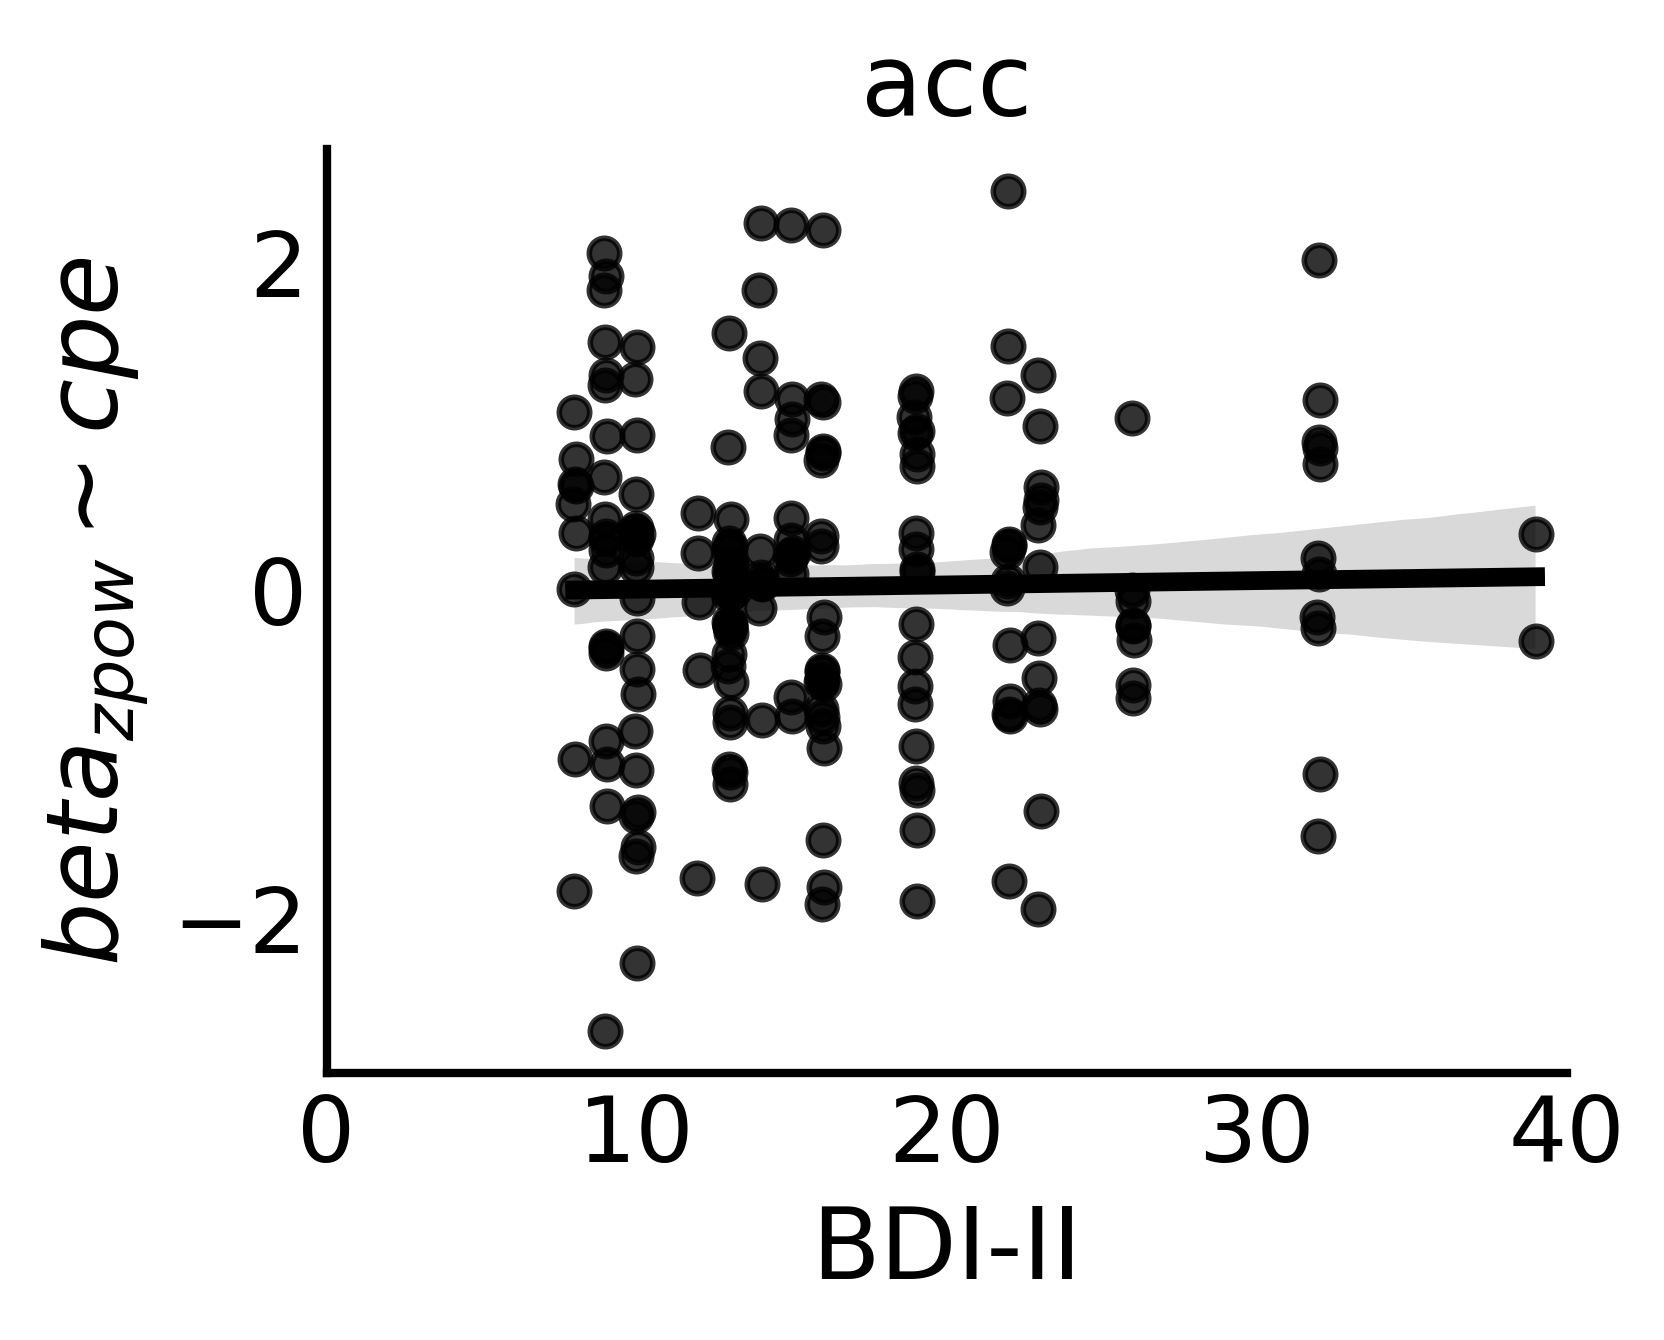

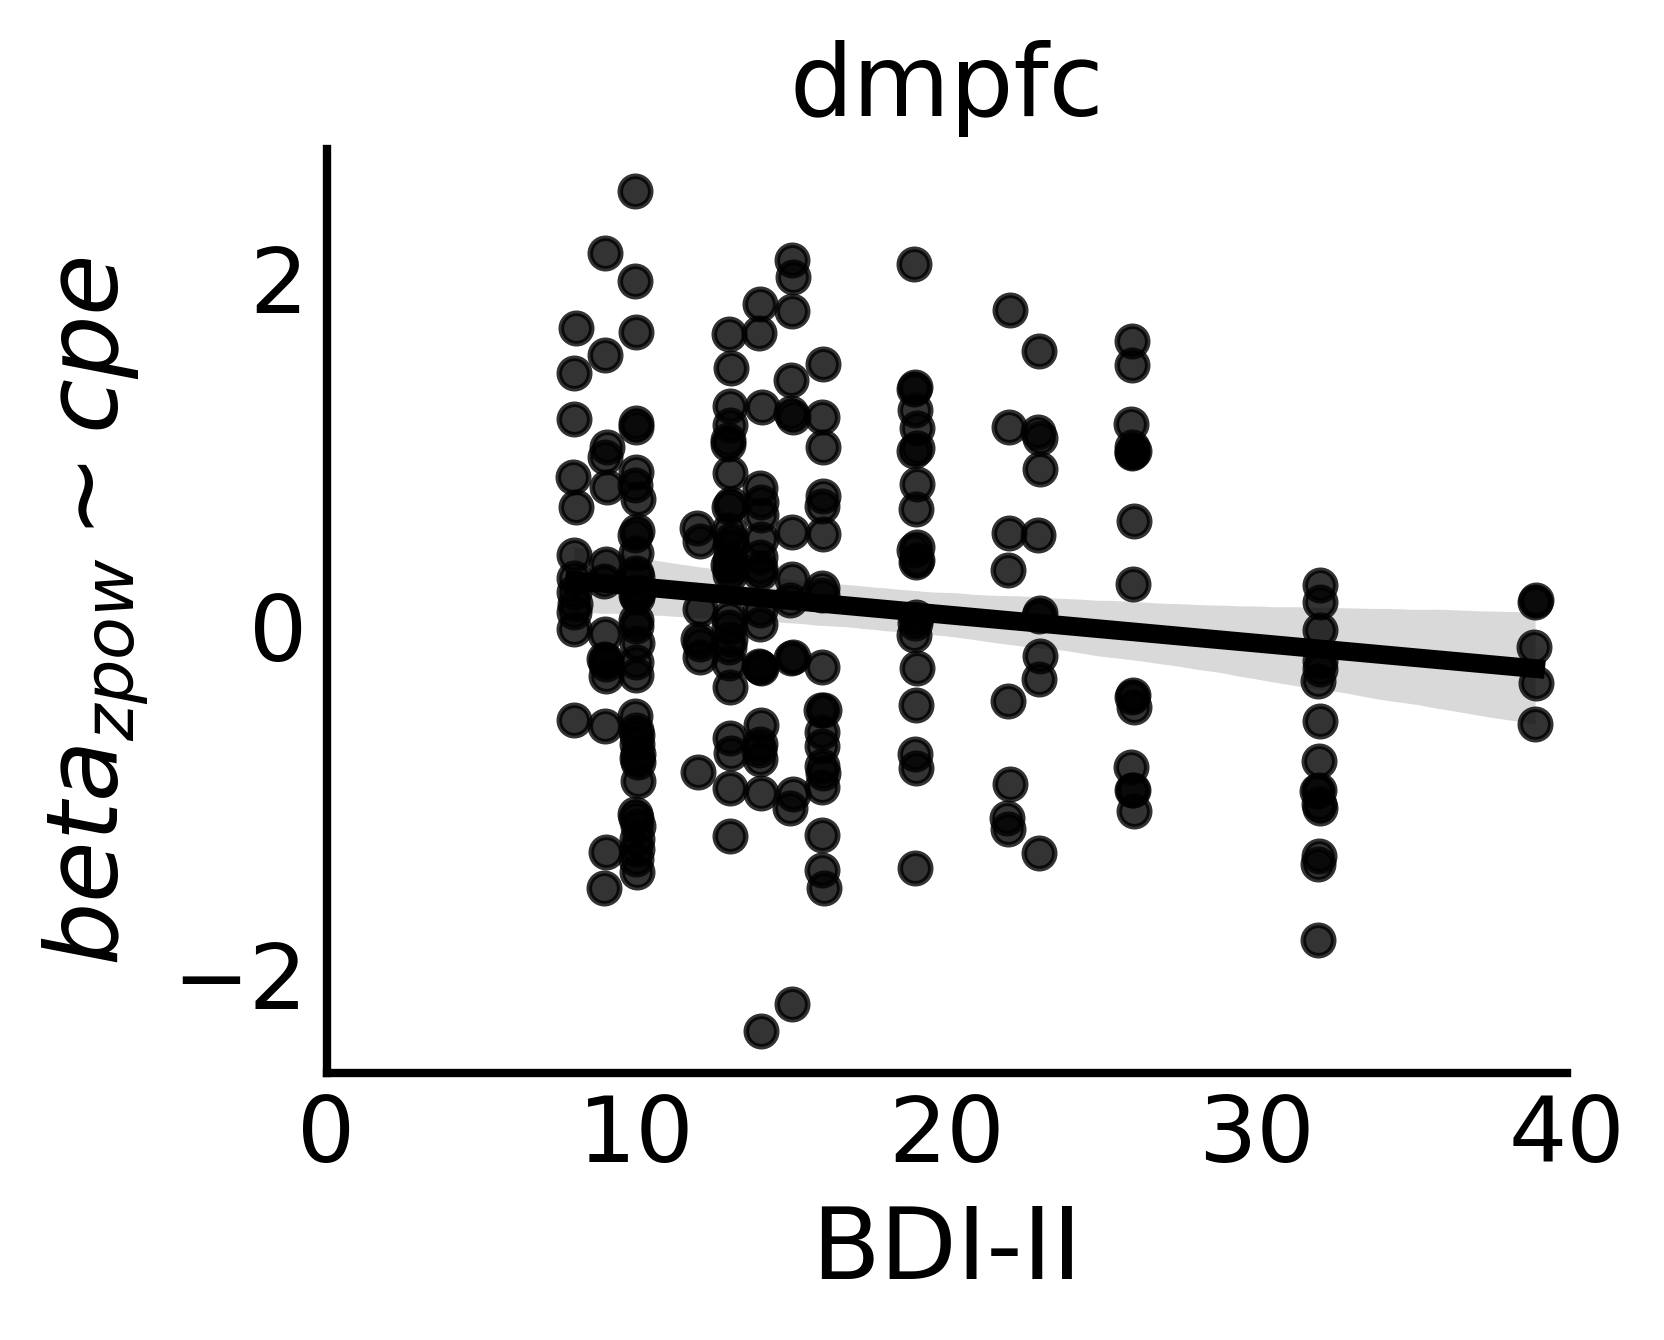

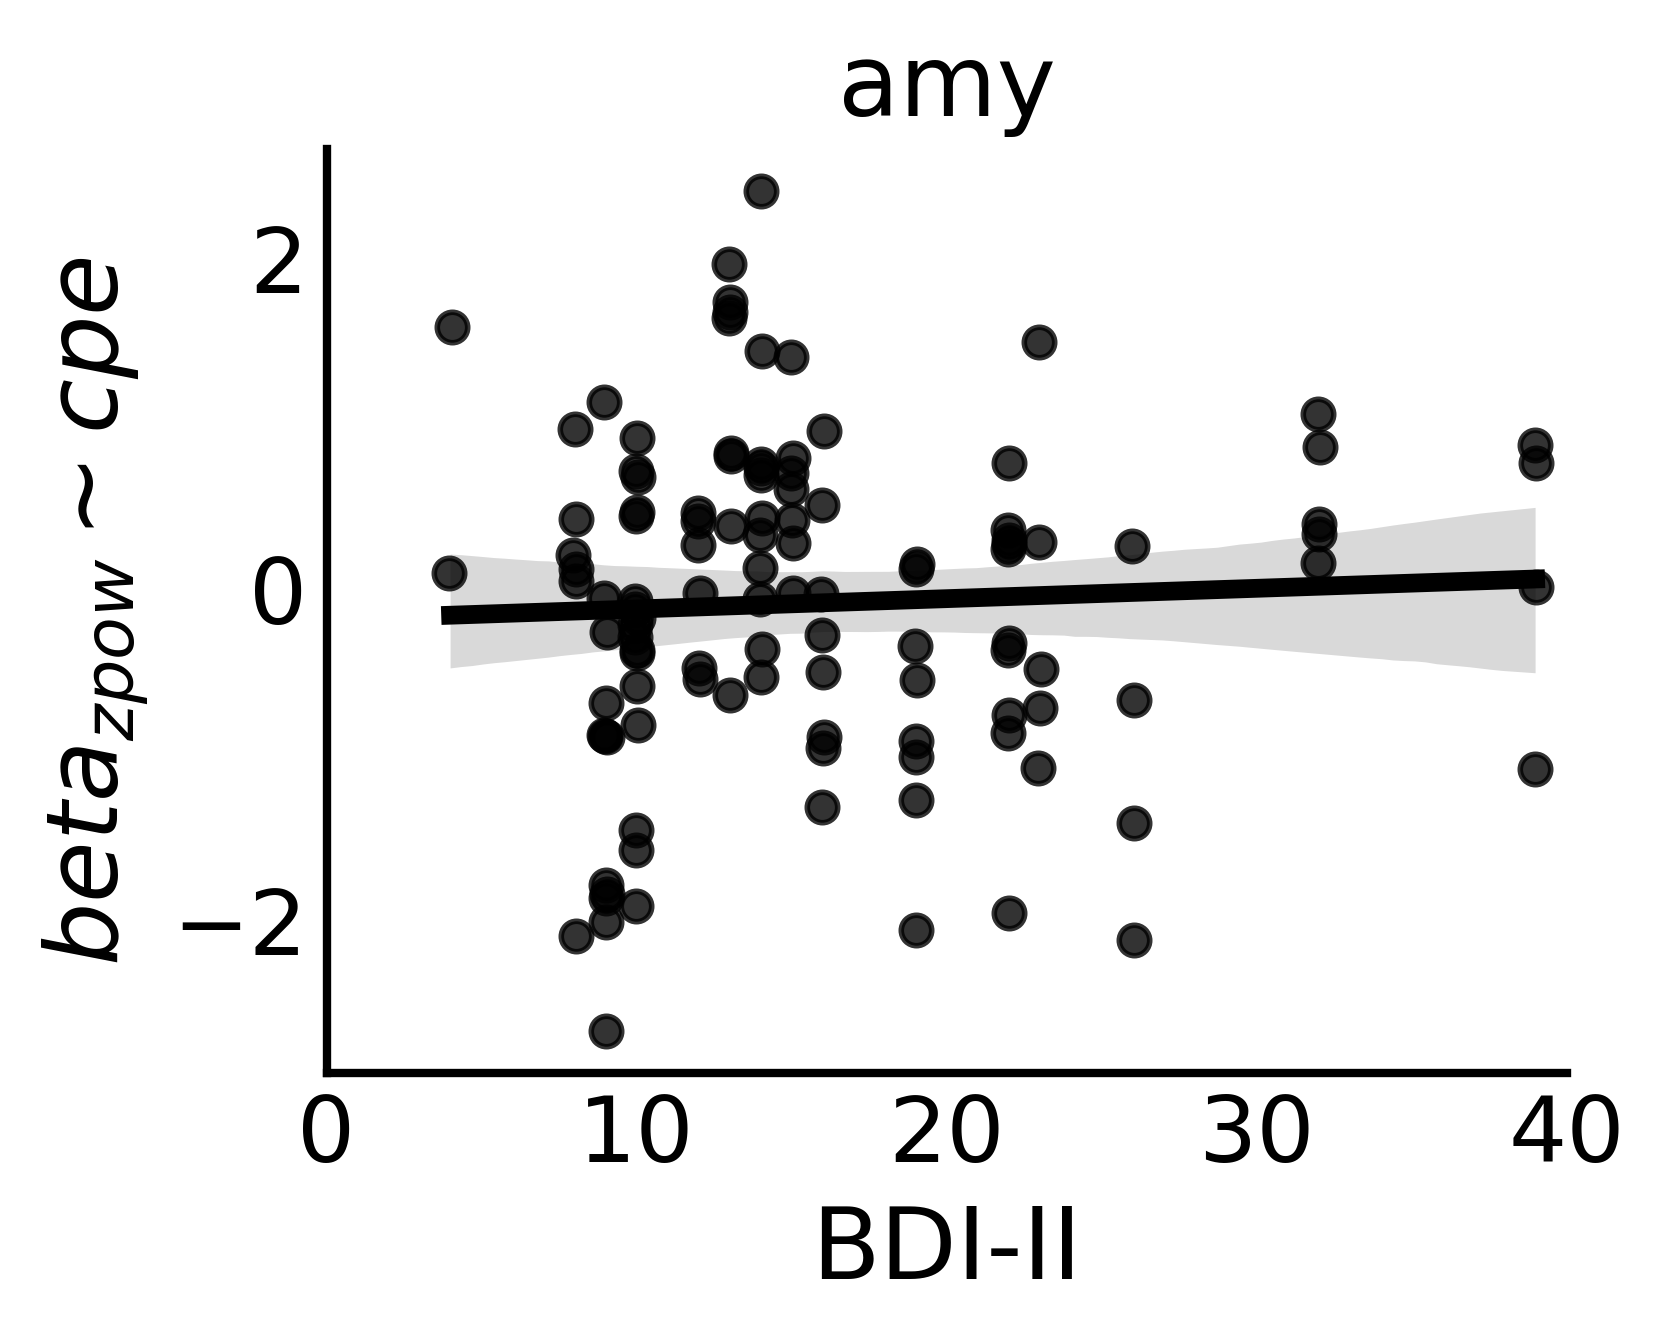

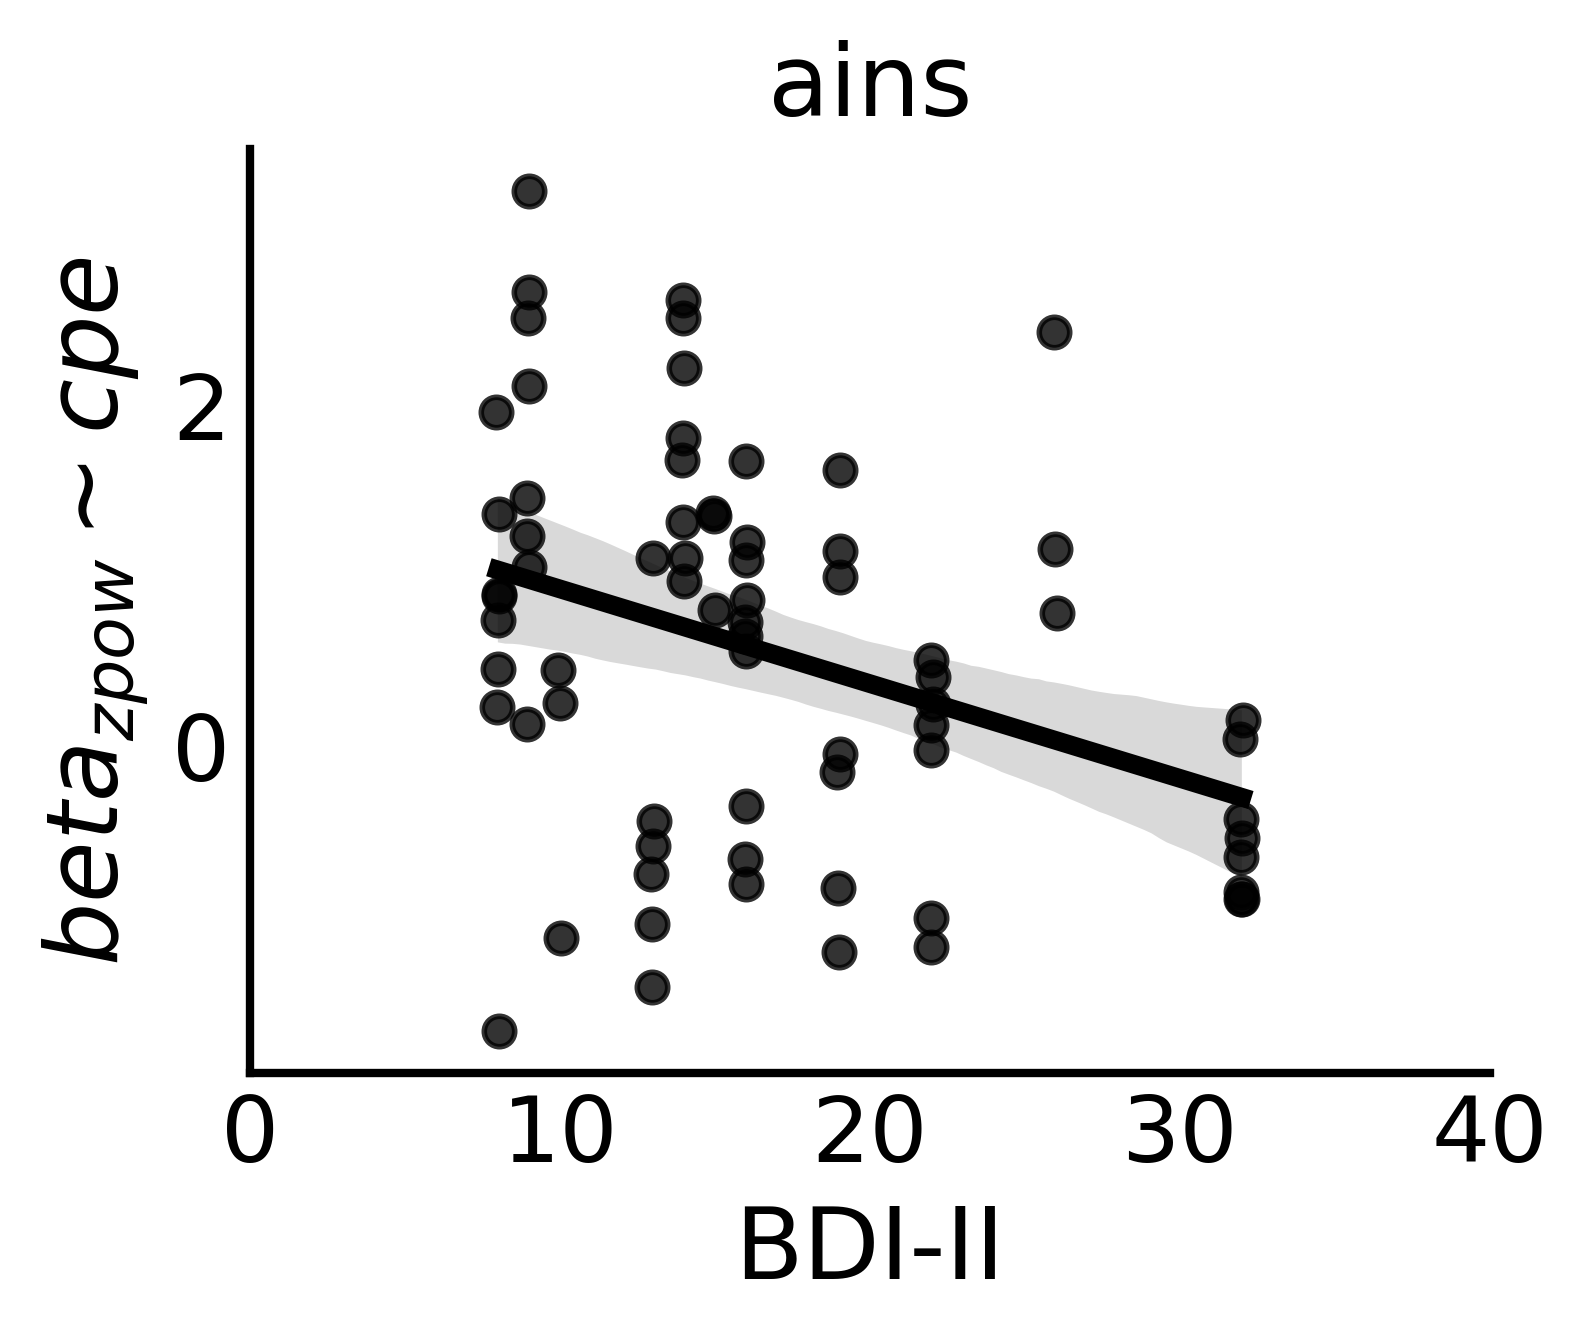

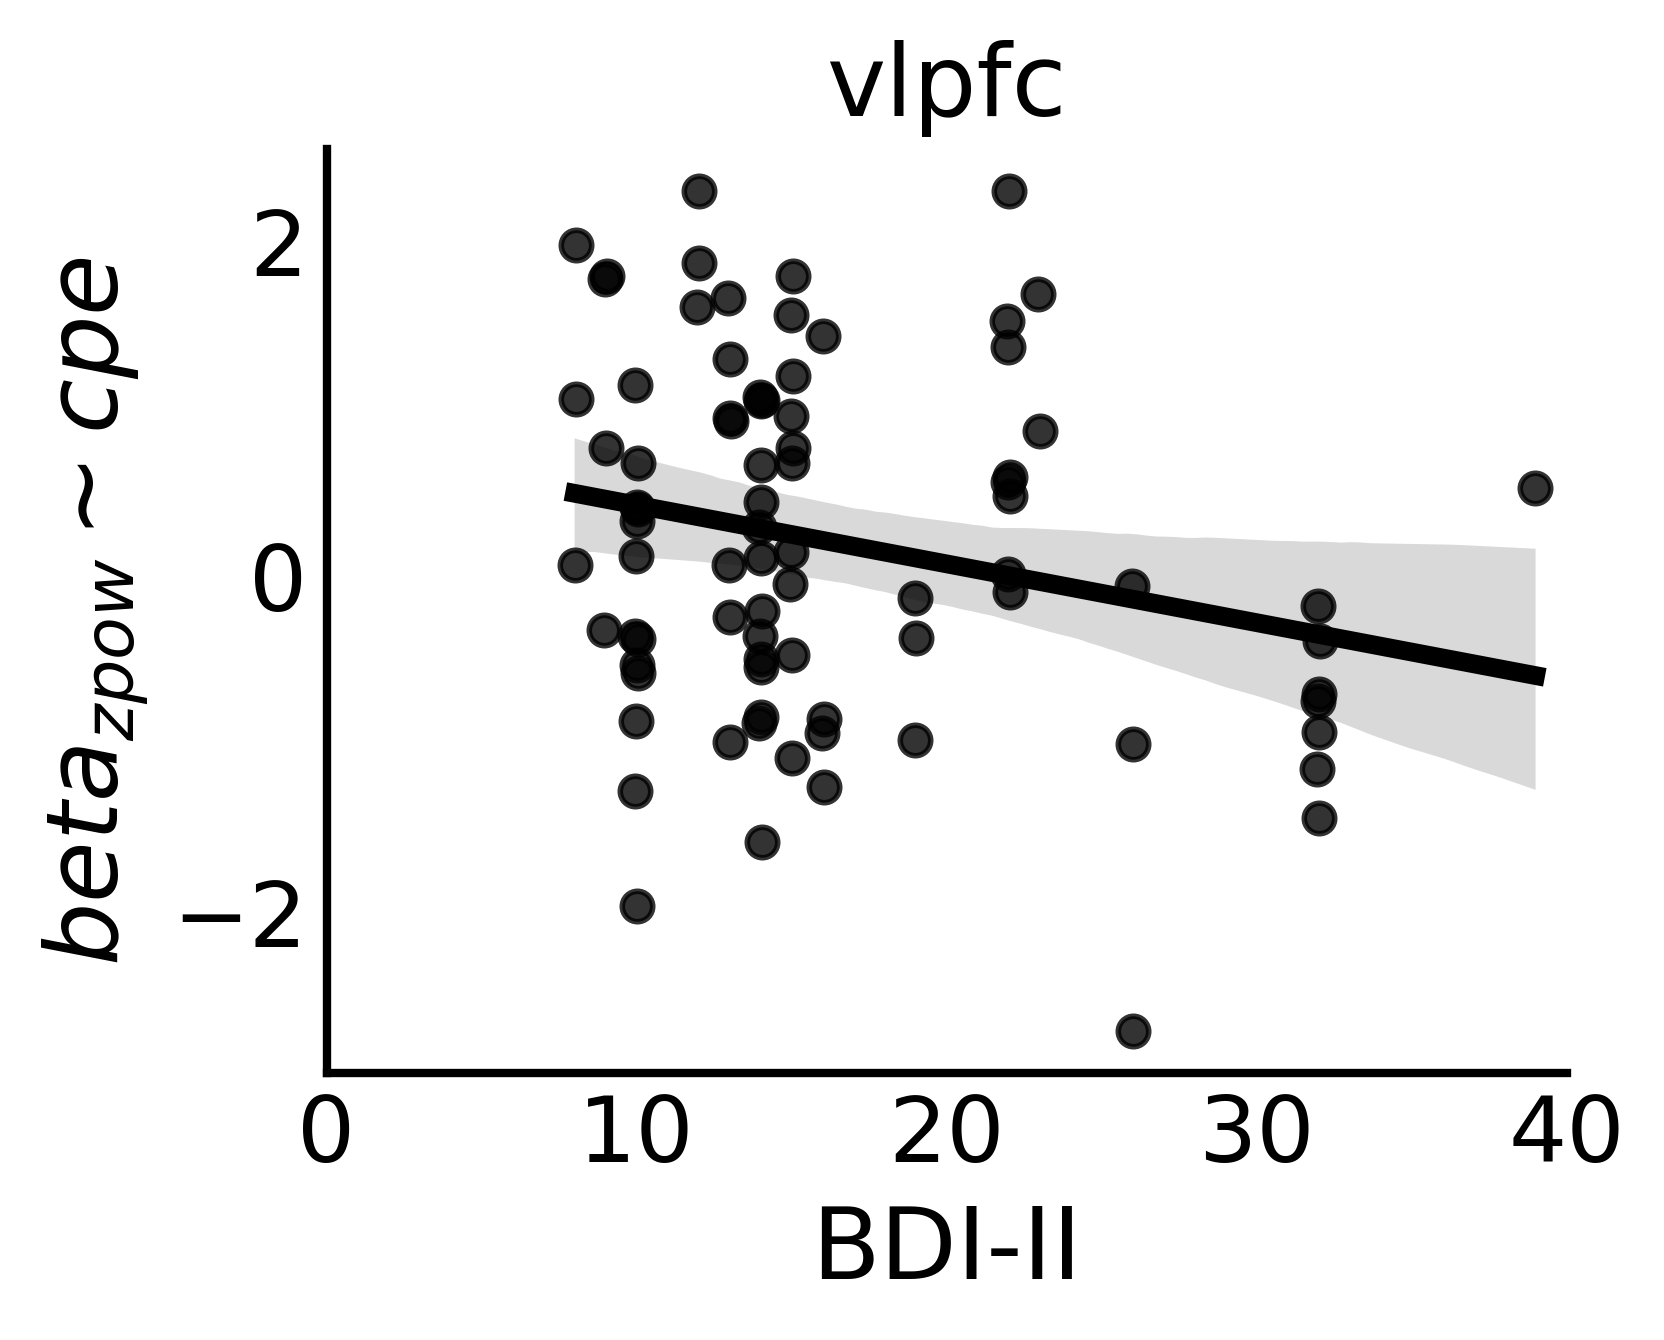

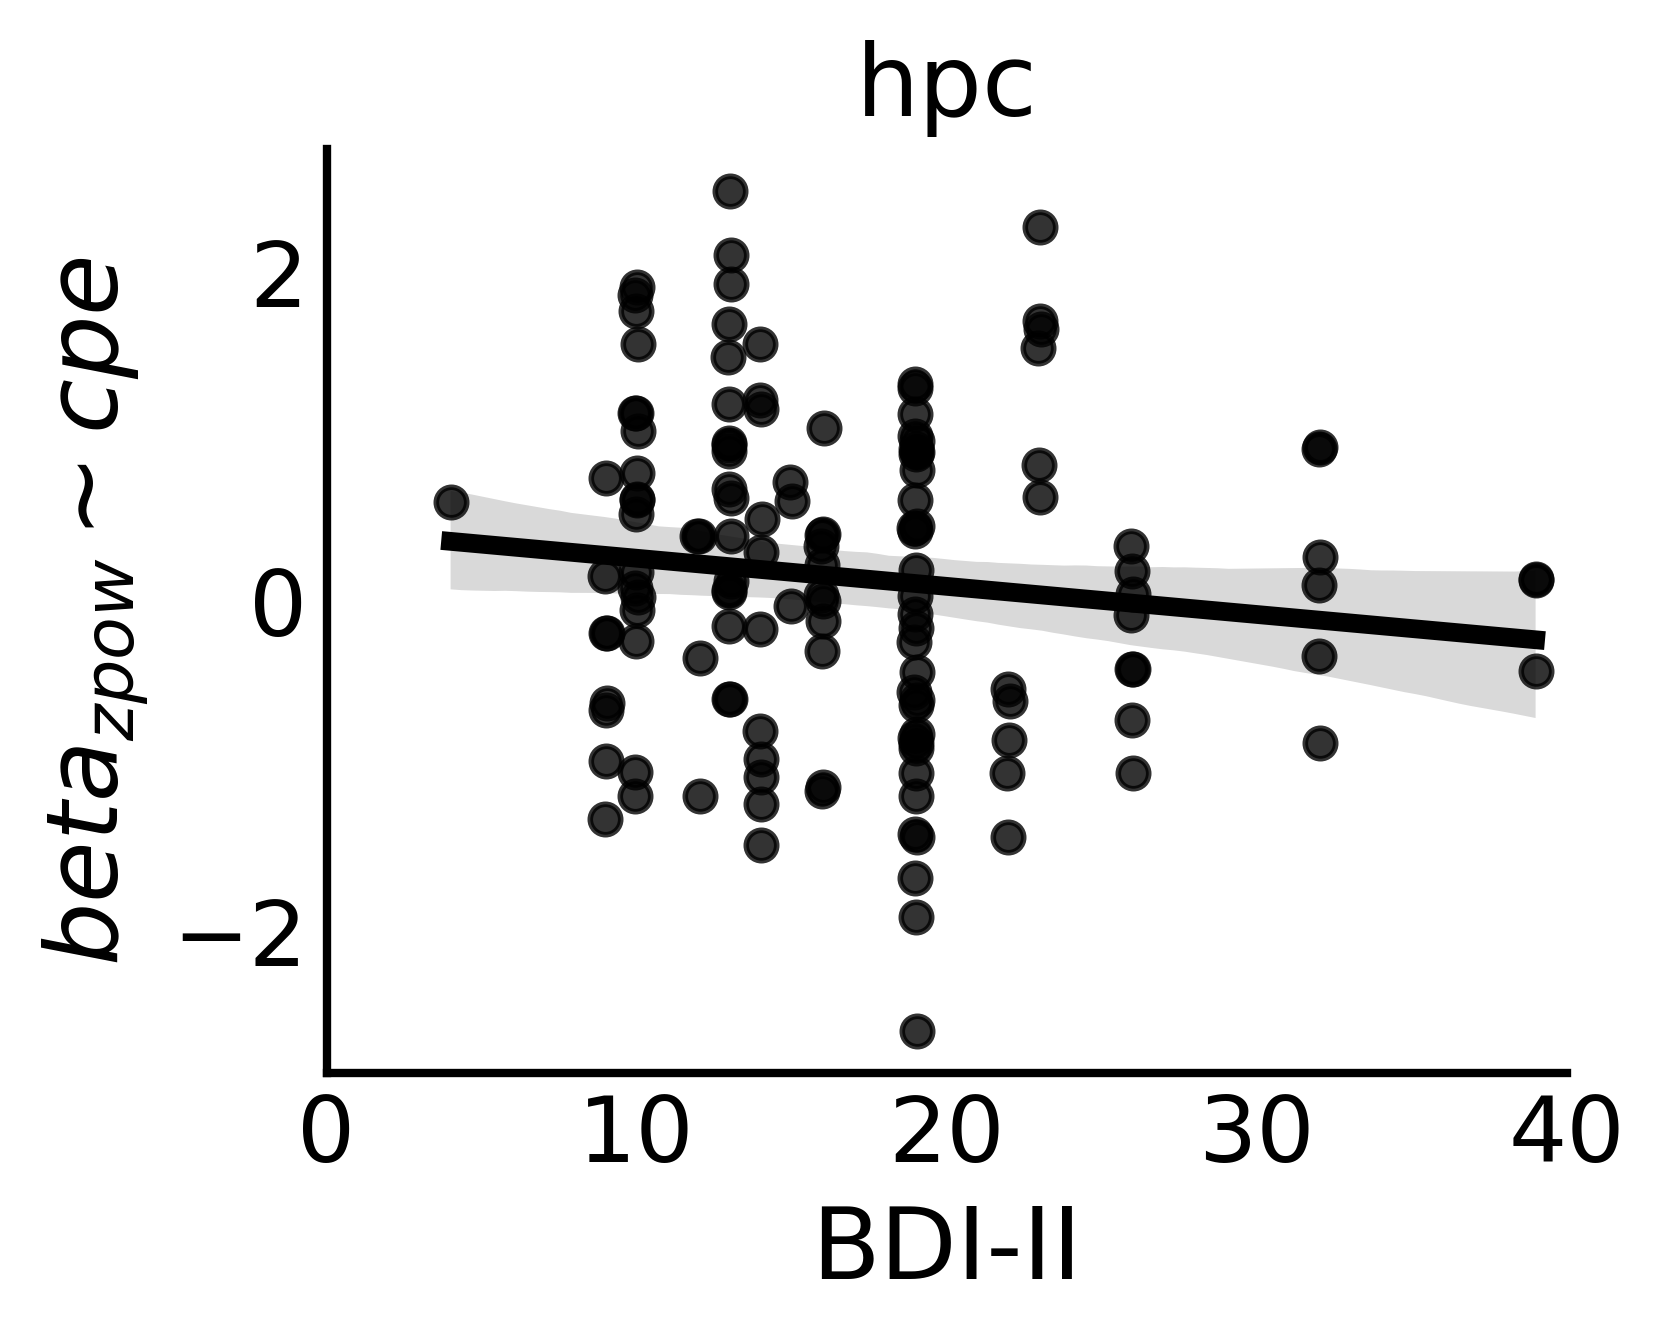

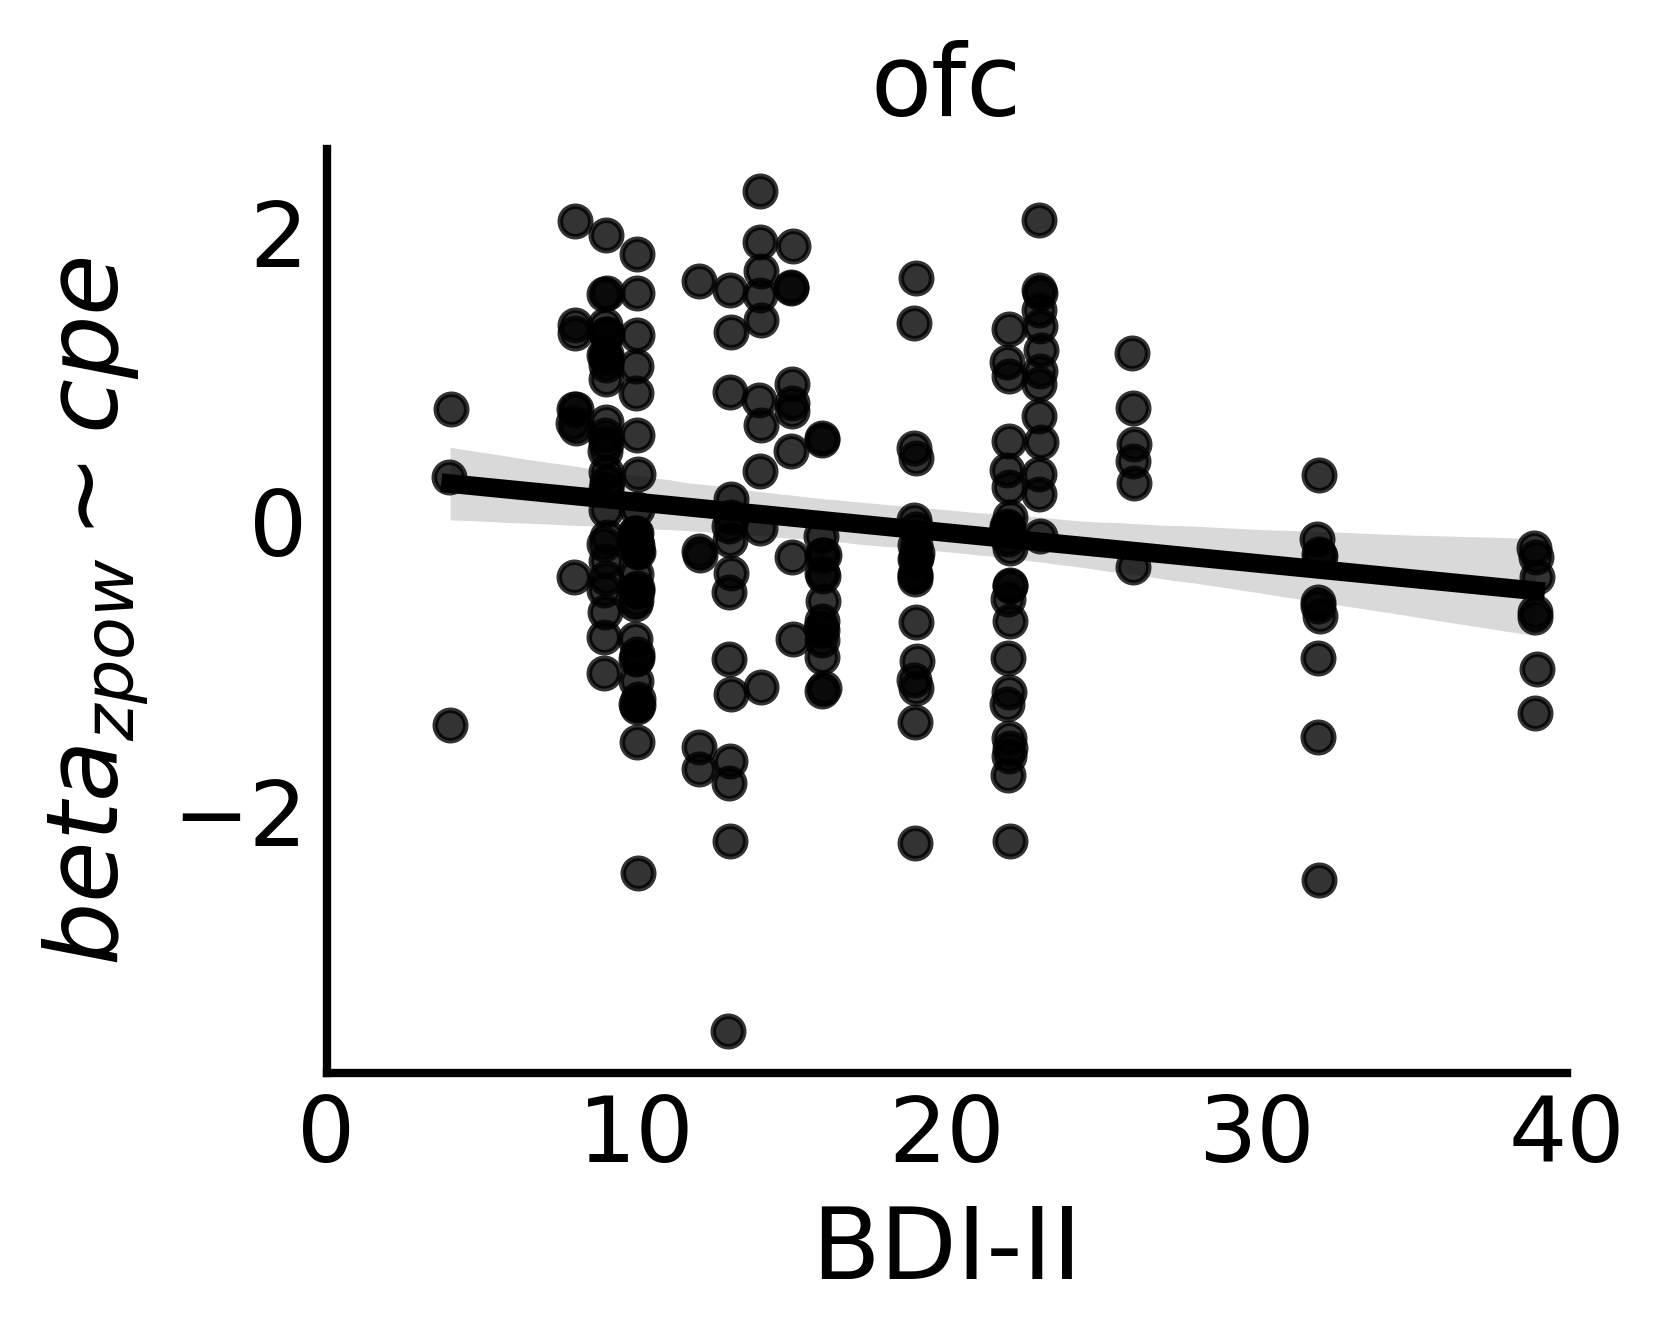

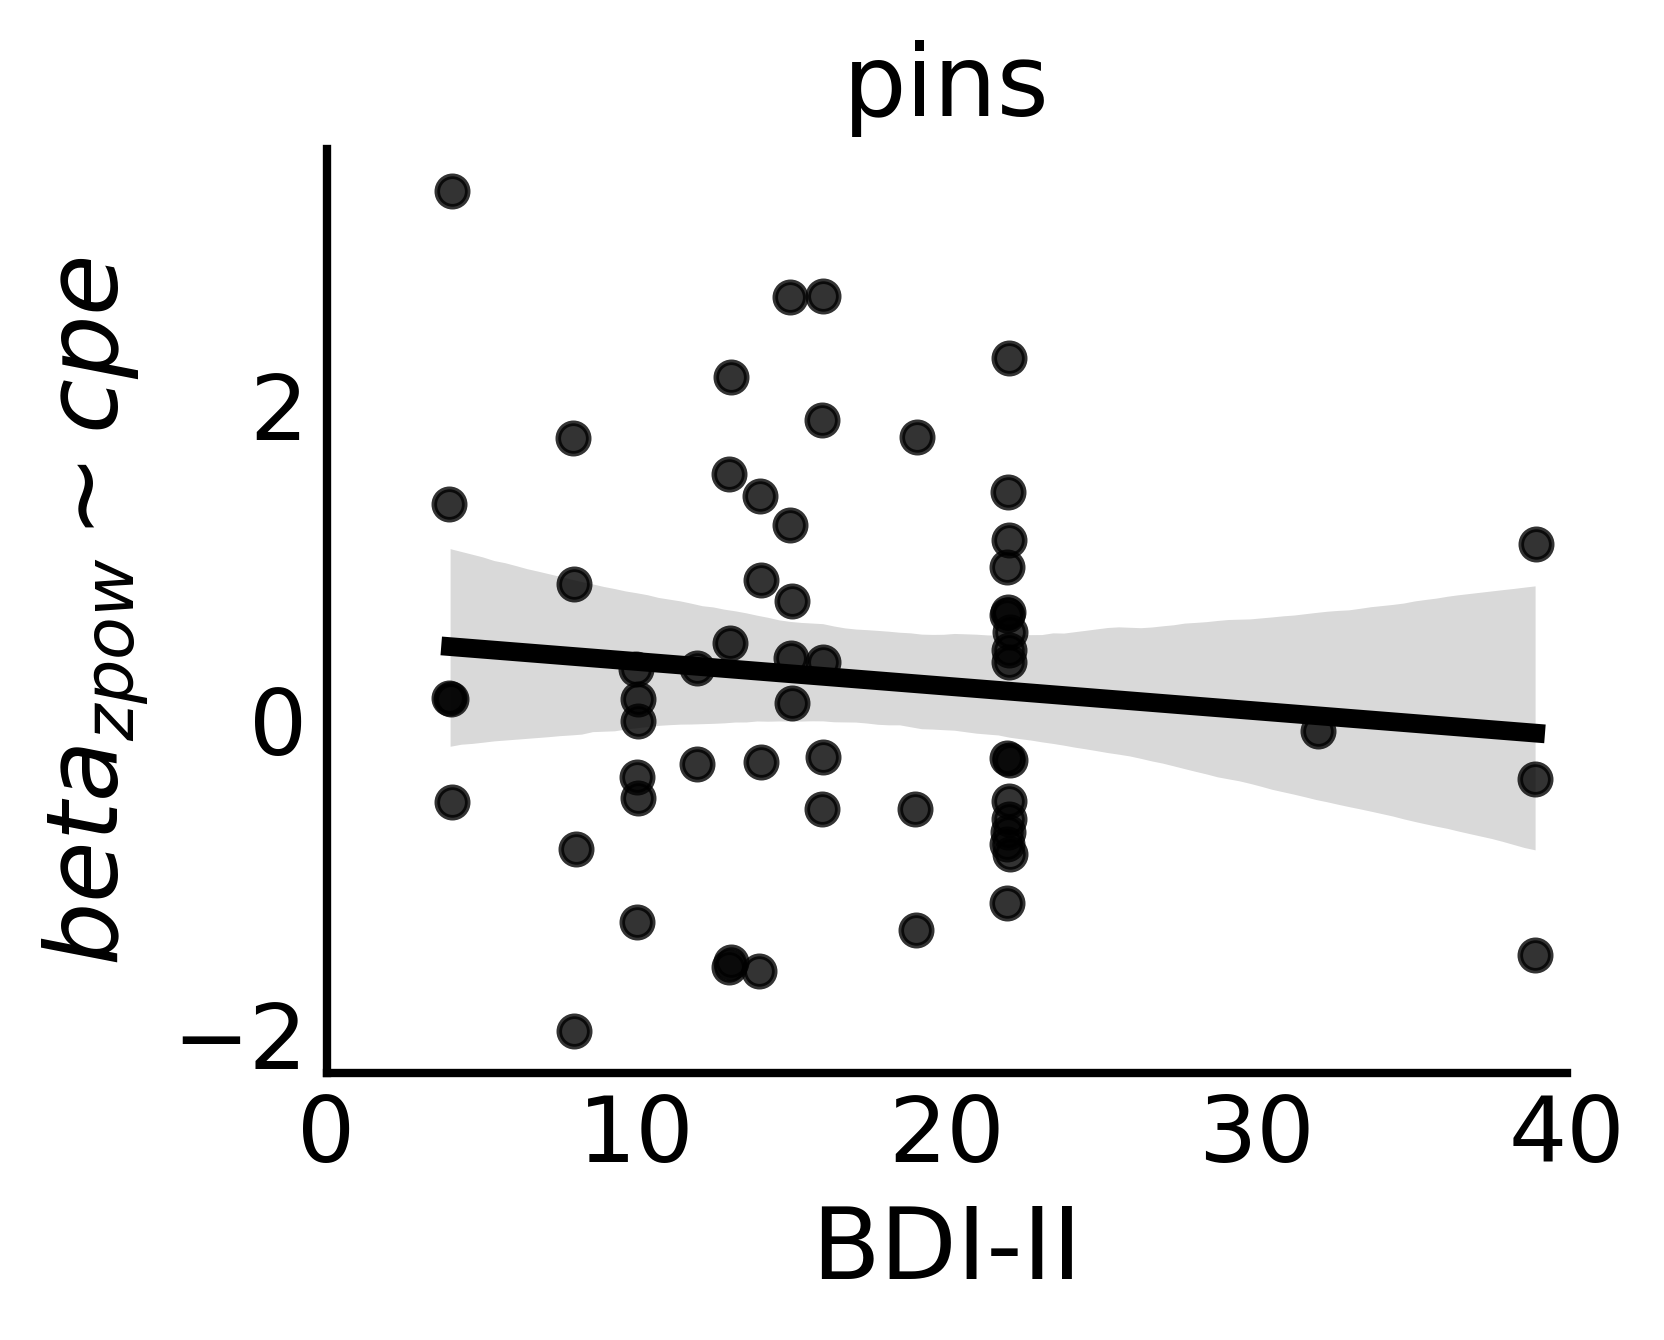

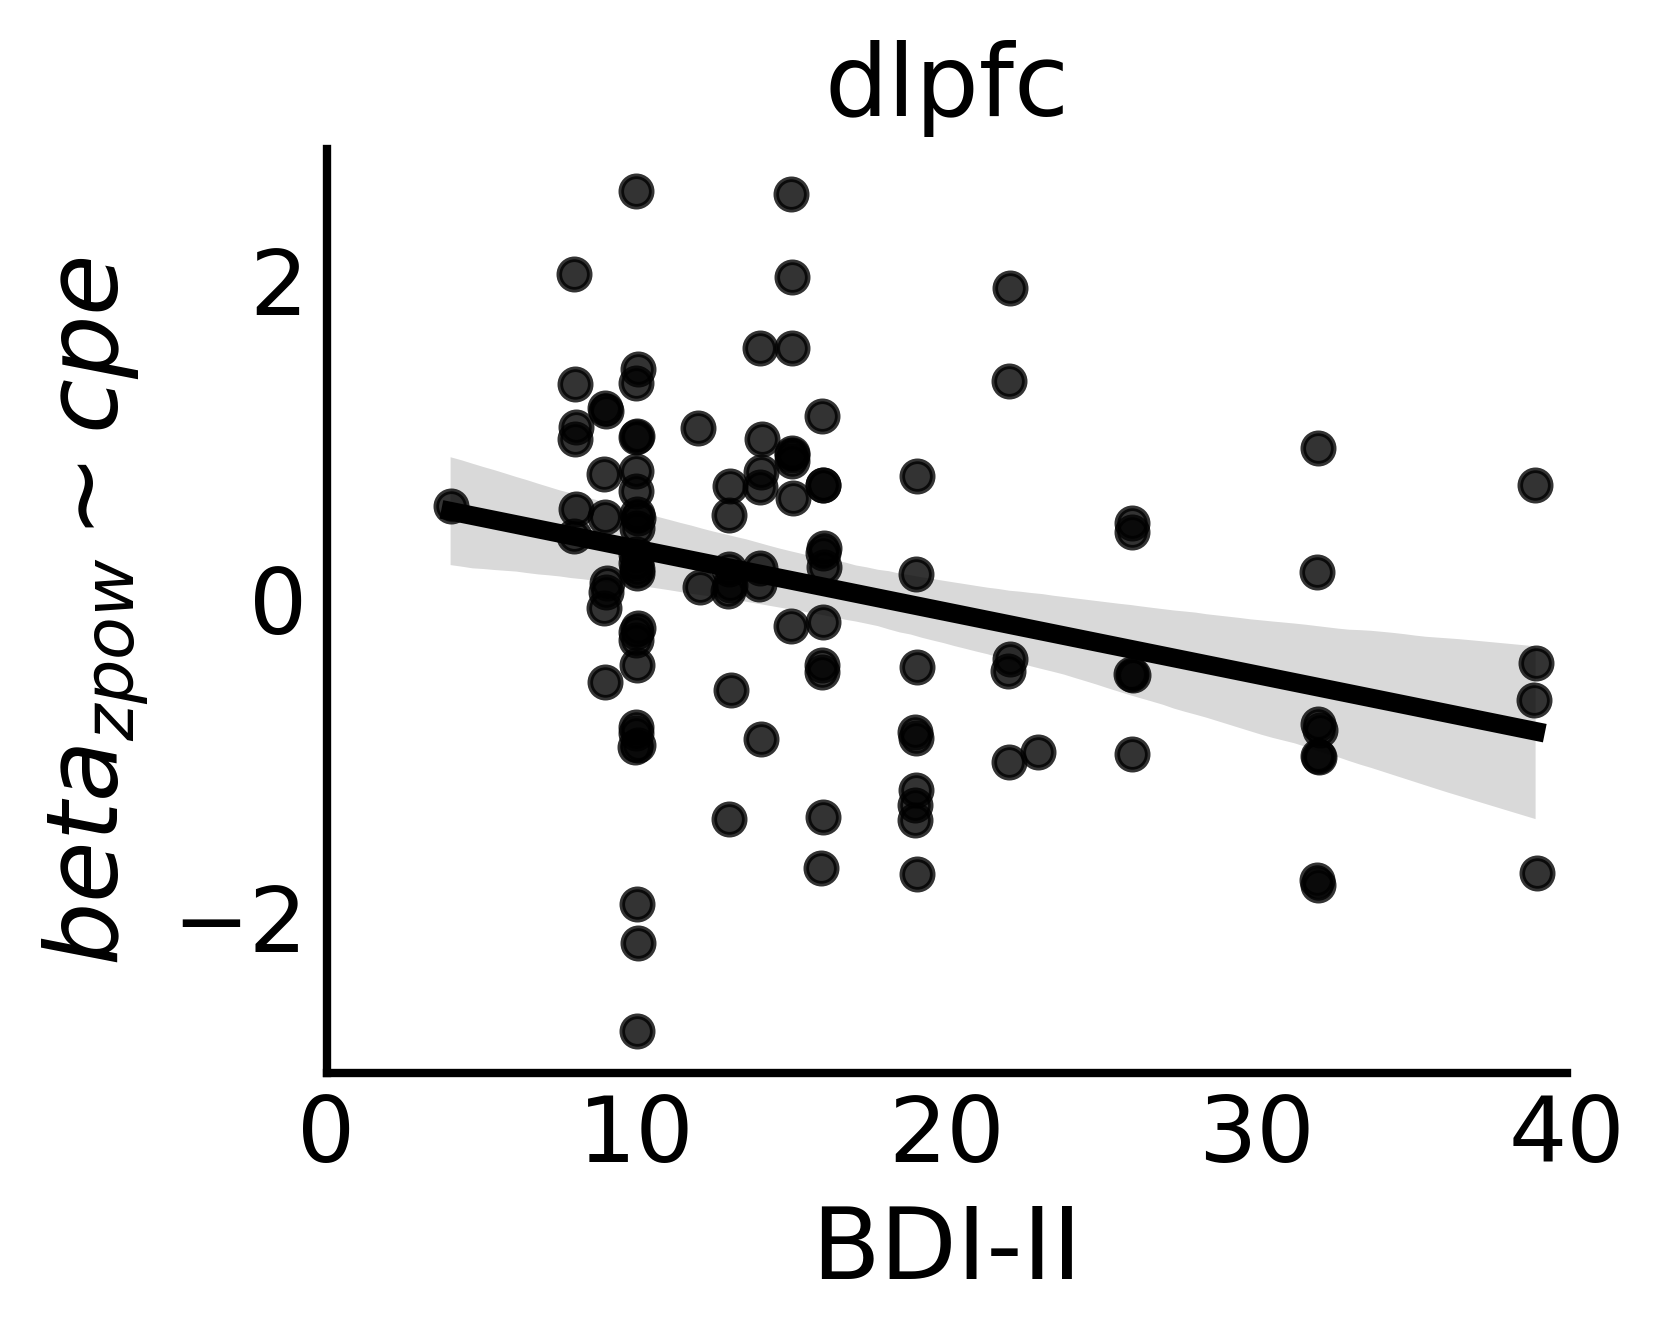

In [34]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in results.roi.unique().tolist():
    
    corr_fig_id = f'{band}_{roi}_bdi_combomodel_cpe_coeff_corr_{epoch_len}.pdf'
    
    roi_temp_data = results[results.roi==roi]
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=400)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_cpe',scatter=True,ci=95,
                fit_reg=True,color = 'k',x_jitter = 0.05,scatter_kws={'s':30}) #034975
    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
    plt.ylabel(fr'${band}_{{zpow}} \sim cpe$')


    plt.title(f'{roi}')
    sns.despine()

    plt.savefig(f'{fig_save_path}{corr_fig_id}', format=corr_fig_id.split('.')[-1], metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=400,
        facecolor='auto', edgecolor='auto',
        backend=None)
    


### Test BDI Correlations via robust regression

In [35]:
### robust regression bdi ~ cpe coefficients
roi_rlm_dict = {}

for roi in results.roi.unique().tolist():
    roi_df = results[results.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_cpe.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())


acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 30 Sep 2024                                         
Time:                        20:17:25                                         
No. Iterations:                    10                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.9402      0.450     35.389     

In [44]:
del cpe_var

# RPE Coefficients

In [45]:
sig_data = results[results.P_Value_rpe < 0.05]
sig_data



unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
1     MS002_lacas2-lacas3   MS002    acc   14                     0.062795   
11    MS002_lagit3-lagit4   MS002    amy   14                     0.061949   
46      MS002_lsif3-lsif4   MS002  vlpfc   14                    -0.130569   
61    MS002_raims6-raims7   MS002  vlpfc   14                     0.260481   
73    MS002_rmoif6-rmoif7   MS002    ofc   14                     0.219183   
...                   ...     ...    ...  ...                          ...   
1098  MS050_rmcms6-rmcms7   MS050  dmpfc    9                     0.004913   
1137      DA026_lhh2-lhh3   DA026    hpc   19                    -0.008629   
1161  DA039_rains5-rains6   DA039   ains   22                     0.121571   
1179      DA039_rof8-rof9   DA039  dlpfc   22                     0.060652   
1182    DA039_rof11-rof12   DA039  dlpfc   22                    -0.003063   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
1                                  -0.086248                   0.217292   
11                                 -0.056533                   0.193409   
46                                 -0.038142                  -0.169123   
61                                 -0.306720                   0.149706   
73                                 -0.270061                   0.300430   
...                                      ...                        ...   
1098                                0.114340                   0.611238   
1137                               -0.026916                  -0.252714   
1161                               -0.158229                  -0.479407   
1179                               -0.113197                  -0.427546   
1182                               -0.064077                  -0.175905   

      Original_Estimate_Profit  Original_Estimate_rpe  Original_Estimate_cpe  \
1                    -0.279191               0.277946               0.002570   
11                   -0.288107               0.217412               0.013225   
46                    0.248182              -0.201661              -0.022574   
61                   -0.352442               0.338863               0.065643   
73                   -0.437670               0.380549               0.094534   
...                        ...                    ...                    ...   
1098                 -0.878495               0.609675               0.072884   
1137                  0.287929              -0.272348              -0.043512   
1161                  0.823704              -0.555490              -0.099126   
1179                  0.716675              -0.458414              -0.025959   
1182                  0.345200              -0.220816              -0.010370   

      ...  Z_Score_cpe  P_Value_Intercept  P_Value_GambleChoice[T.safe]  \
1     ...     0.048851       3.847808e-02                  3.784027e-02   
11    ...     0.330659       1.229688e-01                  1.228451e-01   
46    ...    -0.833975       9.141881e-02                  9.033881e-02   
61    ...     1.057029       1.463333e-08                  1.537760e-08   
73    ...     1.394230       1.008225e-06                  1.032678e-06   
...   ...          ...                ...                           ...   
1098  ...     0.970340       3.870754e-02                  4.678481e-02   
1137  ...    -0.886842       5.523119e-01                  4.939717e-01   
1161  ...    -1.182107       1.082350e-02                  1.375647e-02   
1179  ...    -0.454380       8.163104e-03                  1.229756e-02   
1182  ...    -0.374754       1.071128e-02                  8.020222e-03   

      P_Value_TrialEV  P_Value_Profit  P_Value_rpe  P_Value_cpe  cpe_sig  \
1            0.143297        0.156983     0.033642     0.961038        0   
11           0.123164        0.081365     0.049198     0.740902        0   
46           0.027358        0.015056     0.002351     0.404295        0   
61     

In [46]:
sig_data.roi.value_counts()



roi
dmpfc    16
acc      14
hpc      10
amy       8
ains      7
dlpfc     5
vlpfc     4
ofc       3
pins      1
Name: count, dtype: int64

In [47]:
sig_data.roi.unique()



array(['acc', 'amy', 'vlpfc', 'ofc', 'dmpfc', 'ains', 'pins', 'hpc',
       'dlpfc'], dtype=object)

### ROI Significance Testing
- % of sig elecs in ROI (also split by BDI)
- binomial test for whether sig proportion of elecs in ROI 
- ttests from zero 


In [48]:
# add mask col for sig cpe elecs 
results['rpe_sig']   = results['P_Value_rpe'].apply(lambda x: 0 if x > 0.05 else 1)
results['bdi_split'] = results['bdi'].apply(lambda x: 0 if x < 20 else 1)

results.head()

# results.to_csv(f'{save_path}{band}_perm_regression_results_df_{epoch_len}.csv')

unique_elec_id subj_id  roi  bdi  Original_Estimate_Intercept  \
0  MS002_lacas1-lacas2   MS002  acc   14                     0.062638   
1  MS002_lacas2-lacas3   MS002  acc   14                     0.062795   
2  MS002_lacas3-lacas4   MS002  acc   14                     0.047164   
3  MS002_lacas4-lacas5   MS002  acc   14                     0.008430   
4  MS002_lacas5-lacas6   MS002  acc   14                     0.041894   

   Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                               -0.123822                  -0.021673   
1                               -0.086248                   0.217292   
2                               -0.081376                   0.146646   
3                               -0.021970                   0.326099   
4                               -0.046182                   0.199258   

   Original_Estimate_Profit  Original_Estimate_rpe  Original_Estimate_cpe  \
0                  0.084899               0.008475               0.013529   
1                 -0.279191               0.277946               0.002570   
2                 -0.164104               0.172035               0.064983   
3                 -0.357296               0.166529               0.112233   
4                 -0.286195               0.183201               0.058915   

   ...  Z_Score_cpe  P_Value_Intercept  P_Value_GambleChoice[T.safe]  \
0  ...     0.241424           0.004627                      0.004545   
1  ...     0.048851           0.038478                      0.037840   
2  ...     1.418636           0.035191                      0.035509   
3  ...     2.241178           0.587085                      0.591145   
4  ...     1.217036           0.277605                      0.280328   

   P_Value_TrialEV  P_Value_Profit  P_Value_rpe  P_Value_cpe  cpe_sig  \
0         0.938500        0.716878     0.898156     0.809226        0   
1         0.143297        0.156983     0.033642     0.961038        0   
2         0.270250        0.357693     0.143398     0.156005        0   
3         0.019644        0.050758     0.161198     0.025015        1   
4         0.170207        0.140250     0.154092     0.223590        0   

   bdi_split  rpe_sig  
0          0        0  
1          0        1  
2          0        0  
3          0        0  
4          0        0  

[5 rows x 37 columns]

In [49]:
rpe_var = 'Z_Score_rpe'

In [50]:
# bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']
bar_order = keep_rois.copy()


In [51]:
results.groupby('roi').agg('mean',numeric_only=True)[rpe_var][bar_order]



roi
dlpfc   -0.047960
vlpfc    0.043093
dmpfc    0.159990
ofc      0.094289
ains     0.281885
pins    -0.154574
acc      0.047437
amy      0.127289
hpc     -0.070637
Name: Z_Score_rpe, dtype: float64

In [52]:
roi_sig_info = []

for roi in results.roi.unique().tolist():
    roi_results = results[results.roi==roi]
    # ttest from zero 
    ttest_stat,ttest_pval = ttest_1samp(roi_results[rpe_var],popmean=0)
    # binomial test for significance 
    n = len(roi_results)
    x = np.sum(roi_results.rpe_sig)
    binom_test = scipy.stats.binomtest(x, n, p=0.05, alternative='greater')
    binom_pval = binom_test.pvalue
    binom_prop = binom_test.statistic
    ci_low     = binom_test.proportion_ci(confidence_level=0.95).low
    ci_high    = binom_test.proportion_ci(confidence_level=0.95).high
    # agg results 
    roi_sig_info.append(pd.DataFrame({'roi':roi,'n_total':n,'n_sig':x,'prop_sig':np.divide(x,n),
                                      'n_sig_highbdi':np.sum(roi_results[roi_results.bdi_split==1].rpe_sig),
                                      'ttest_stat':ttest_stat,'ttest_pval':ttest_pval,
                                      'binom_ci_low':ci_low,'binom_ci_high':ci_high,
                                      'binom_prop':binom_prop,'binom_pval':np.round(binom_pval,4)},index=[0]))

roi_sig_info = pd.concat(roi_sig_info).reset_index(drop=True)

In [53]:
roi_sig_info

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat  ttest_pval  \
0    acc      193     14  0.072539              2    0.640653    0.522512   
1  dmpfc      225     16  0.071111              5    2.416365    0.016477   
2    amy      113      8  0.070796              1    1.202872    0.231562   
3   ains       71      7  0.098592              2    2.034326    0.045709   
4  vlpfc       82      4  0.048780              1    0.368521    0.713446   
5    hpc      135     10  0.074074              1   -0.739528    0.460880   
6    ofc      202      3  0.014851              0    1.570561    0.117858   
7   pins       60      1  0.016667              0   -1.374379    0.174522   
8  dlpfc      107      5  0.046729              2   -0.523736    0.601556   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
0      0.044384            1.0    0.072539      0.1058  
1      0.045110            1.0    0.071111      0.1009  
2      0.035713            1.0    0.070796      0.2049  
3      0.047193            1.0    0.098592      0.0642  
4      0.016832            1.0    0.048780      0.5912  
5      0.040736            1.0    0.074074      0.1396  
6      0.004060            1.0    0.014851      0.9979  
7      0.000855            1.0    0.016667      0.9539  
8      0.018591            1.0    0.046729      0.6243

In [54]:
sig_rois = roi_sig_info[roi_sig_info.binom_pval<0.05]
sig_rois

Empty DataFrame
Columns: [roi, n_total, n_sig, prop_sig, n_sig_highbdi, ttest_stat, ttest_pval, binom_ci_low, binom_ci_high, binom_prop, binom_pval]
Index: []

# Plot Results

In [55]:
fig_save_path = f'{fig_dir}{band}/'
os.makedirs(fig_save_path, exist_ok=True)

fig_id = f'{band}_perm_regression_combomodel_rpe_coeff_barplot_{epoch_len}.pdf'

ylabel = fr'${band}_{{zpow}} \sim RPE$'


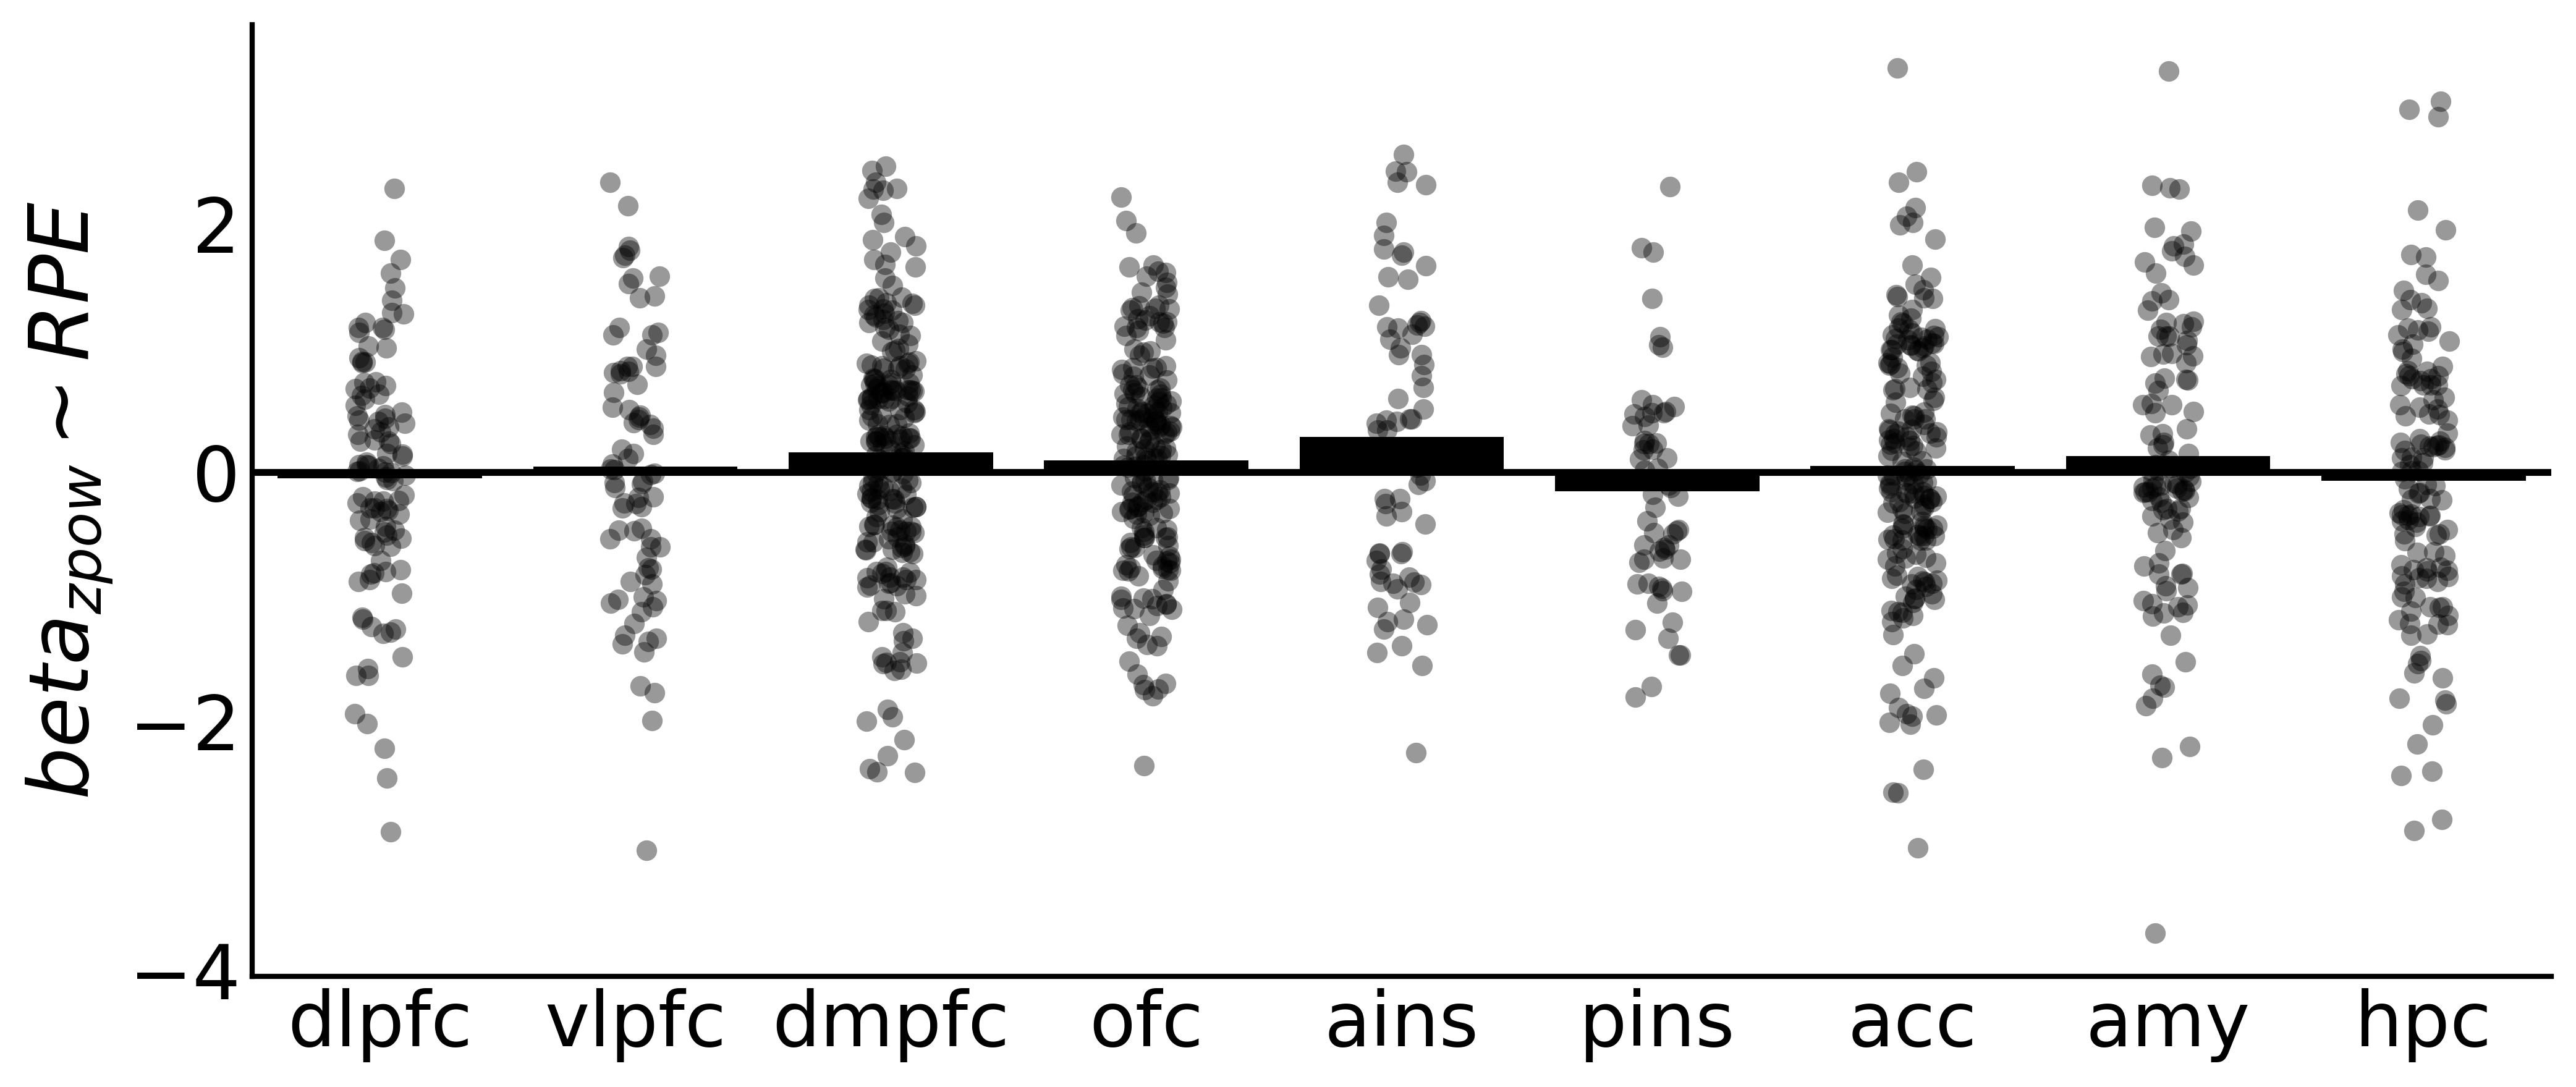

In [56]:
### WITHOUT RPE IN MODEL
plot_roi_model_results(results,'roi',rpe_var,bar_order=keep_rois,figsize=(12,5),color='k',
                       ylabel=ylabel,save_fig=True,save_dir=fig_save_path,fig_id=fig_id,dpi=400)



## BDI correlations

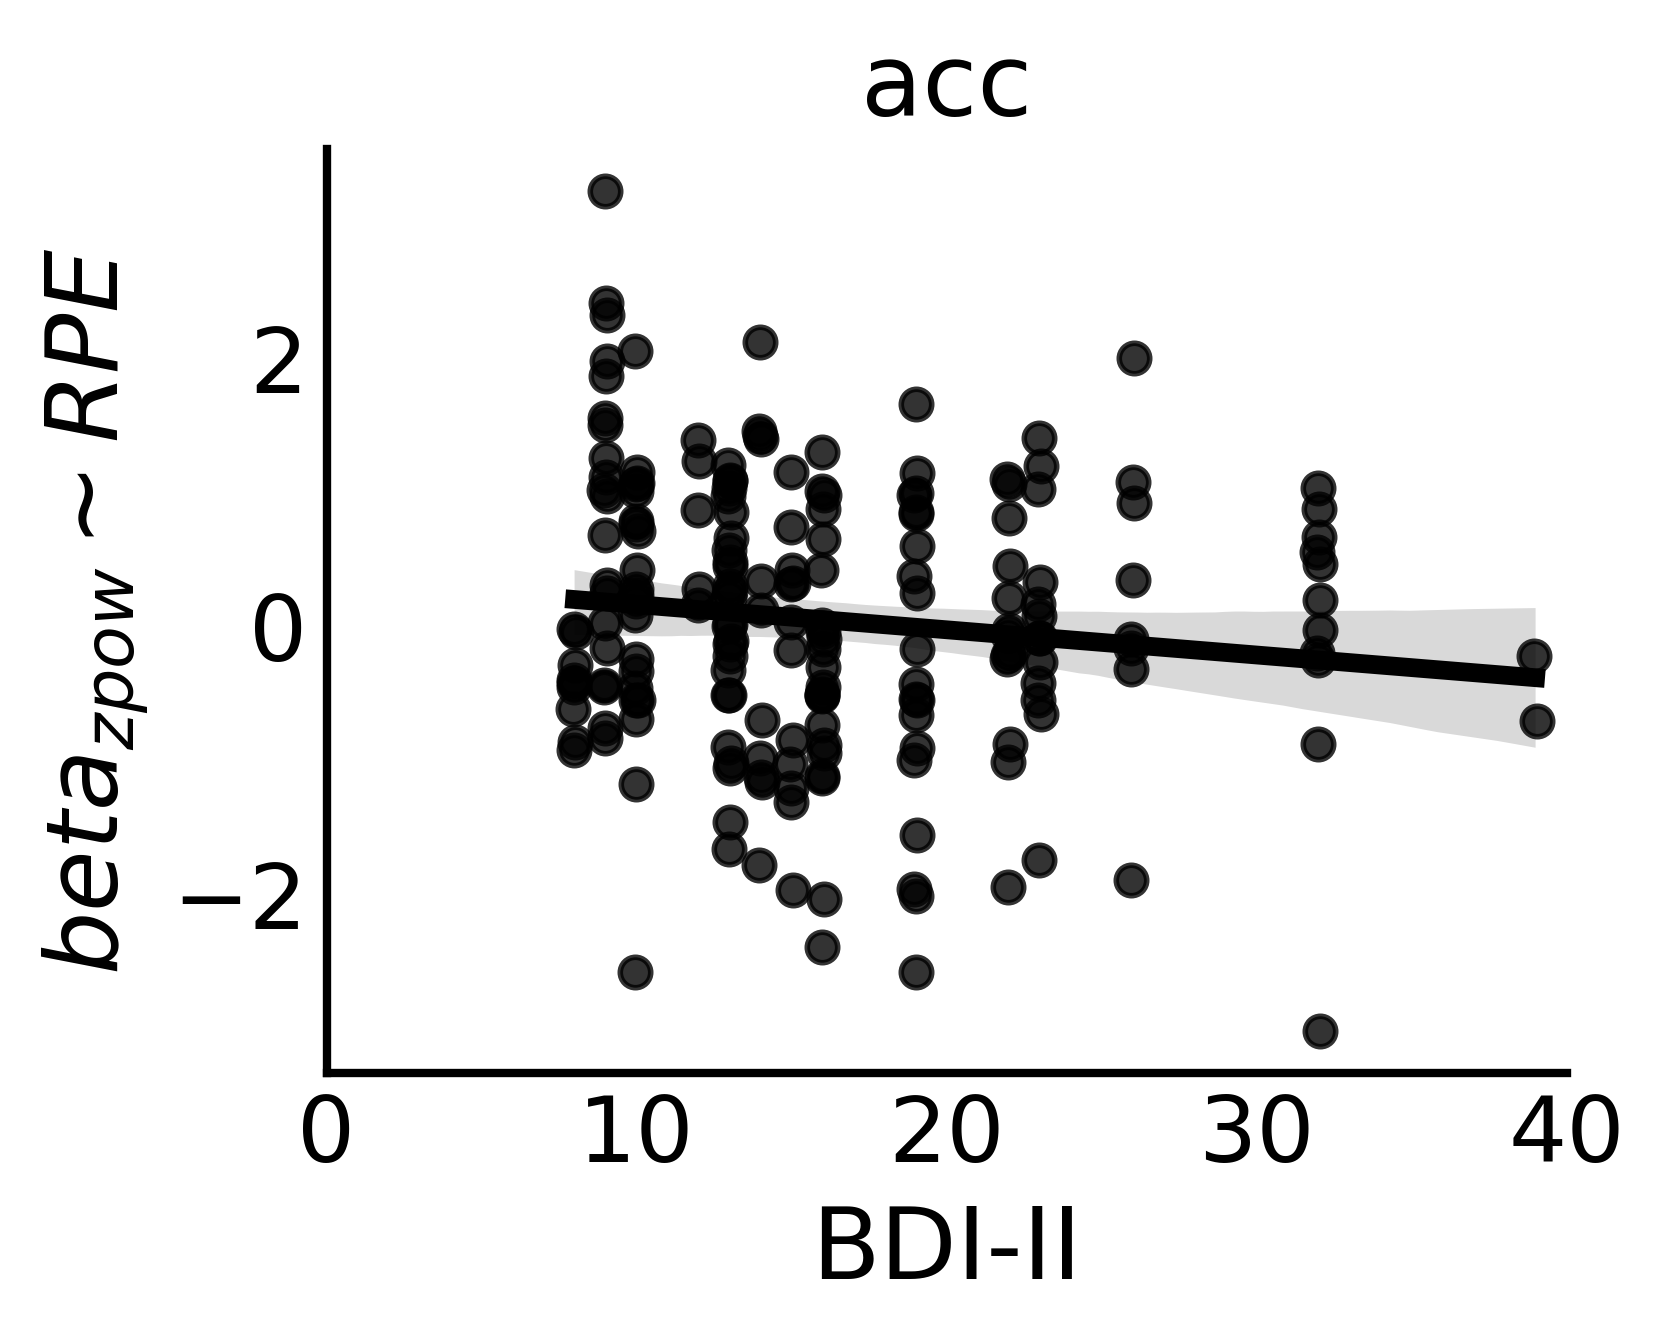

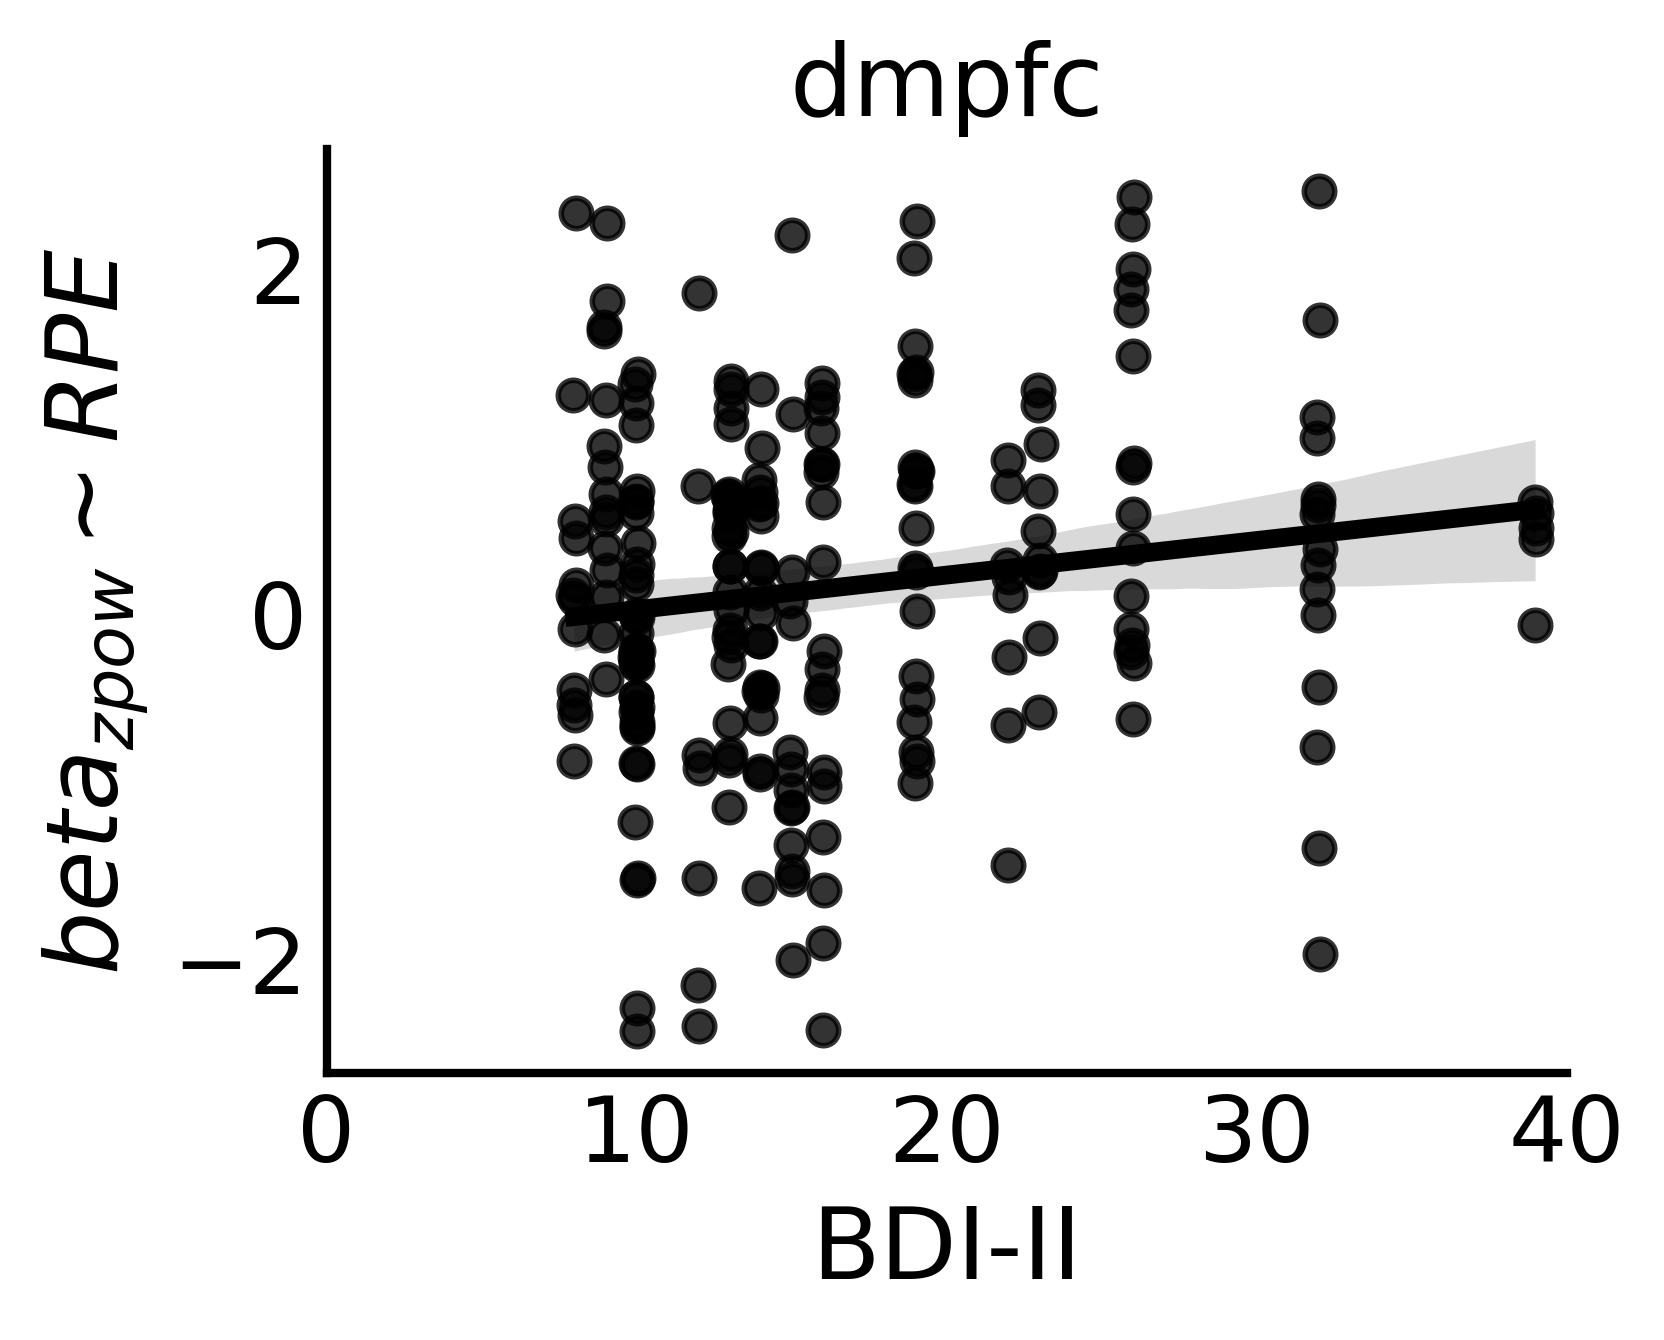

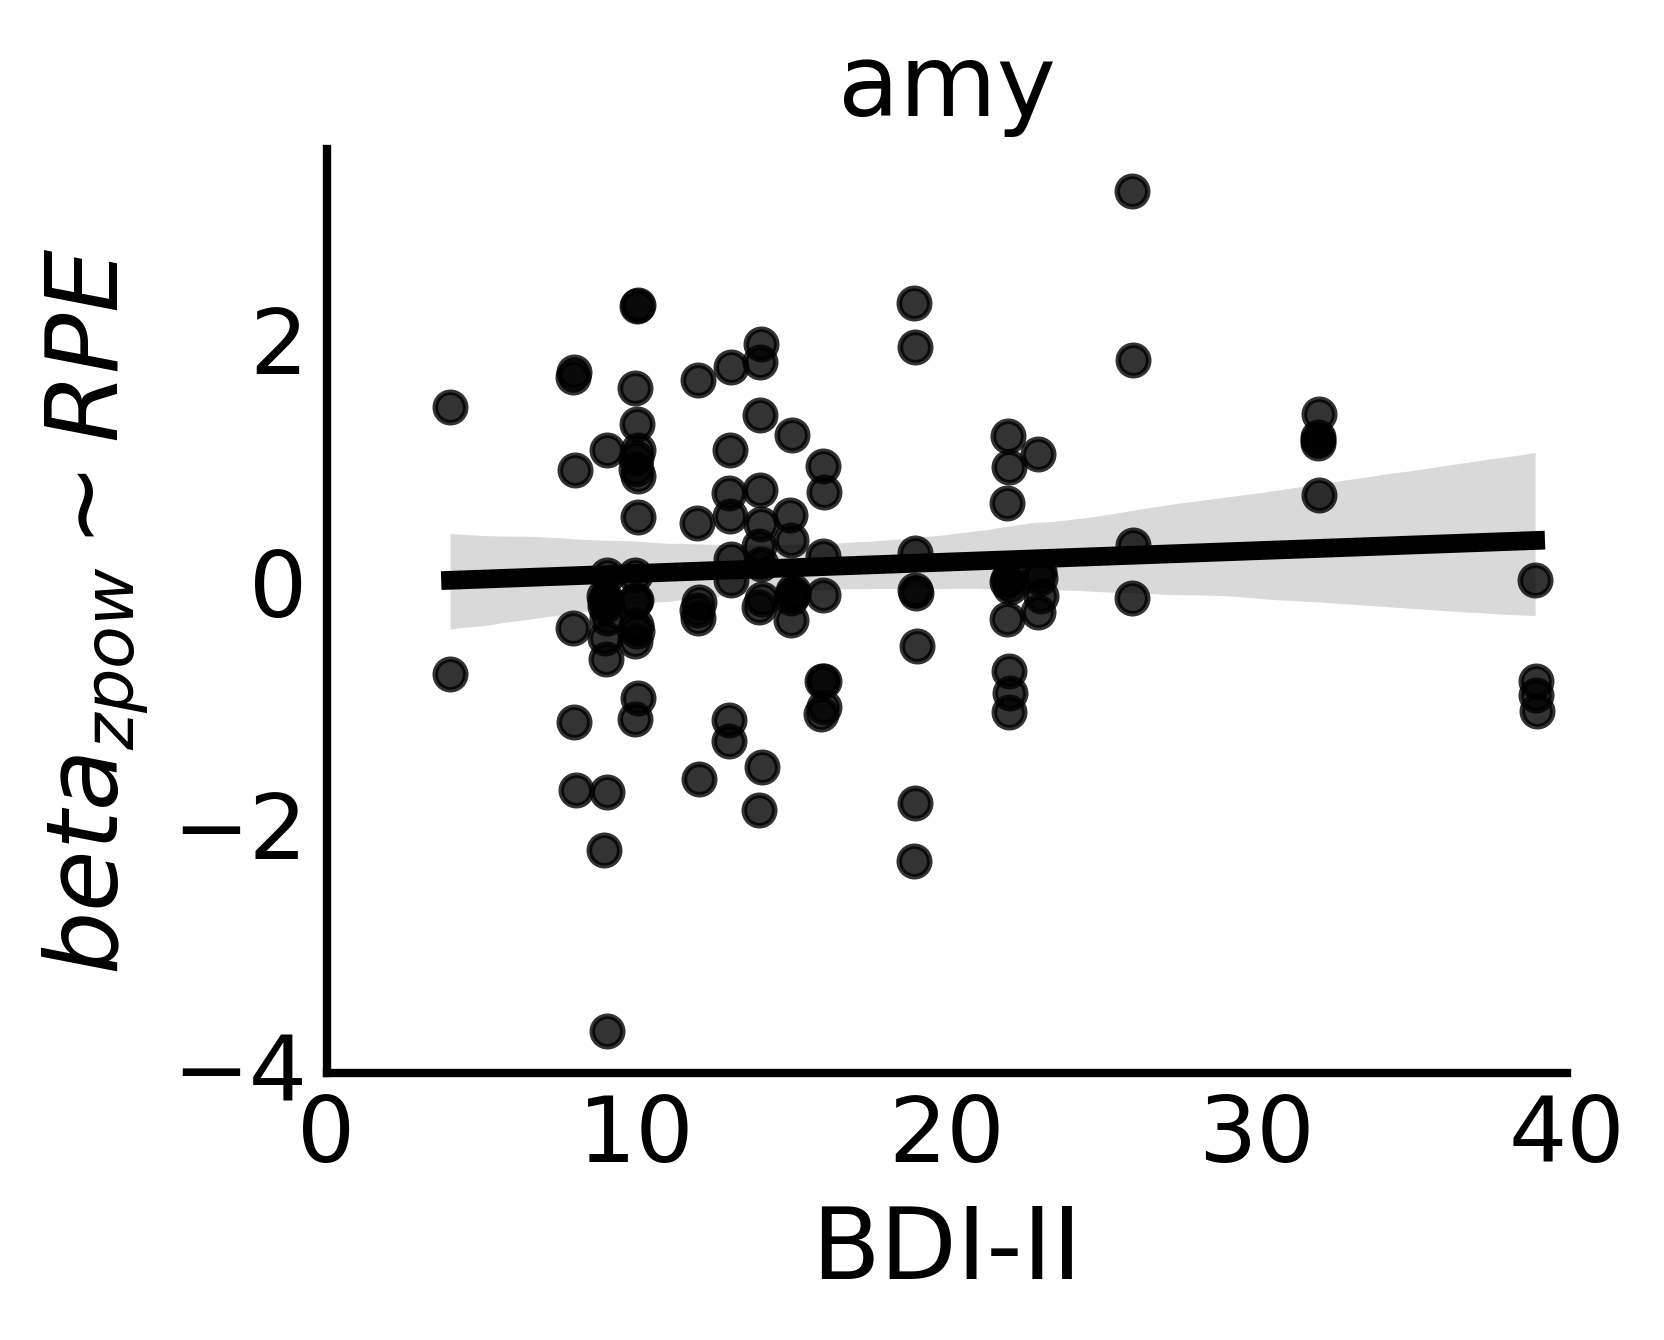

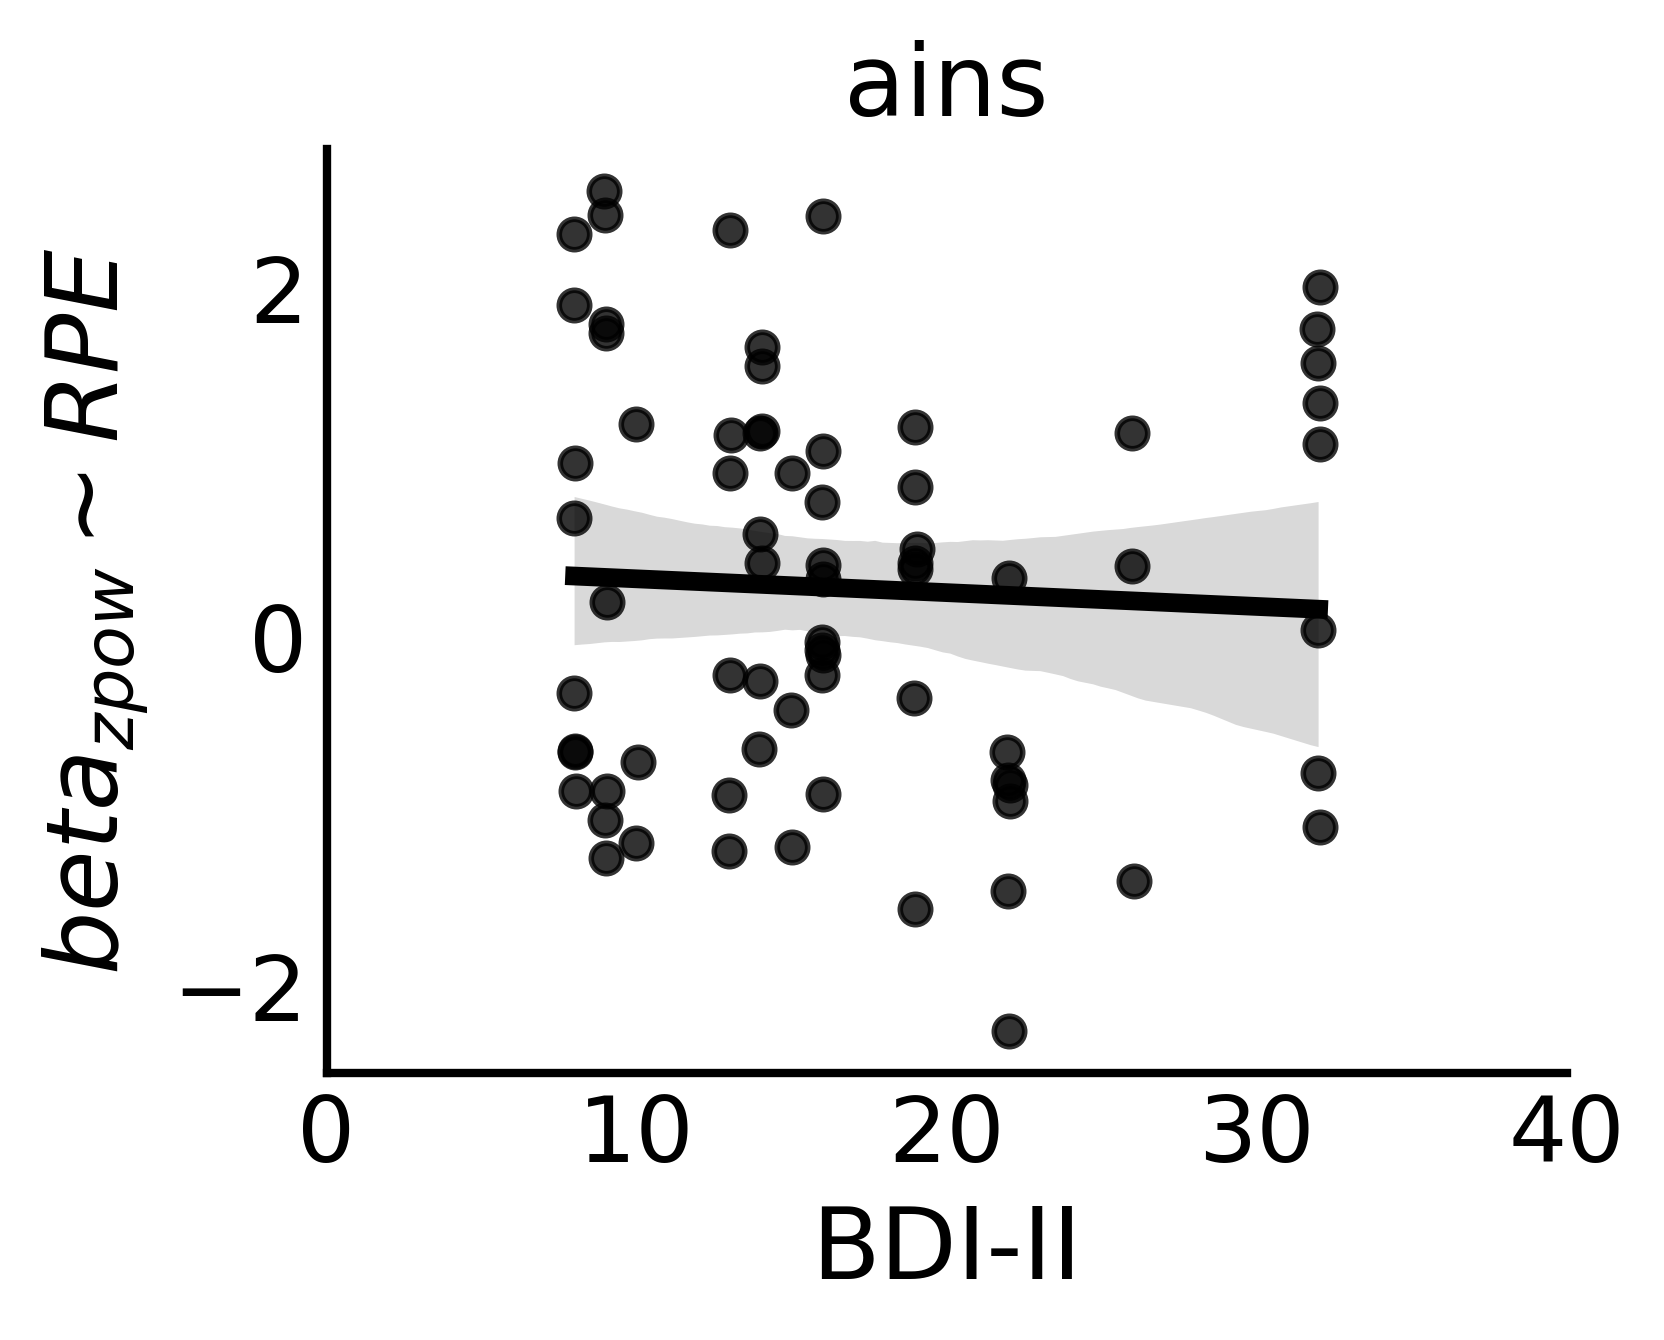

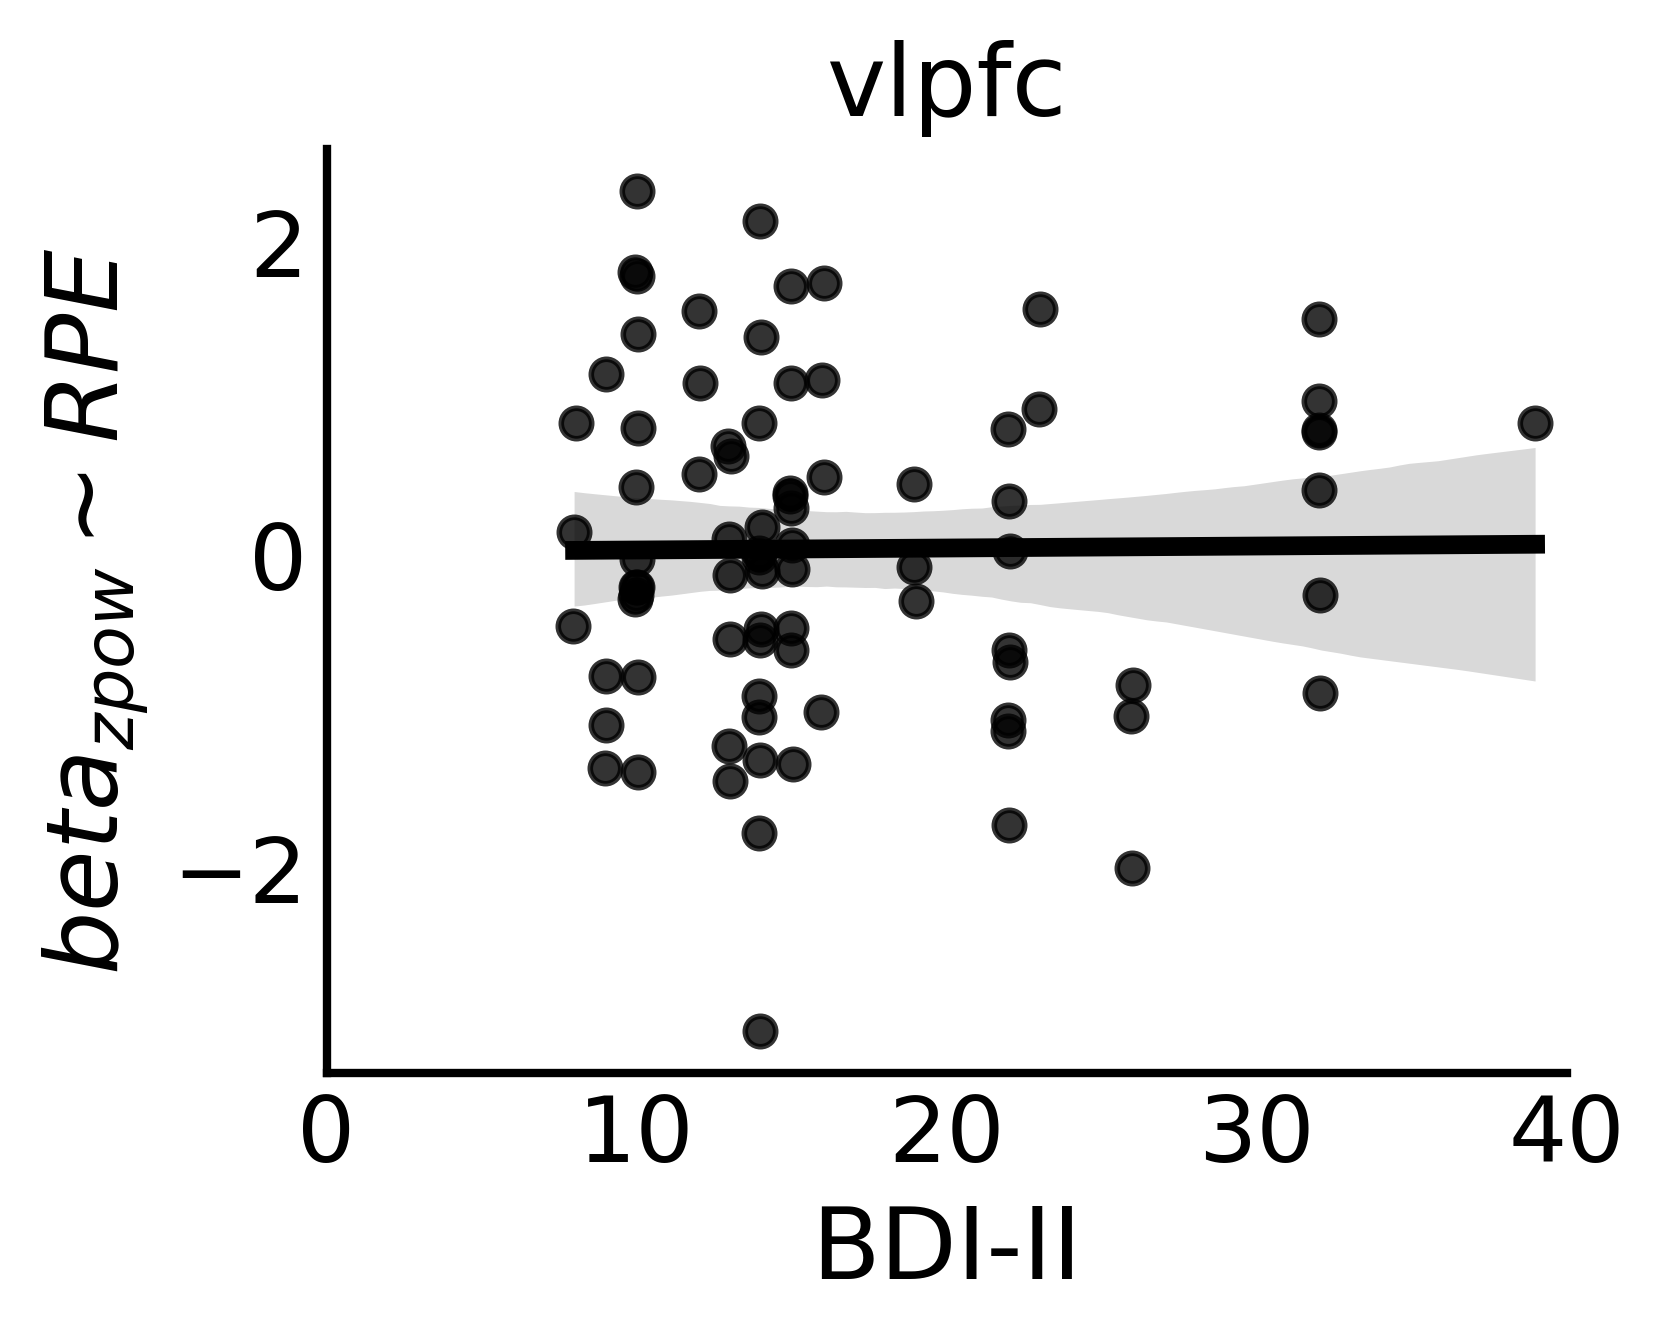

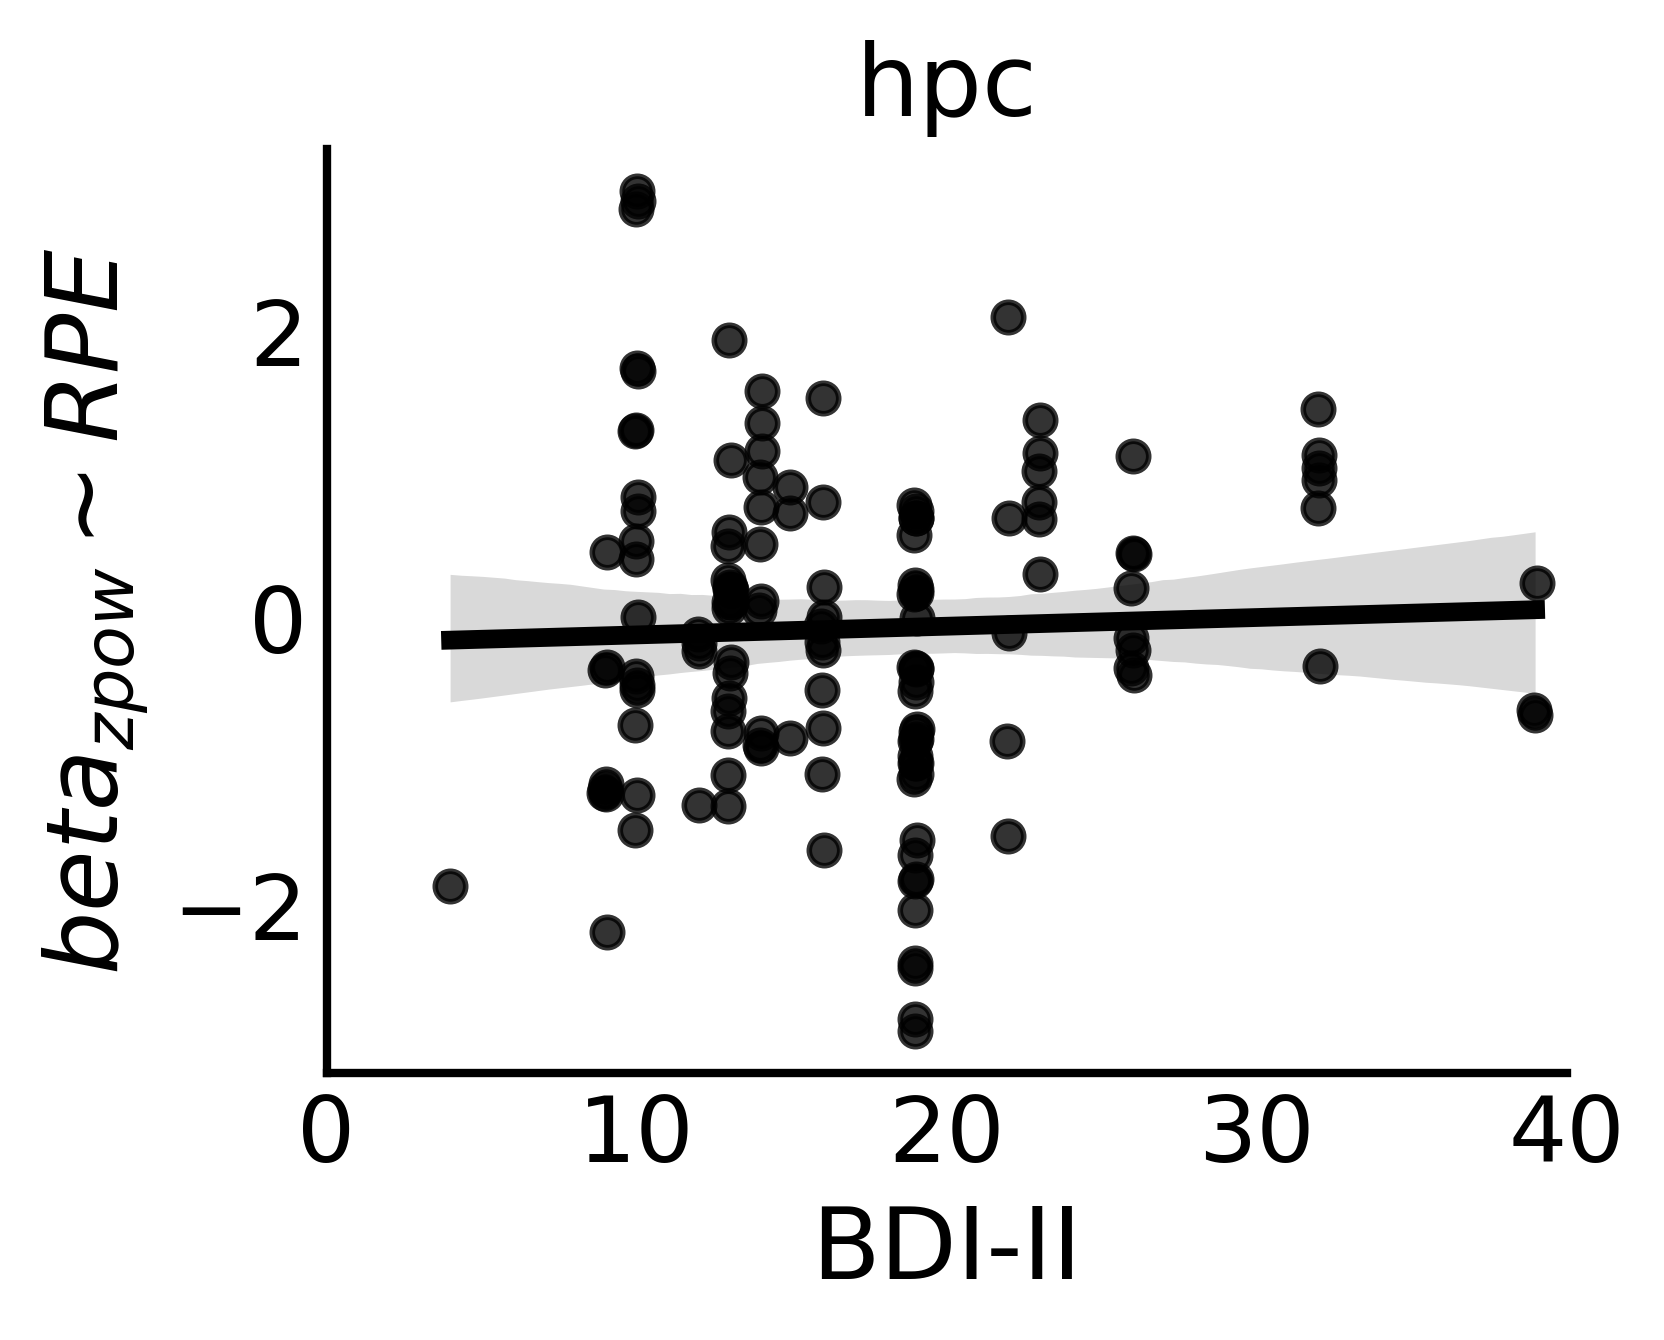

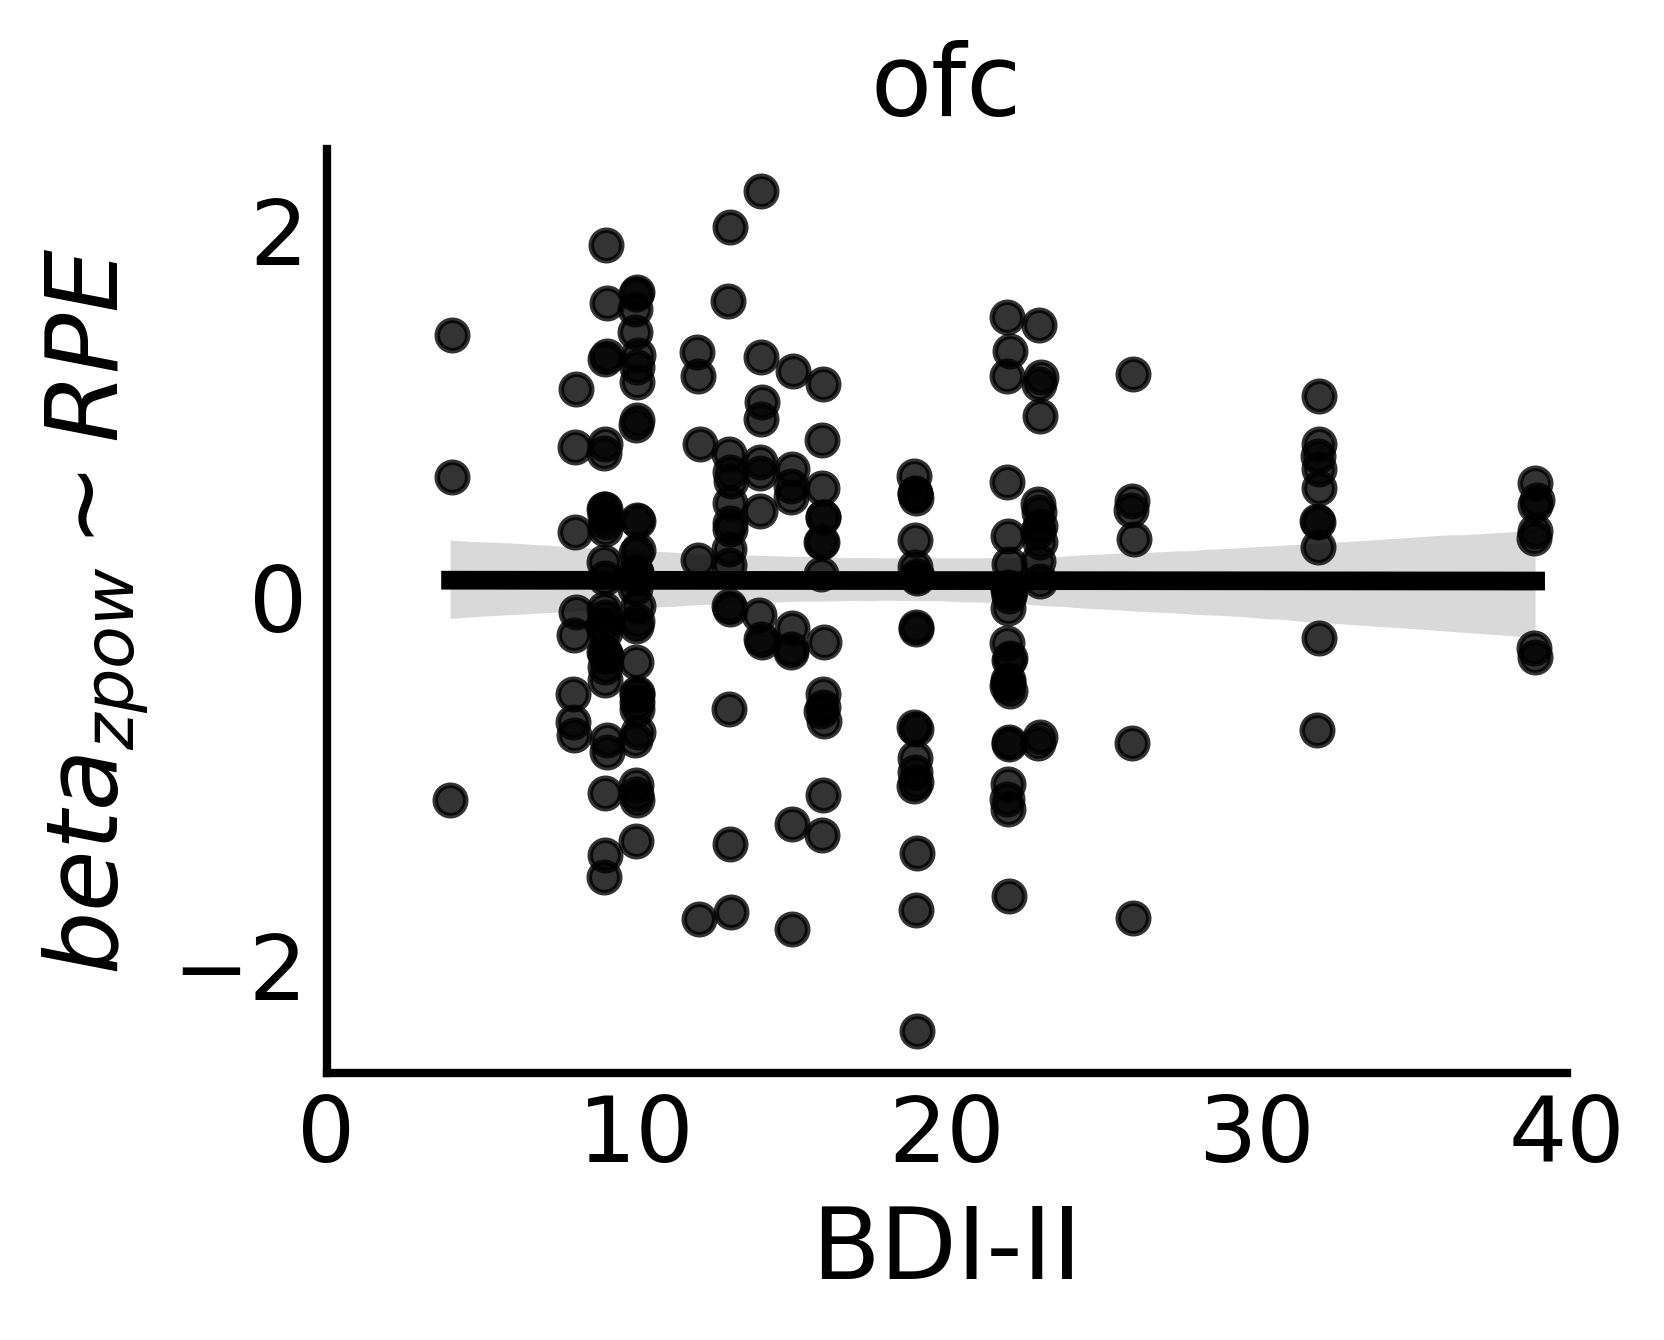

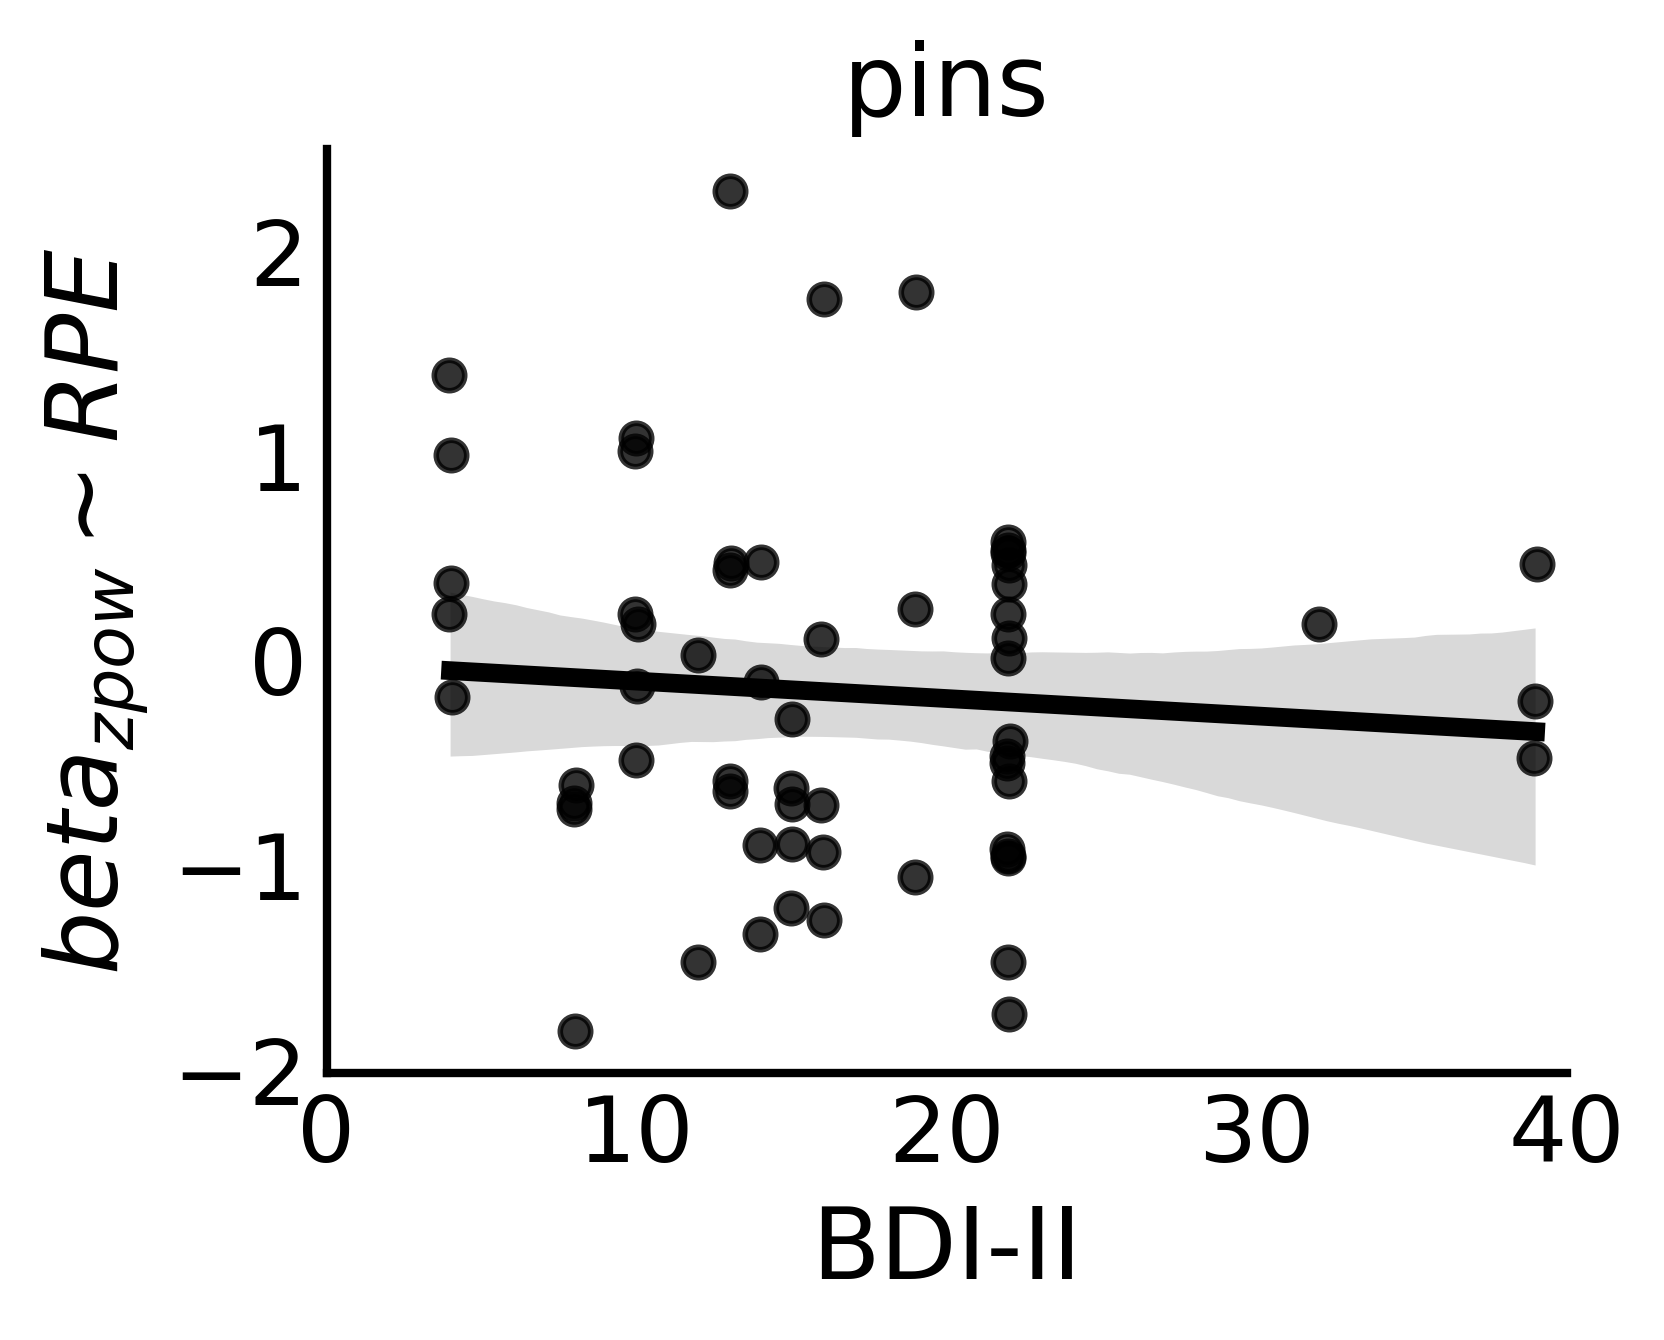

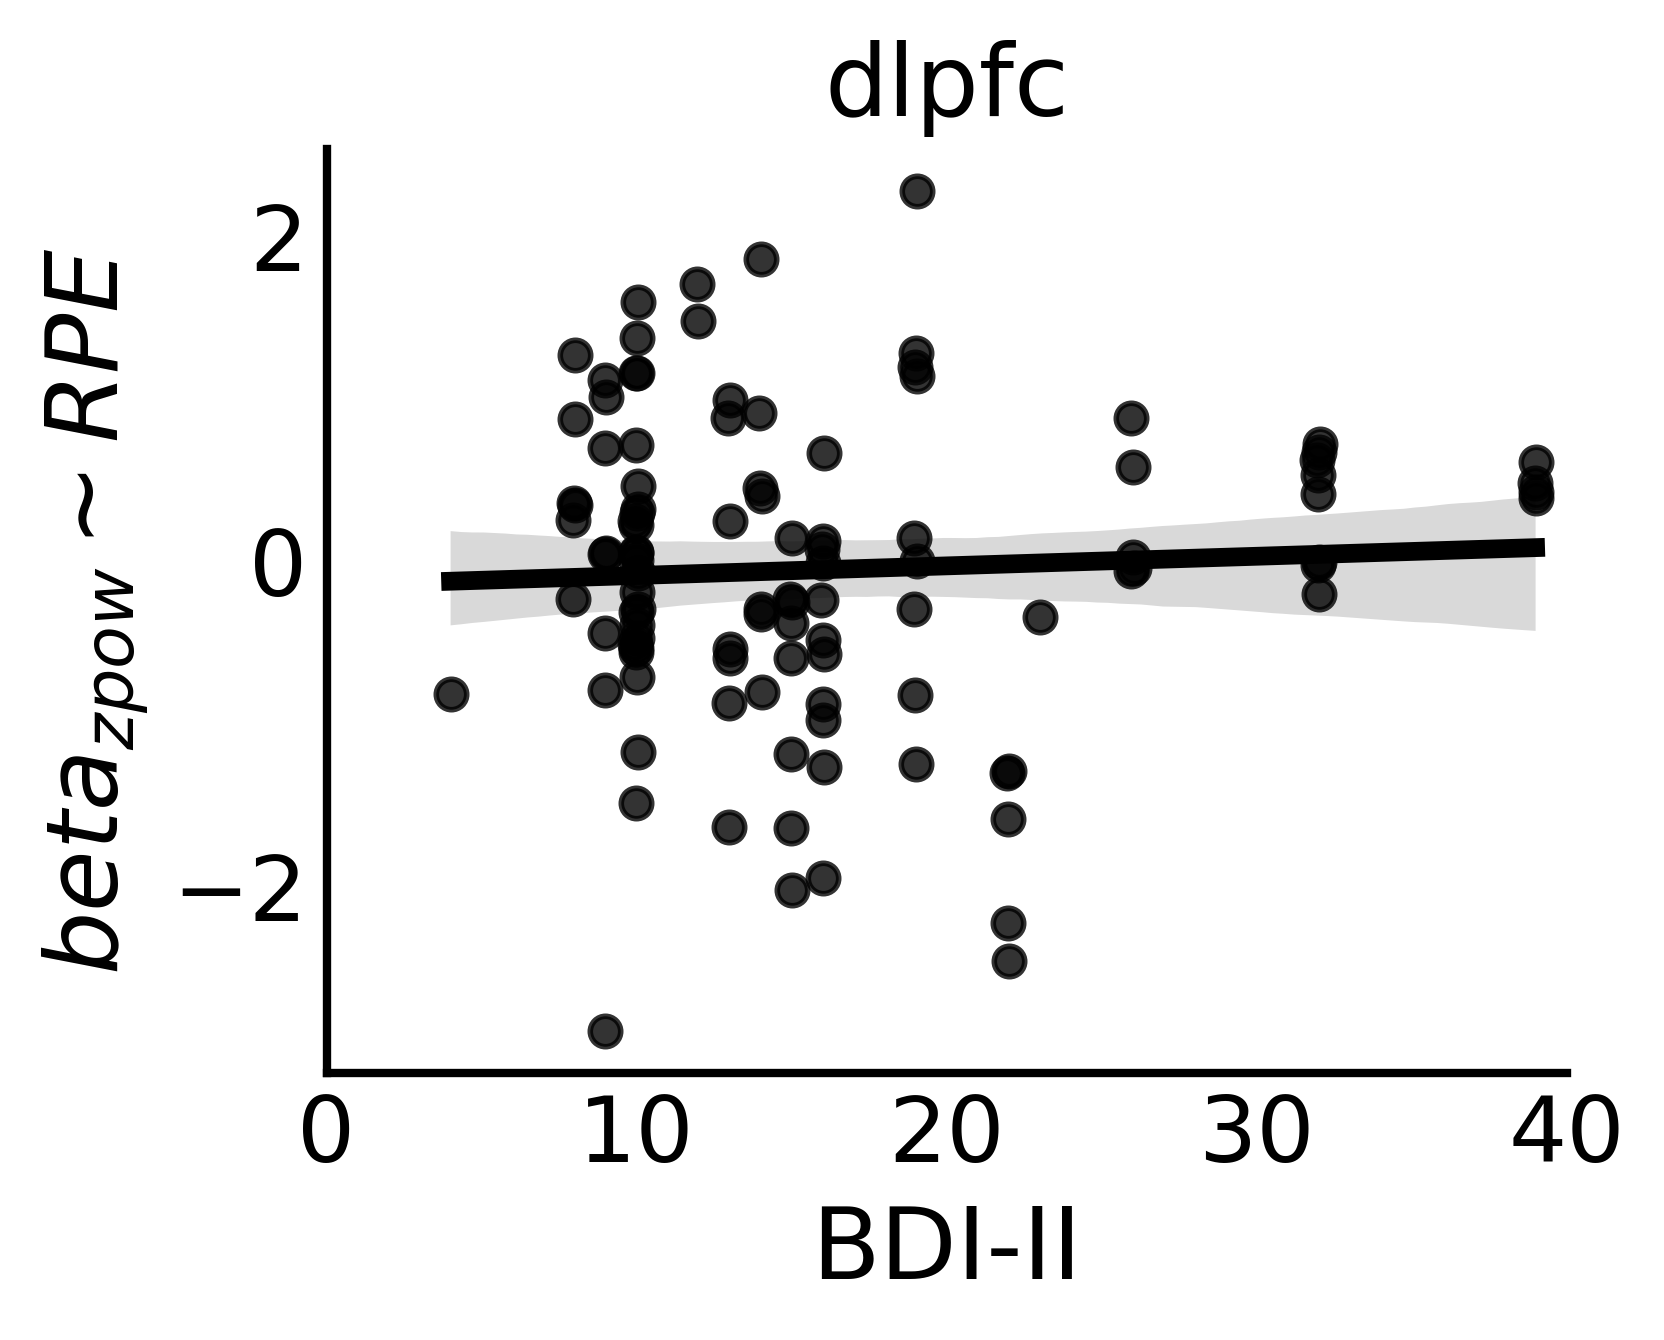

In [57]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in results.roi.unique().tolist():
    
    corr_fig_id = f'{band}_{roi}_bdi_combomodel_RPE_coeff_corr_{epoch_len}.pdf'
    
    roi_temp_data = results[results.roi==roi]
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=400)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_rpe',scatter=True,ci=95,
                fit_reg=True,color = 'k',x_jitter = 0.05,scatter_kws={'s':30}) #034975
    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
    plt.ylabel(fr'${band}_{{zpow}} \sim RPE$')


    plt.title(f'{roi}')
    sns.despine()

    plt.savefig(f'{fig_save_path}{corr_fig_id}', format=corr_fig_id.split('.')[-1], metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=400,
        facecolor='auto', edgecolor='auto',
        backend=None)
    


### Test BDI Correlations via robust regression

In [58]:
roi_rlm_dict = {}

for roi in results.roi.unique().tolist():
    roi_df = results[results.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_rpe.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())


acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 30 Sep 2024                                         
Time:                        20:20:20                                         
No. Iterations:                    13                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.6693      0.423     37.077     

In [59]:
del rpe_var

# Profit Coefficients

In [60]:
sig_data = results[results.P_Value_Profit < 0.05]
sig_data



unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
46      MS002_lsif3-lsif4   MS002  vlpfc   14                    -0.130569   
83    MS003_laglt3-laglt4   MS003    amy    8                    -0.012812   
91    MS003_lmcms8-lmcms9   MS003  dmpfc    8                    -0.031709   
112   MS003_raimm1-raimm2   MS003   ains    8                    -0.038790   
149   MS009_laias6-laias7   MS009  dlpfc   16                    -0.018177   
...                   ...     ...    ...  ...                          ...   
1161  DA039_rains5-rains6   DA039   ains   22                     0.121571   
1179      DA039_rof8-rof9   DA039  dlpfc   22                     0.060652   
1181    DA039_rof10-rof11   DA039  dlpfc   22                     0.062777   
1182    DA039_rof11-rof12   DA039  dlpfc   22                    -0.003063   
1183  DA039_rpins1-rpins2   DA039   pins   22                     0.038989   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
46                                 -0.038142                  -0.169123   
83                                  0.036589                  -0.274469   
91                                  0.027241                   0.507069   
112                                 0.088230                   0.343524   
149                                -0.031863                  -0.307770   
...                                      ...                        ...   
1161                               -0.158229                  -0.479407   
1179                               -0.113197                  -0.427546   
1181                               -0.115574                  -0.288740   
1182                               -0.064077                  -0.175905   
1183                               -0.014003                  -0.271416   

      Original_Estimate_Profit  Original_Estimate_rpe  Original_Estimate_cpe  \
46                    0.248182              -0.201661              -0.022574   
83                    0.476885              -0.292470              -0.142438   
91                   -0.850990               0.654281               0.200328   
112                  -0.612287               0.495728               0.080535   
149                   0.389337              -0.240317              -0.075297   
...                        ...                    ...                    ...   
1161                  0.823704              -0.555490              -0.099126   
1179                  0.716675              -0.458414              -0.025959   
1181                  0.511075              -0.260948              -0.060725   
1182                  0.345200              -0.220816              -0.010370   
1183                  0.468334              -0.267821              -0.067995   

      ...  Z_Score_cpe  P_Value_Intercept  P_Value_GambleChoice[T.safe]  \
46    ...    -0.833975           0.091419                      0.090339   
83    ...    -2.091526           0.361351                      0.322846   
91    ...     1.713350           0.572395                      0.632708   
112   ...     0.881635           0.044351                      0.050876   
149   ...    -1.686104           0.320700                      0.332797   
...   ...          ...                ...                           ...   
1161  ...    -1.182107           0.010823                      0.013756   
1179  ...    -0.454380           0.008163                      0.012298   
1181  ...    -1.024285           0.005813                      0.006586   
1182  ...    -0.374754           0.010711                      0.008020   
1183  ...    -1.166192           0.603077                      0.783695   

      P_Value_TrialEV  P_Value_Profit  P_Value_rpe  P_Value_cpe  cpe_sig  \
46           0.027358        0.015056     0.002351     0.404295        0   
83           0.045711        0.040907     0.086330     0.036481        1   
91           0.030586        0.029779     0.019862     0.086648        0   
112    

In [61]:
sig_data.roi.value_counts()



roi
dmpfc    13
hpc      10
amy      10
acc       9
ains      8
dlpfc     6
ofc       5
vlpfc     4
pins      2
Name: count, dtype: int64

In [62]:
sig_data.roi.unique()



array(['vlpfc', 'amy', 'dmpfc', 'ains', 'dlpfc', 'pins', 'ofc', 'acc',
       'hpc'], dtype=object)

### ROI Significance Testing
- % of sig elecs in ROI (also split by BDI)
- binomial test for whether sig proportion of elecs in ROI 
- ttests from zero 


In [63]:
# add mask col for sig cpe elecs 
results['Profit_sig']   = results['P_Value_Profit'].apply(lambda x: 0 if x > 0.05 else 1)
results['bdi_split'] = results['bdi'].apply(lambda x: 0 if x < 20 else 1)

results.head()

# results.to_csv(f'{save_path}{band}_perm_regression_results_df_{epoch_len}.csv')

unique_elec_id subj_id  roi  bdi  Original_Estimate_Intercept  \
0  MS002_lacas1-lacas2   MS002  acc   14                     0.062638   
1  MS002_lacas2-lacas3   MS002  acc   14                     0.062795   
2  MS002_lacas3-lacas4   MS002  acc   14                     0.047164   
3  MS002_lacas4-lacas5   MS002  acc   14                     0.008430   
4  MS002_lacas5-lacas6   MS002  acc   14                     0.041894   

   Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                               -0.123822                  -0.021673   
1                               -0.086248                   0.217292   
2                               -0.081376                   0.146646   
3                               -0.021970                   0.326099   
4                               -0.046182                   0.199258   

   Original_Estimate_Profit  Original_Estimate_rpe  Original_Estimate_cpe  \
0                  0.084899               0.008475               0.013529   
1                 -0.279191               0.277946               0.002570   
2                 -0.164104               0.172035               0.064983   
3                 -0.357296               0.166529               0.112233   
4                 -0.286195               0.183201               0.058915   

   ...  P_Value_Intercept  P_Value_GambleChoice[T.safe]  P_Value_TrialEV  \
0  ...           0.004627                      0.004545         0.938500   
1  ...           0.038478                      0.037840         0.143297   
2  ...           0.035191                      0.035509         0.270250   
3  ...           0.587085                      0.591145         0.019644   
4  ...           0.277605                      0.280328         0.170207   

   P_Value_Profit  P_Value_rpe  P_Value_cpe  cpe_sig  bdi_split  rpe_sig  \
0        0.716878     0.898156     0.809226        0          0        0   
1        0.156983     0.033642     0.961038        0          0        1   
2        0.357693     0.143398     0.156005        0          0        0   
3        0.050758     0.161198     0.025015        1          0        0   
4        0.140250     0.154092     0.223590        0          0        0   

   Profit_sig  
0           0  
1           0  
2           0  
3           0  
4           0  

[5 rows x 38 columns]

In [64]:
Profit_var = 'Z_Score_Profit'

In [65]:
# bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']
bar_order = keep_rois.copy()


In [66]:
results.groupby('roi').agg('mean',numeric_only=True)[Profit_var][bar_order]



roi
dlpfc    0.099222
vlpfc    0.013384
dmpfc   -0.155749
ofc     -0.055601
ains    -0.178355
pins     0.160099
acc      0.041917
amy     -0.064512
hpc      0.053100
Name: Z_Score_Profit, dtype: float64

In [67]:
roi_sig_info = []

for roi in results.roi.unique().tolist():
    roi_results = results[results.roi==roi]
    # ttest from zero 
    ttest_stat,ttest_pval = ttest_1samp(roi_results[Profit_var],popmean=0)
    # binomial test for significance 
    n = len(roi_results)
    x = np.sum(roi_results.Profit_sig)
    binom_test = scipy.stats.binomtest(x, n, p=0.05, alternative='greater')
    binom_pval = binom_test.pvalue
    binom_prop = binom_test.statistic
    ci_low     = binom_test.proportion_ci(confidence_level=0.95).low
    ci_high    = binom_test.proportion_ci(confidence_level=0.95).high
    # agg results 
    roi_sig_info.append(pd.DataFrame({'roi':roi,'n_total':n,'n_sig':x,'prop_sig':np.divide(x,n),
                                      'n_sig_highbdi':np.sum(roi_results[roi_results.bdi_split==1].Profit_sig),
                                      'ttest_stat':ttest_stat,'ttest_pval':ttest_pval,
                                      'binom_ci_low':ci_low,'binom_ci_high':ci_high,
                                      'binom_prop':binom_prop,'binom_pval':np.round(binom_pval,4)},index=[0]))

roi_sig_info = pd.concat(roi_sig_info).reset_index(drop=True)

In [68]:
roi_sig_info

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat  ttest_pval  \
0    acc      193      9  0.046632              2    0.582731    0.560758   
1  dmpfc      225     13  0.057778              4   -2.348972    0.019696   
2    amy      113     10  0.088496              1   -0.618709    0.537364   
3   ains       71      8  0.112676              1   -1.259447    0.212052   
4  vlpfc       82      4  0.048780              2    0.116790    0.907315   
5    hpc      135     10  0.074074              0    0.563987    0.573706   
6    ofc      202      5  0.024752              0   -0.912157    0.362779   
7   pins       60      2  0.033333              1    1.307860    0.195994   
8  dlpfc      107      6  0.056075              3    1.065617    0.289018   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
0      0.024540            1.0    0.046632      0.6315  
1      0.034511            1.0    0.057778      0.3367  
2      0.048799            1.0    0.088496      0.0571  
3      0.057316            1.0    0.112676      0.0252  
4      0.016832            1.0    0.048780      0.5912  
5      0.040736            1.0    0.074074      0.1396  
6      0.009803            1.0    0.024752      0.9753  
7      0.005955            1.0    0.033333      0.8084  
8      0.024699            1.0    0.056075      0.4468

In [69]:
sig_rois = roi_sig_info[roi_sig_info.binom_pval<0.05]
sig_rois

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat  ttest_pval  \
3  ains       71      8  0.112676              1   -1.259447    0.212052   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
3      0.057316            1.0    0.112676      0.0252

# Plot Results

In [72]:
fig_save_path = f'{fig_dir}{band}/'
os.makedirs(fig_save_path, exist_ok=True)

fig_id = f'{band}_perm_regression_combomodel_Profit_coeff_barplot_{epoch_len}.pdf'

ylabel = fr'${band}_{{zpow}} \sim Profit$'


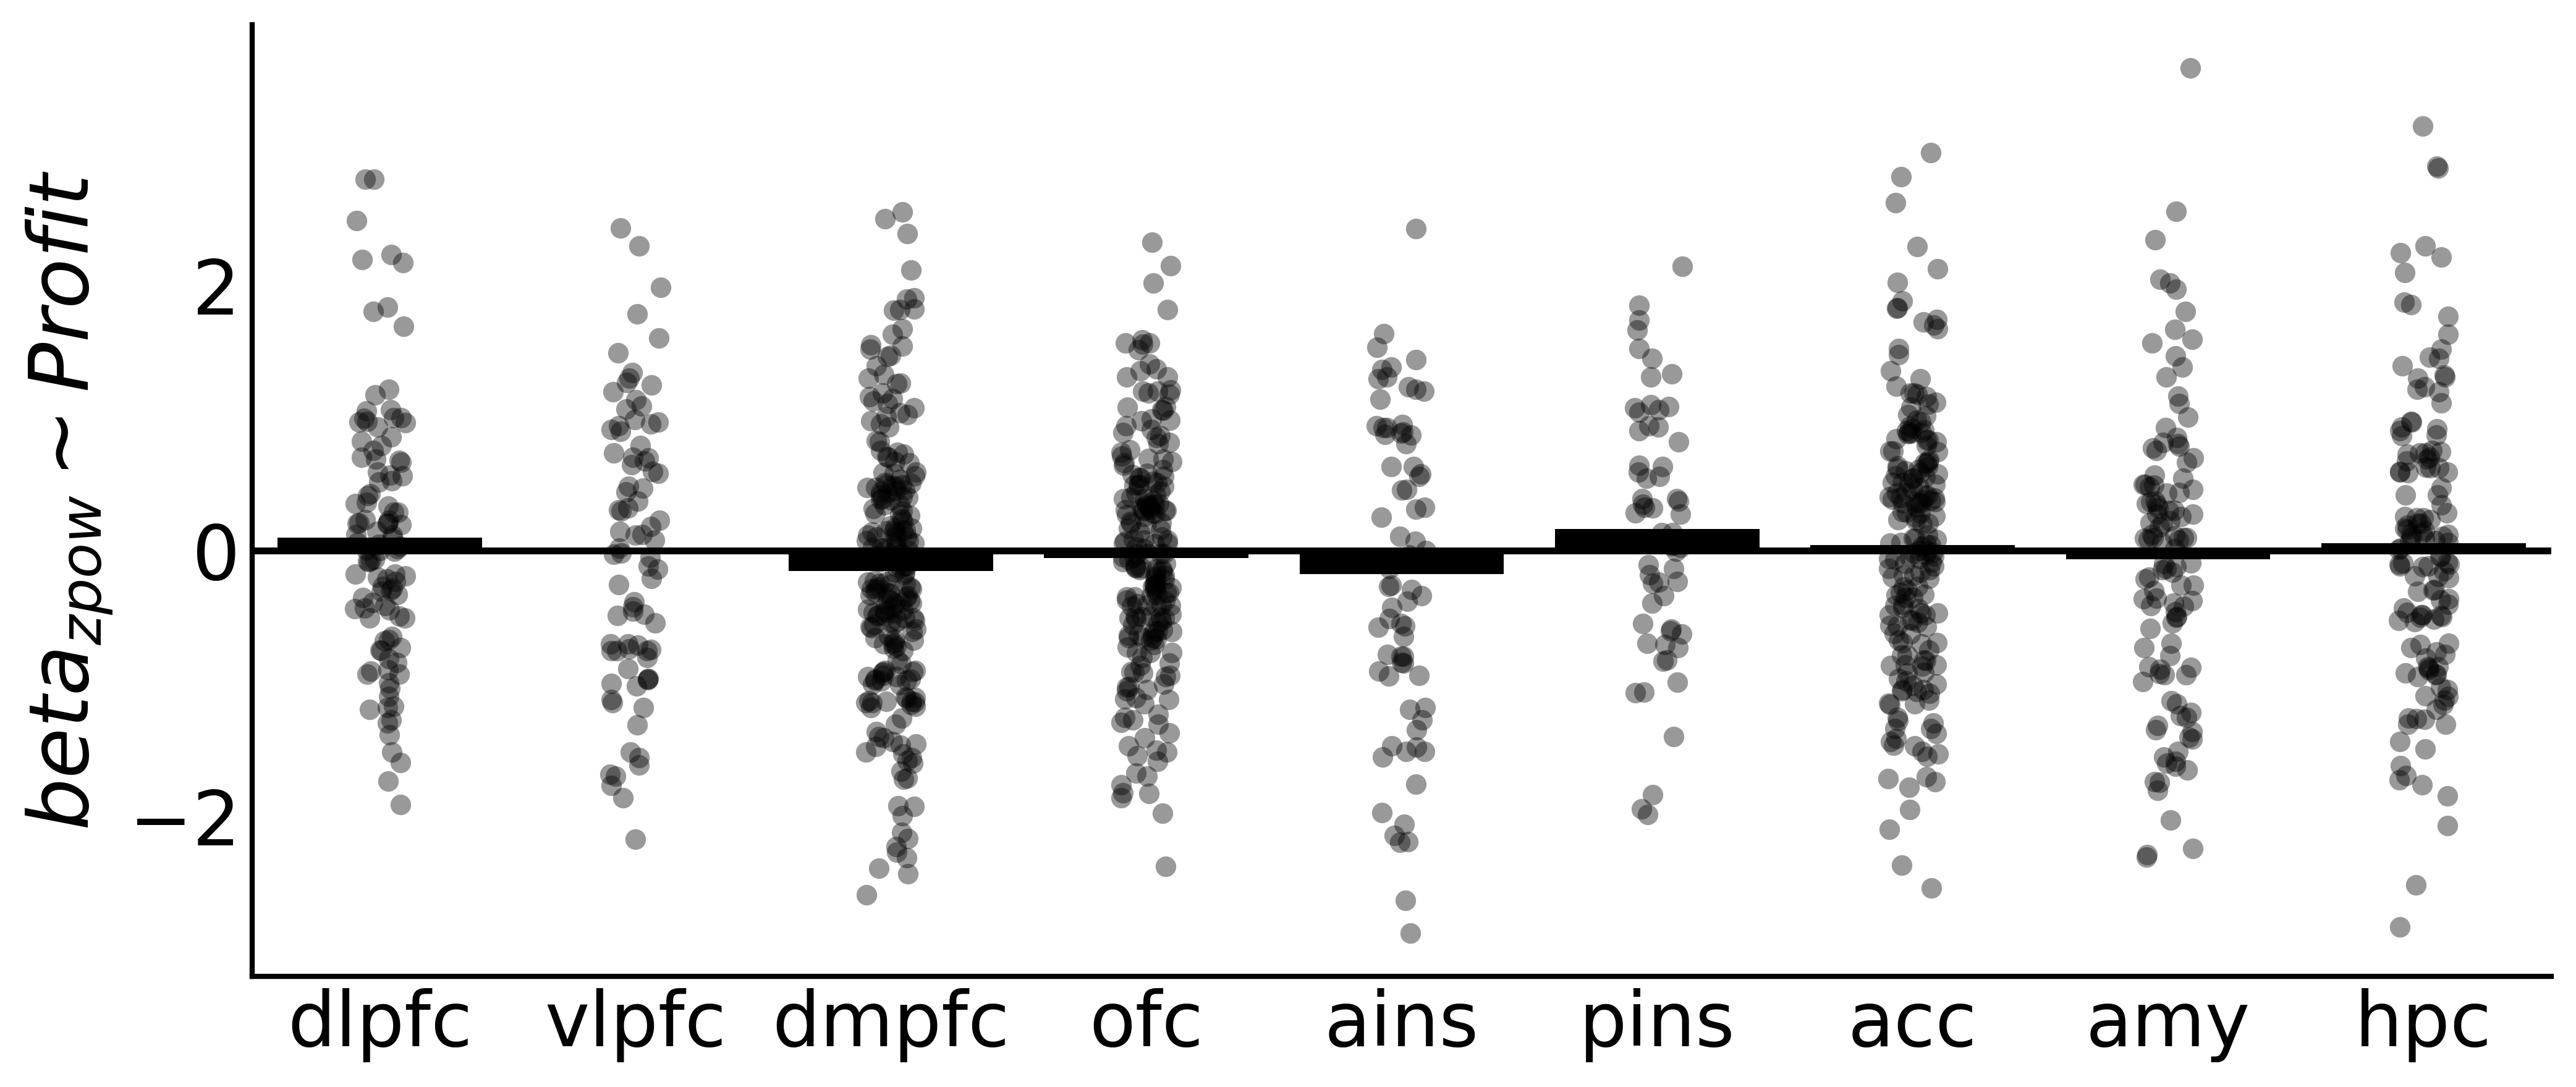

In [73]:
### WITHOUT RPE IN MODEL
plot_roi_model_results(results,'roi',Profit_var,bar_order=keep_rois,figsize=(12,5),color='k',
                       ylabel=ylabel,save_fig=True,save_dir=fig_save_path,fig_id=fig_id,dpi=400)



## BDI correlations

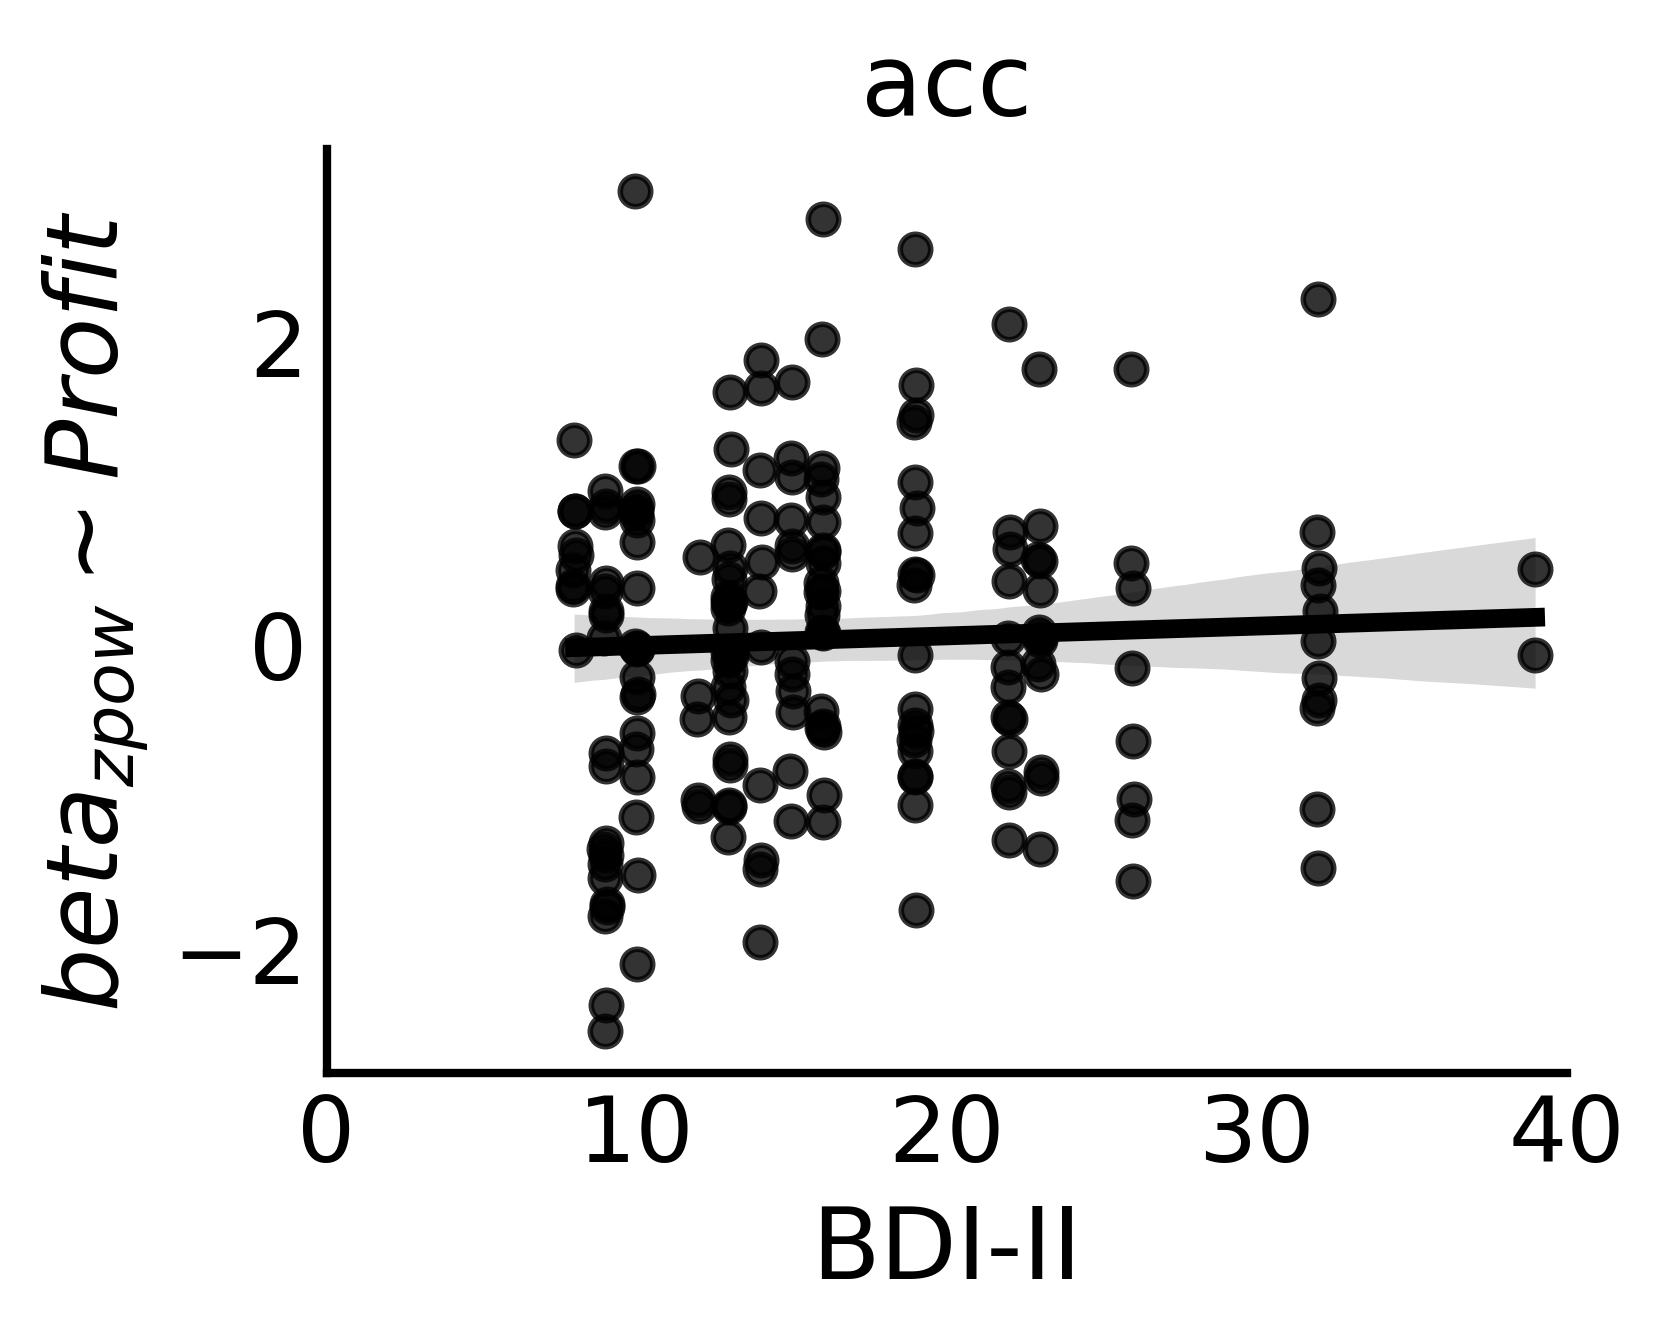

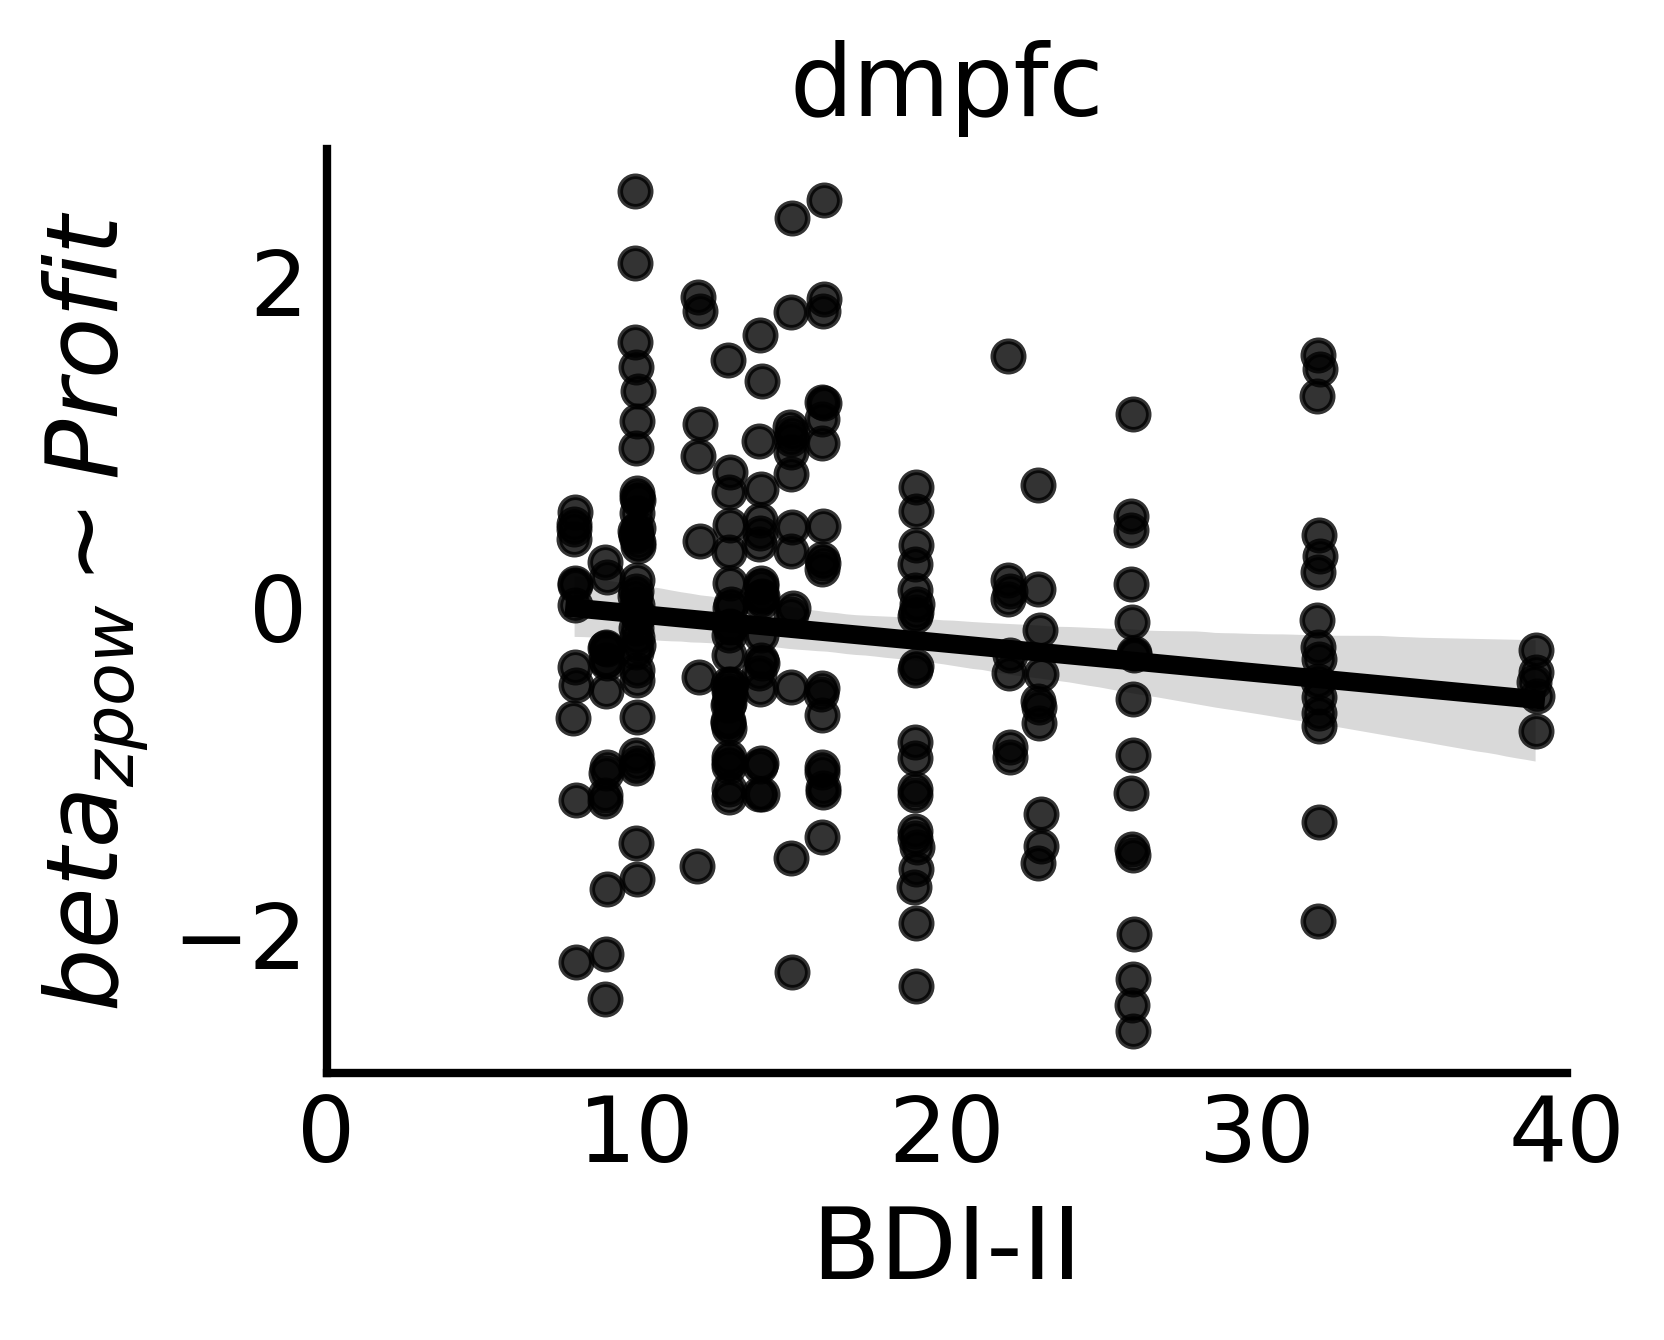

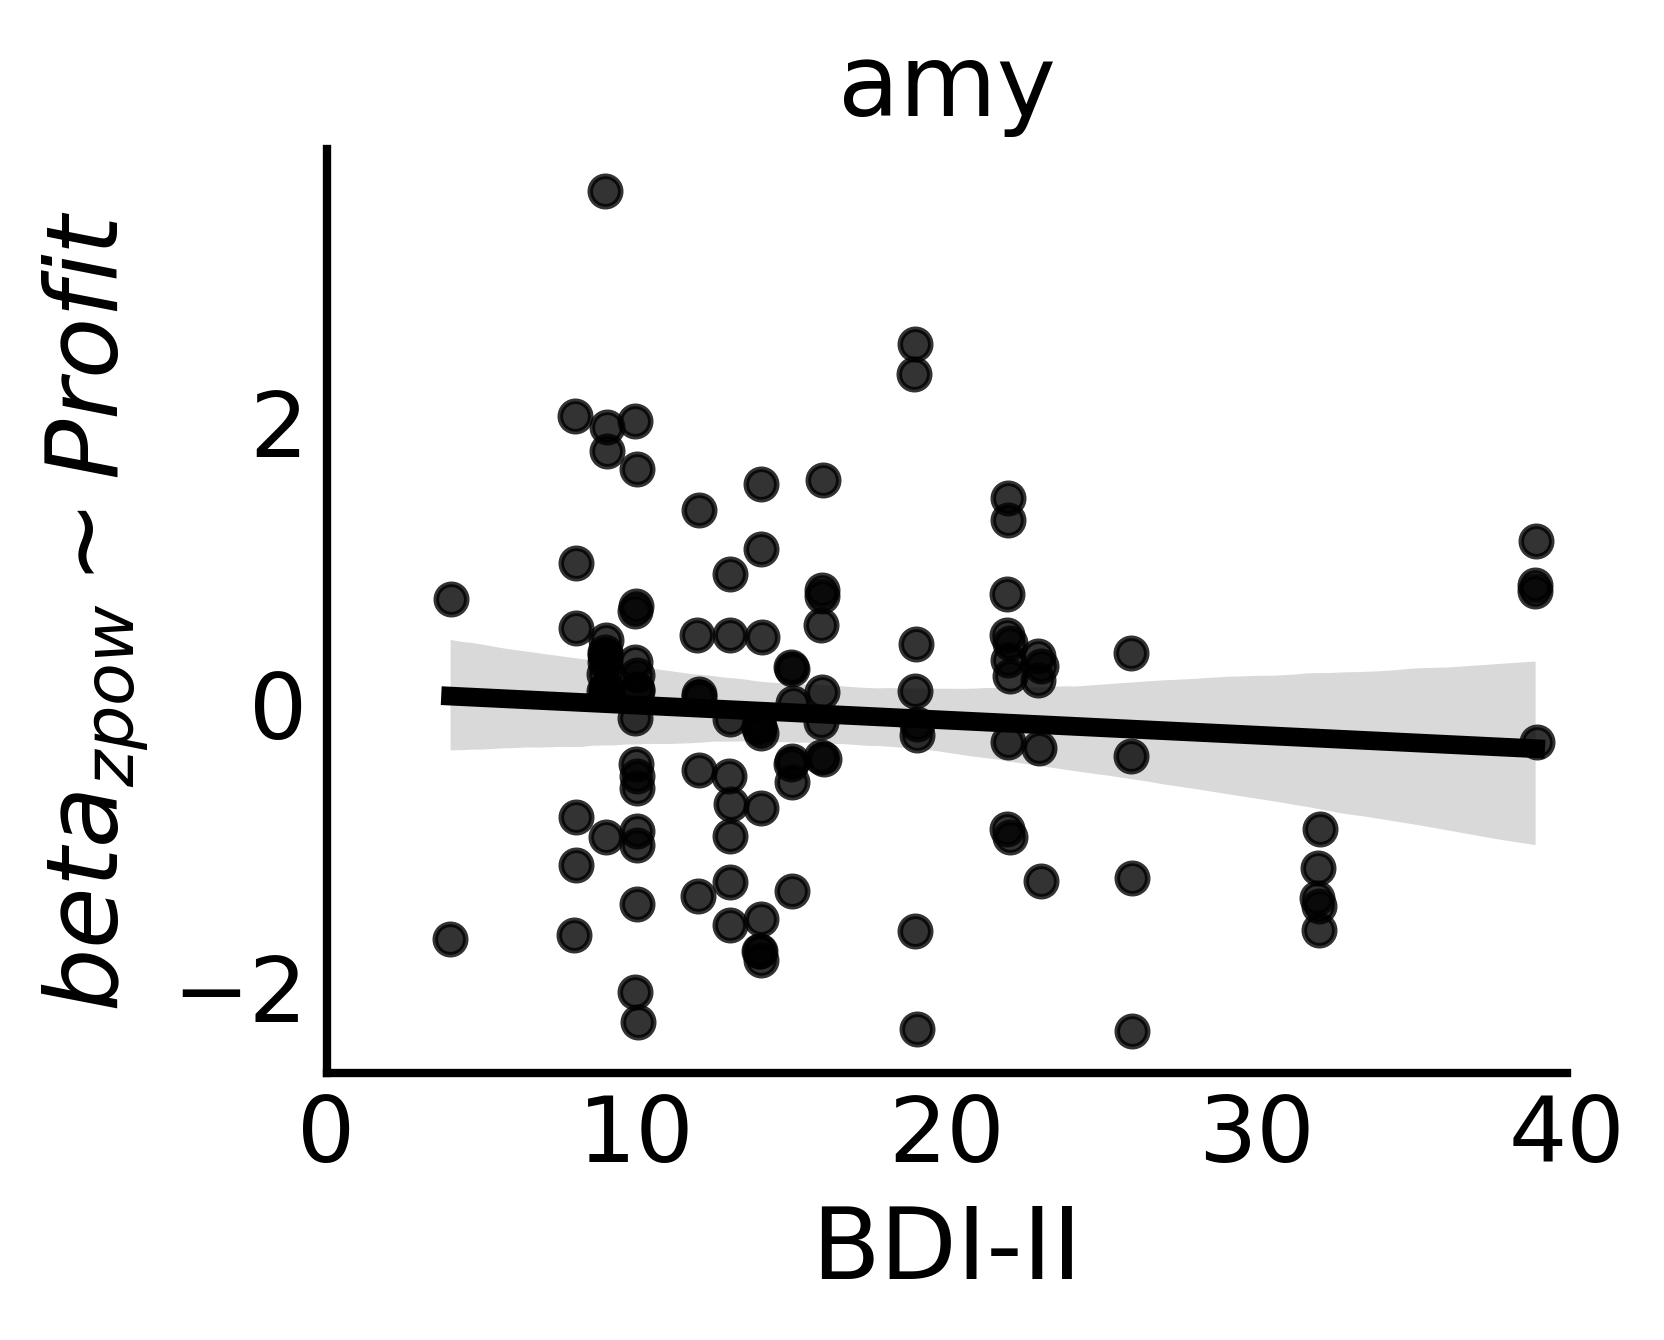

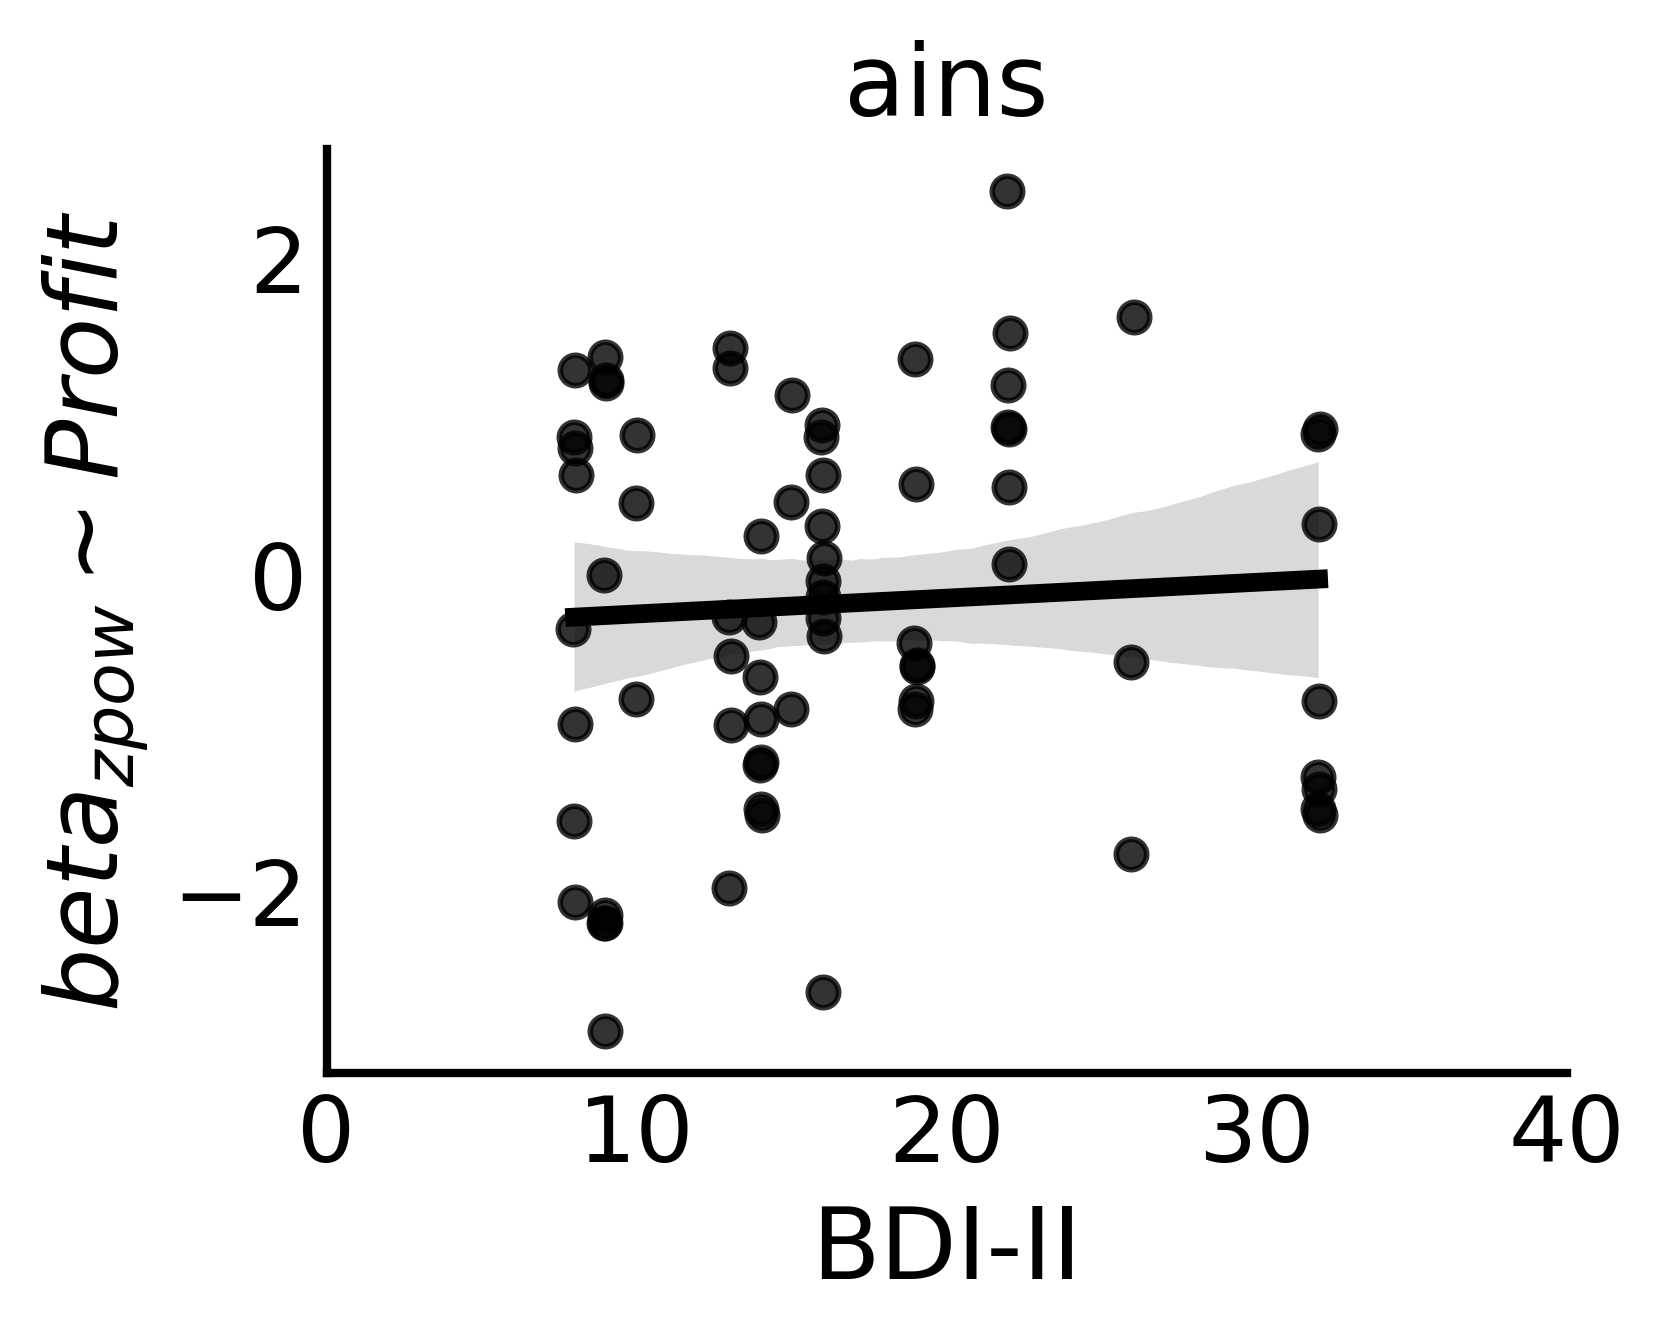

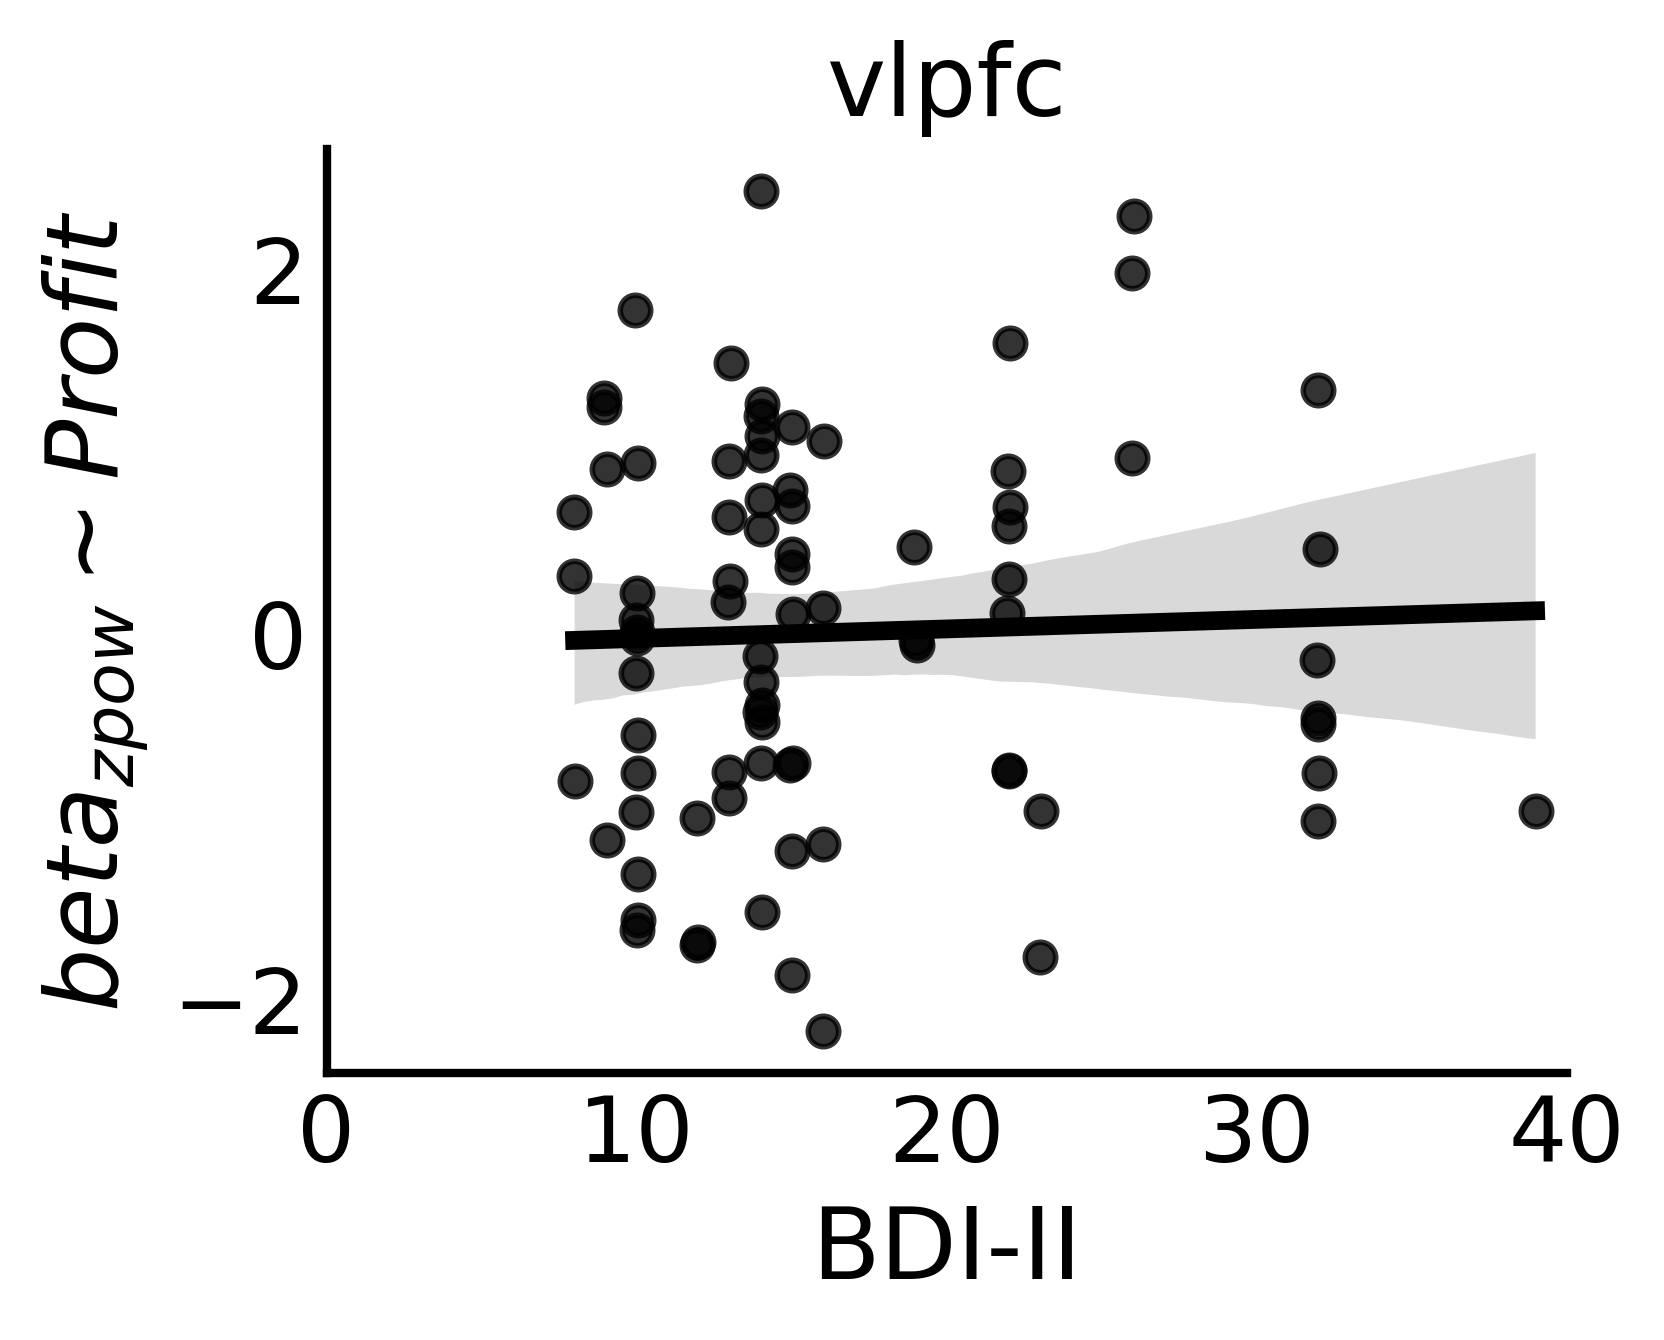

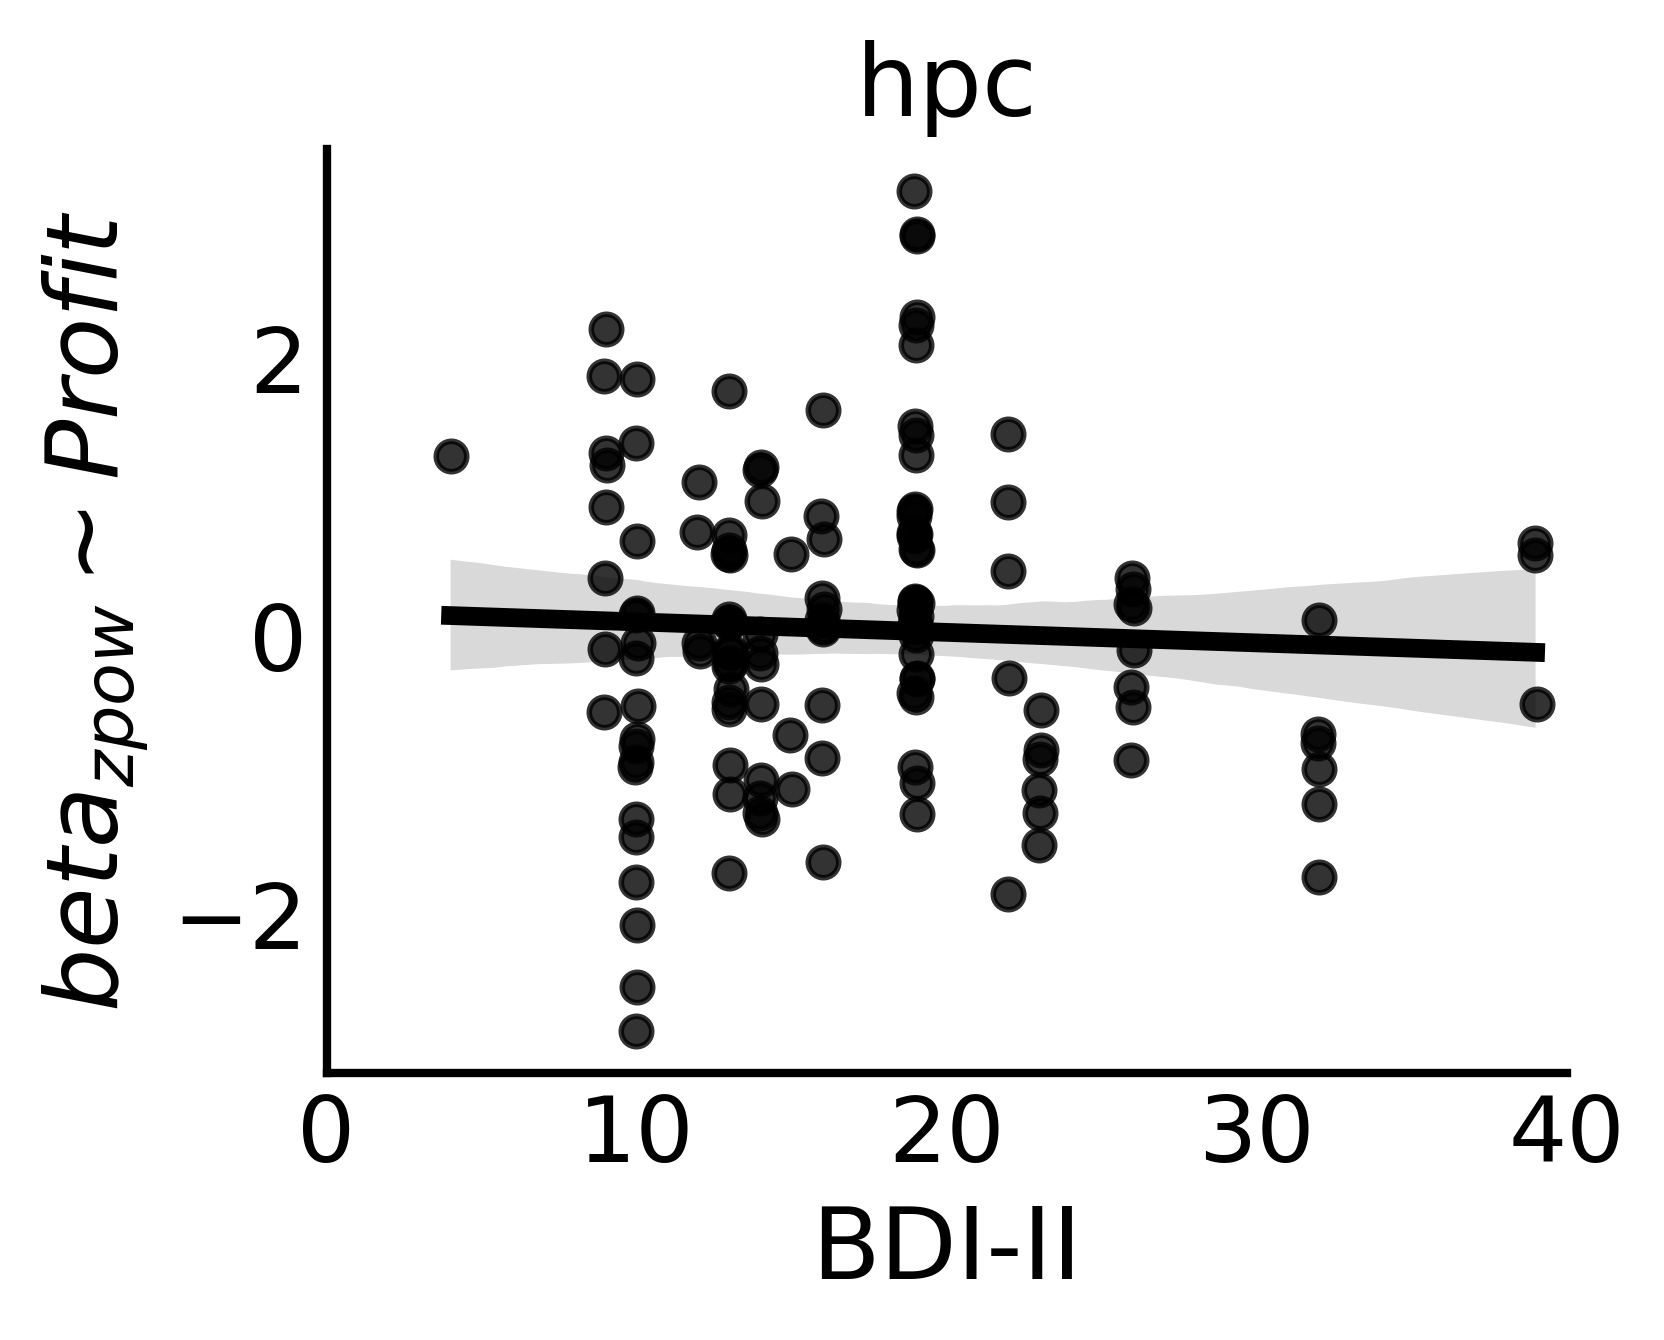

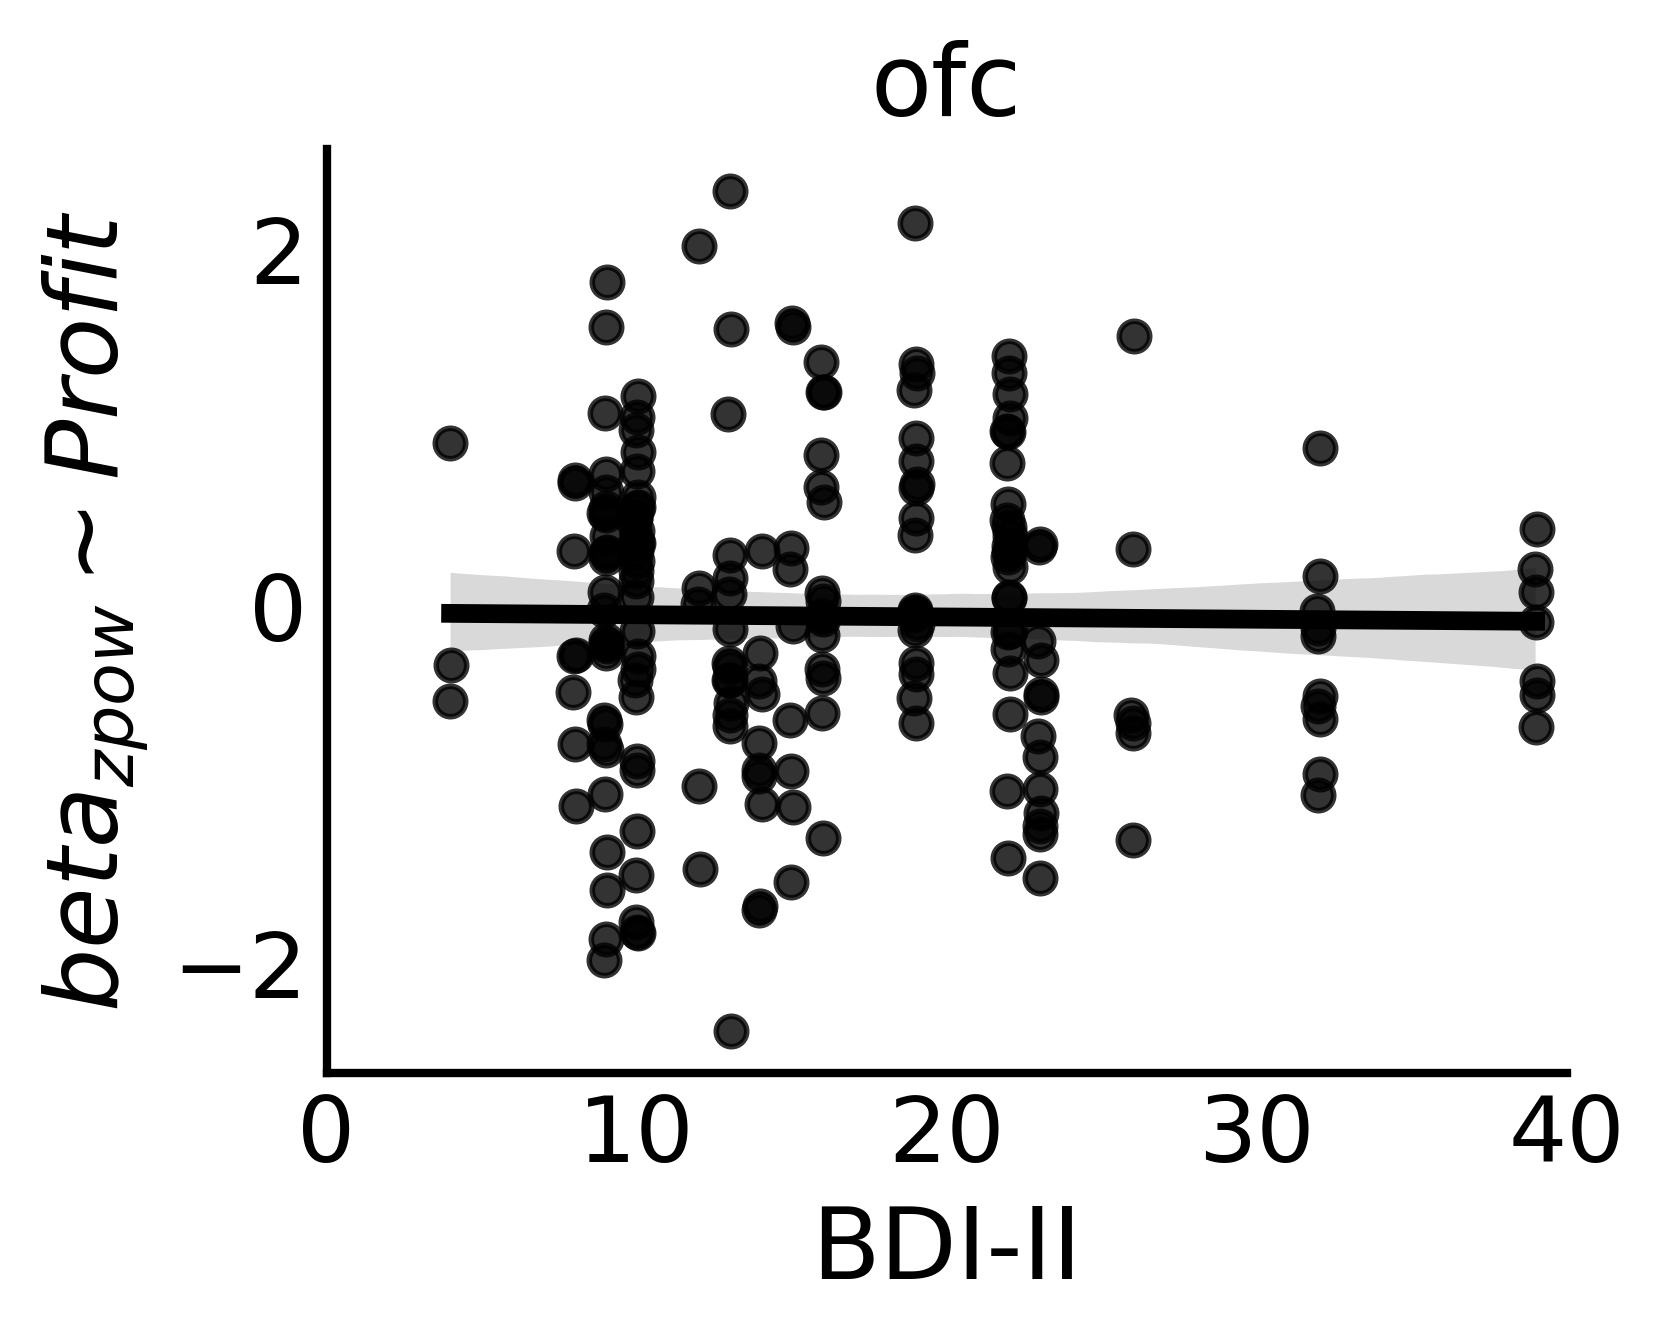

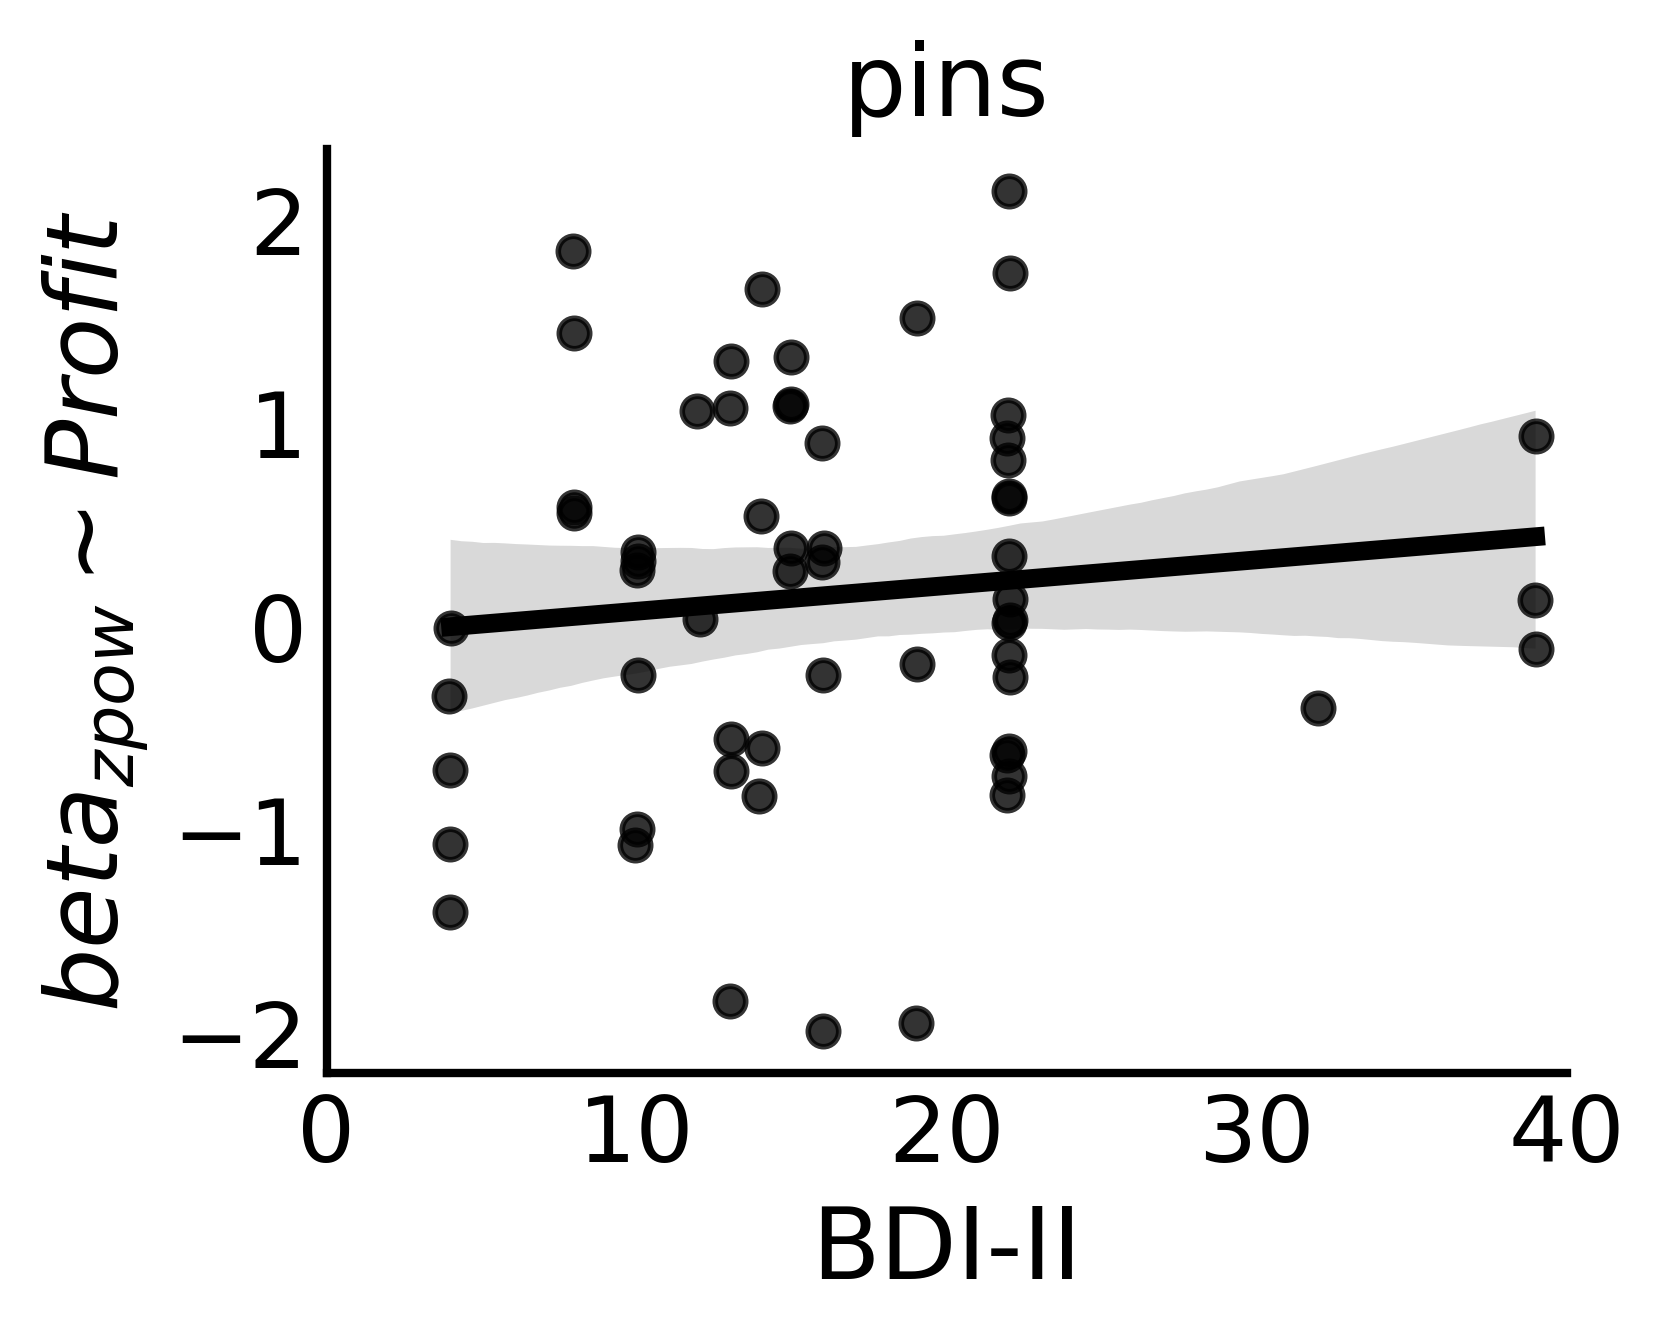

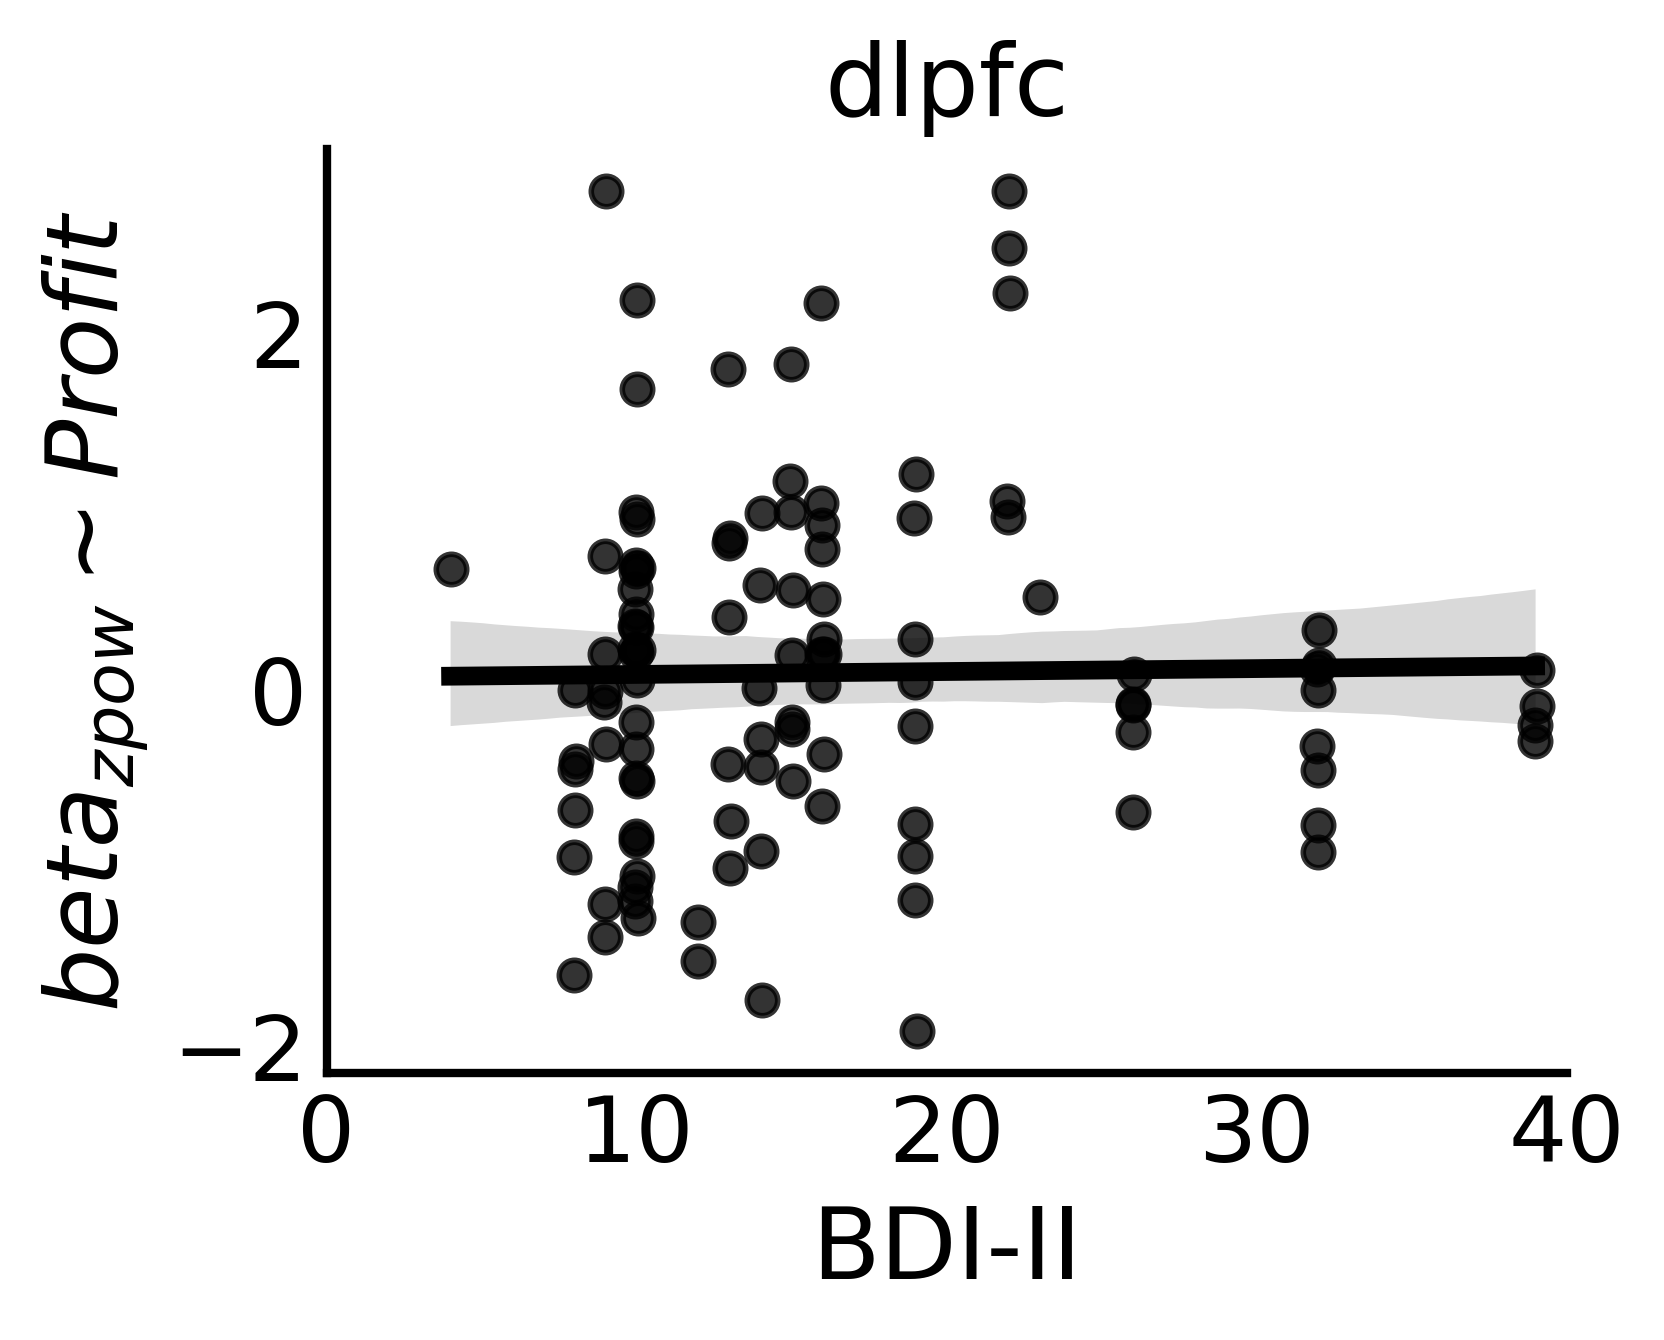

In [74]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in results.roi.unique().tolist():
    
    corr_fig_id = f'{band}_{roi}_bdi_combomodel_Profit_coeff_corr_{epoch_len}.pdf'
    
    roi_temp_data = results[results.roi==roi]
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=400)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_Profit',scatter=True,ci=95,
                fit_reg=True,color = 'k',x_jitter = 0.05,scatter_kws={'s':30}) #034975
    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
    plt.ylabel(fr'${band}_{{zpow}} \sim Profit$')


    plt.title(f'{roi}')
    sns.despine()

    plt.savefig(f'{fig_save_path}{corr_fig_id}', format=corr_fig_id.split('.')[-1], metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=400,
        facecolor='auto', edgecolor='auto',
        backend=None)
    


### Test BDI Correlations via robust regression

In [75]:
roi_rlm_dict = {}

for roi in results.roi.unique().tolist():
    roi_df = results[results.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_Profit.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())


acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 30 Sep 2024                                         
Time:                        20:23:07                                         
No. Iterations:                    13                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.8551      0.441     35.920     